# BTK Akademi 2023 Datathon Yarışması 

## İçindekiler:
1. [Veri Setlerinin Yüklenmesi](#veri-setlerini-yüklemek)
1. [Keşifsel Veri Analizi](#keşifsel-veri-analizi)
1. [İlişkisel Veri Analizi](#i̇lişkisel-veri-analizi)
1. [Kümeleme Analizi](#kümeleme-analizi)
1. [Hedef Değişken Analizi](#hedef-değişken-öbek-i̇smi-analizi)
1. [Tahminleme Çalışması](#tahminleme-çalışması)
1. [Sonuç ve Tartışma](#sonuç-ve-tartışma)
1. [Submission](#submission)
1. [Vakit kalsaydı deneyeceğim bir diğer yöntem](#balyalama-ile-kategorik-analizi--tahminleme)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/datathon2023/sample_submission.csv
/kaggle/input/datathon2023/test_x.csv
/kaggle/input/datathon2023/train.csv


# Veri Setlerini Yüklemek

In [2]:
import pandas as pd 
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_csv("/kaggle/input/datathon2023/train.csv")
test = pd.read_csv("/kaggle/input/datathon2023/test_x.csv")
train = df.copy()

In [4]:
df.head(3)

index Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi  \
0      0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu   
1      1    Erkek       >60         Evli           Lise Mezunu   
2      2    Erkek     18-30        Bekar           Lise Mezunu   

                  İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir  \
0  Düzenli ve Ücretli Bir İşi Var              748266.44    Büyük Şehir   
1             Kendi İşinin Sahibi              246298.61    Küçük Şehir   
2  Düzenli ve Ücretli Bir İşi Var              268582.73    Küçük Şehir   

      En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  \
0  Elektronik ve Teknolojik Ürünler                            32010.90   
1                  Spor Malzemeleri                             4145.73   
2                             Giyim                             9924.38   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu  \
0                                       37.31                   Etmiyor   
1                                       11.55                   Etmiyor   
2                                       55.35                    Ediyor   

  Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi  
0    obek_4                                    102.94  
1    obek_5                                     82.18  
2    obek_8                                    141.66

In [5]:
df.shape

(5460, 14)

---

## Kullanışlı Fonksiyonlar

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('inferno')

In [7]:
def find_categorics(df, cardinality=20):
    ''''Find_categorics' işlevi girdi olarak bir DataFrame alır ve veri türlerine ve önem derecesine göre
    kategorik sütunların bir listesini döndürür.
    
    Parameters
    ----------
    df
        Kategorik sütunları bulmak istediğiniz giriş veri çerçevesi.
    cardinality, optional
        "Önemlilik" parametresi, bir sütunun kategorik sütun olarak kabul edilmesi için izin verilen
    maksimum benzersiz değer sayısını belirtmek için kullanılır. Belirtilen önem düzeyinden daha büyük
    sayıda benzersiz değere sahip tüm sütunlar, kategorik sütunlar listesinden hariç tutulacaktır.
    
    Returns
    -------
        belirli bir veri çerçevesindeki kategorik sütunların listesi.
    
    '''
    str_cat_cols = [col for col in df.columns if str(df[col].dtype) in ['object', 'category']]
    num_cat_cols = [col for col in df.columns if str(df[col].dtype) in ['int64', 'float64'] and df[col].nunique() < cardinality]
    bool_cat_cols = [col for col in df.columns if str(df[col].dtype) in ['bool']]
    high_cardinality_cols = [col for col in df.columns if str(df[col].dtype) in ['object', 'category'] and df[col].nunique() > cardinality]

    categorical_columns = str_cat_cols + num_cat_cols + bool_cat_cols
    categorical_columns = [col for col in categorical_columns if col not in high_cardinality_cols]

    return categorical_columns


def categoric_summary(df, col_name, plot=False, rotation_degree=0, figure_width=10, figure_height=6):
    '''"categoric_summary" işlevi, çizim için bir DataFrame, bir sütun adı ve isteğe bağlı parametreler
    alır ve benzersiz değerlerin sayısı, eksik değerlerin sayısı, eksik değerlerin yüzdesi ve veri türü
    dahil olmak üzere kategorik sütunun bir özetini döndürür .
    
    Parameters
    ----------
    df
        Analiz etmek istediğiniz veri çerçevesi.
    col_name
        DataFrame'de özetlemek ve çizmek istediğiniz sütunun adı (eğer çizim=True ise).
    plot, optional
        Sütun değerlerinin sayım grafiğinin çizilip çizilmeyeceğini belirleyen bir boole parametresi.
    Varsayılan Yanlış'tır.
    rotation_degree, optional
        rotasyon_degree parametresi, sayım grafiğindeki x ekseni onay etiketlerinin dönüş açısını (derece
    cinsinden) belirtmek için kullanılır. Varsayılan olarak 0'a ayarlıdır; bu, onay etiketlerinin yatay
    olacağı anlamına gelir. Onay etiketlerini tercihinize göre döndürmek için bu değeri
    değiştirebilirsiniz.
    figure_width, optional
        "figure_width" parametresi çizim şeklinin genişliğini inç cinsinden belirtmek için kullanılır.
    figure_height, optional
        "figure_height" parametresi çizim rakamının yüksekliğini inç cinsinden belirtmek için kullanılır.
    
    Returns
    -------
        DataFrame girişinde belirtilen sütun hakkında aşağıdaki bilgileri içeren bir pandas DataFrame:
    
    '''
    temp = pd.DataFrame({"Column Name": [col_name],
                         "N Unique": [df[col_name].nunique()],
                         "NaN": [df[col_name].isnull().sum()],
                         "NaN (%)": [df[col_name].isnull().sum() / df.shape[0]],
                         "Data Type": [df[col_name].dtypes]})


    if plot:
        plt.figure(figsize=(figure_width, figure_height))
        sns.countplot(x=col_name, data=df, order=df[col_name].value_counts().index, palette='inferno')
        plt.title(f"Count Plot of {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=rotation_degree, ha="right")
        for index, value in enumerate(df[col_name].value_counts()):
            plt.text(index, value, str(value), ha='center', va='bottom')

        plt.show()

    return temp.reset_index(drop=True)

In [8]:
def find_numerics(df):
    '''"Find_numerics" işlevi, kategorik sayısal sütunlar hariç, belirli bir veri çerçevesinden orijinal
    sayısal sütunların bir listesini döndürür.
    
    Parameters
    ----------
    df
        "df" parametresi bir pandanın DataFrame nesnesidir.
    
    Returns
    -------
        belirli bir veri çerçevesindeki orijinal sayısal sütunların listesi.
    
    '''
    numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    categorical_num_cols = [col for col in df.columns if df[col].nunique() < 10 and df[col].dtype in ['int64', 'float64']]
    original_numeric_cols = [col for col in numerical_cols if col not in categorical_num_cols]

    return original_numeric_cols


def numeric_summary(df, col_name, plot=False):
    ''''Numeric_summary' işlevi, bir veri çerçevesindeki belirli bir sütun için tanımlayıcı istatistikleri
    hesaplar ve isteğe bağlı olarak sütun değerlerinin bir histogramını çizer.
    
    Parameters
    ----------
    df
        "Df" parametresi, analiz etmek istediğiniz verileri içeren bir pandas DataFrame'dir.
    col_name
        'col_name' parametresi, DataFrame 'df'de kendisi için sayısal özet oluşturmak istediğiniz sütunun
    adıdır.
    plot, optional
        'Plot' parametresi, verilerin histogram grafiğinin görüntülenip görüntülenmeyeceğini belirleyen bir
    boole değeridir. 'Grafik', 'Doğru' olarak ayarlanırsa, işlev bir histogram grafiği oluşturacaktır.
    'Grafik', 'Yanlış' olarak ayarlanırsa, işlev bir çizim oluşturmaz.
    
    Returns
    -------
        veri çerçevesindeki belirtilen sütunun tanımlayıcı istatistikleri. 'Plot' parametresi 'True' olarak
    ayarlanmışsa, aynı zamanda sütun değerlerinin histogramını da görüntüler.
    
    '''
    describe = df[col_name].describe().T

    if plot:
        plt.figure(figsize=(8, 6))
        plt.hist(df[col_name], edgecolor='black', alpha=0.7)
        plt.axvline(df[col_name].mean(), color='navy', linestyle='--', linewidth=2, label='Mean')
        plt.title(f'Distribution of {col_name.capitalize()}')
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.legend()
        plt.show()

    return describe

---

# Keşifsel Veri Analizi

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       5460 non-null   int64  
 1   Cinsiyet                                    5460 non-null   object 
 2   Yaş Grubu                                   5460 non-null   object 
 3   Medeni Durum                                5460 non-null   object 
 4   Eğitim Düzeyi                               5460 non-null   object 
 5   İstihdam Durumu                             5460 non-null   object 
 6   Yıllık Ortalama Gelir                       5460 non-null   float64
 7   Yaşadığı Şehir                              5460 non-null   object 
 8   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 9   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 10  Yıllık Ortal

In [10]:
cats = find_categorics(df,15)
nums = find_numerics(df)
nums.remove('index')

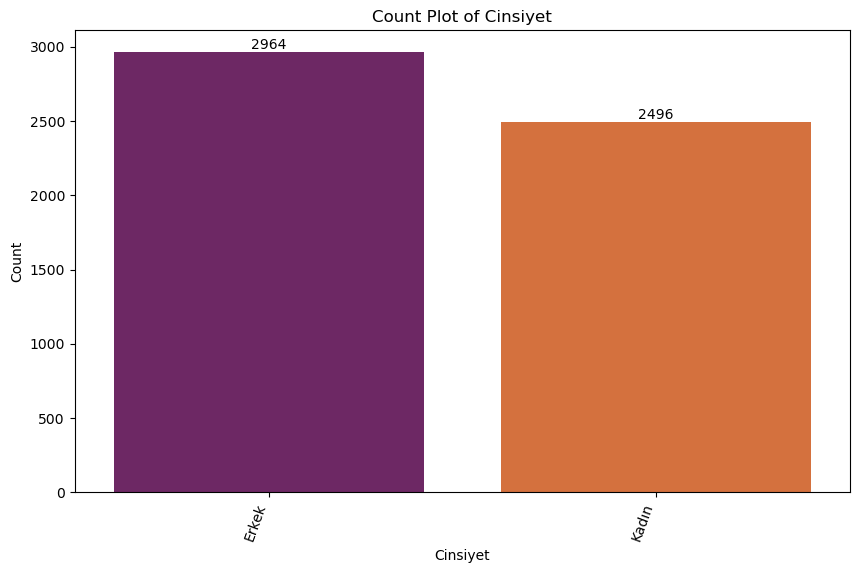

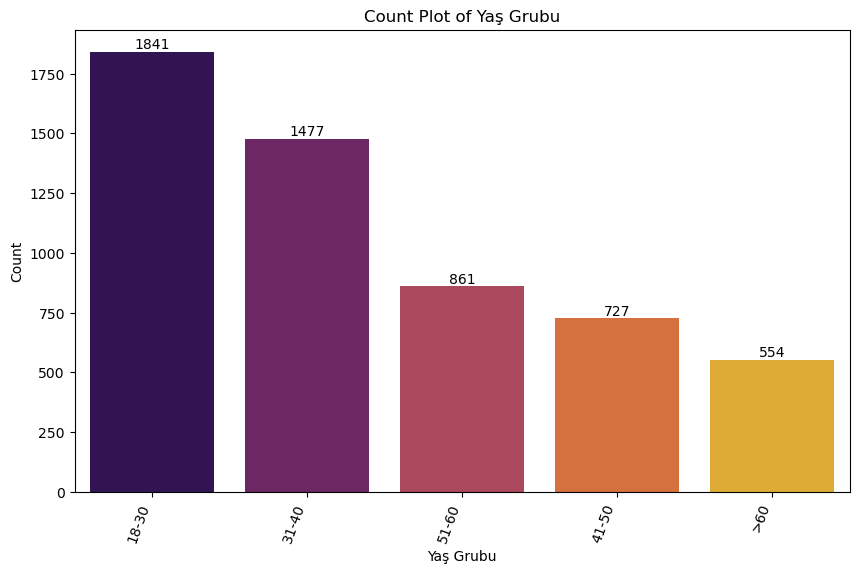

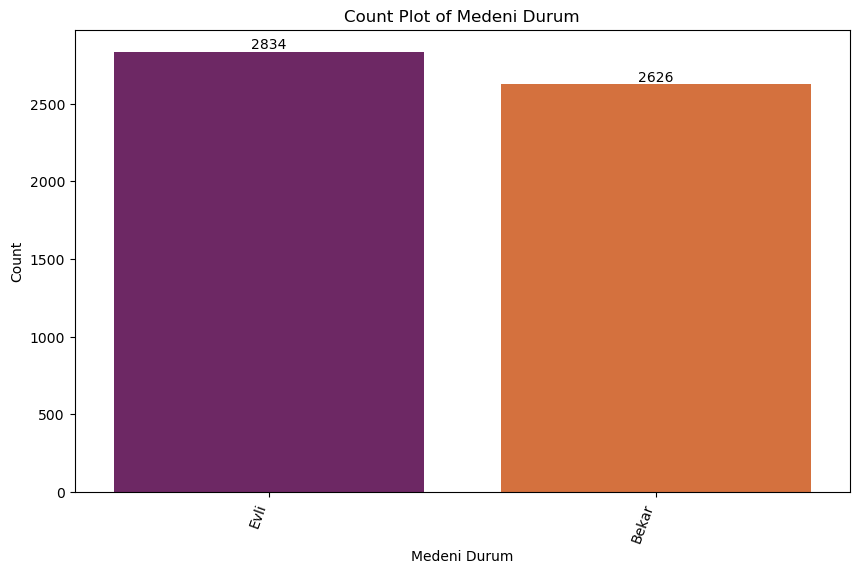

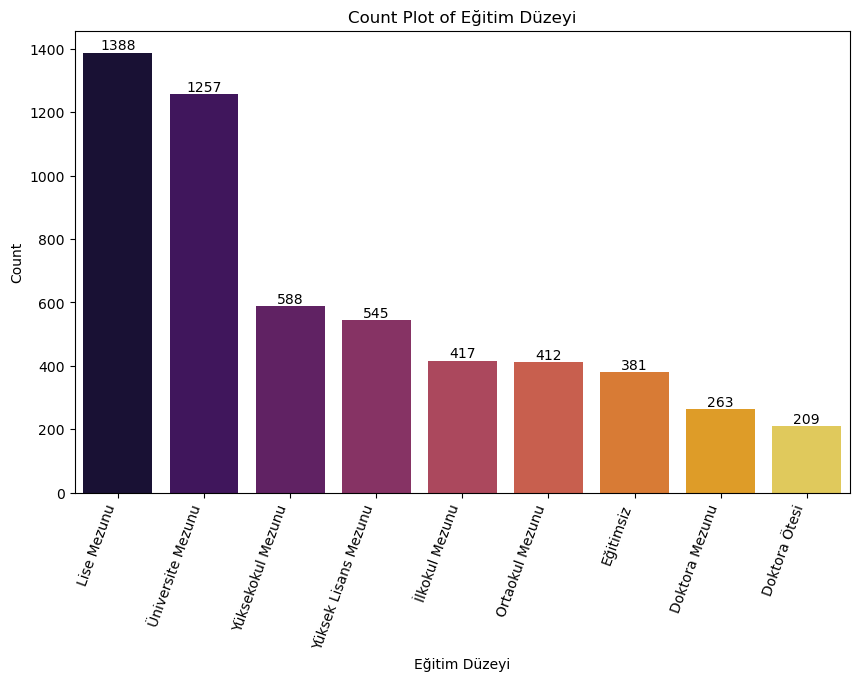

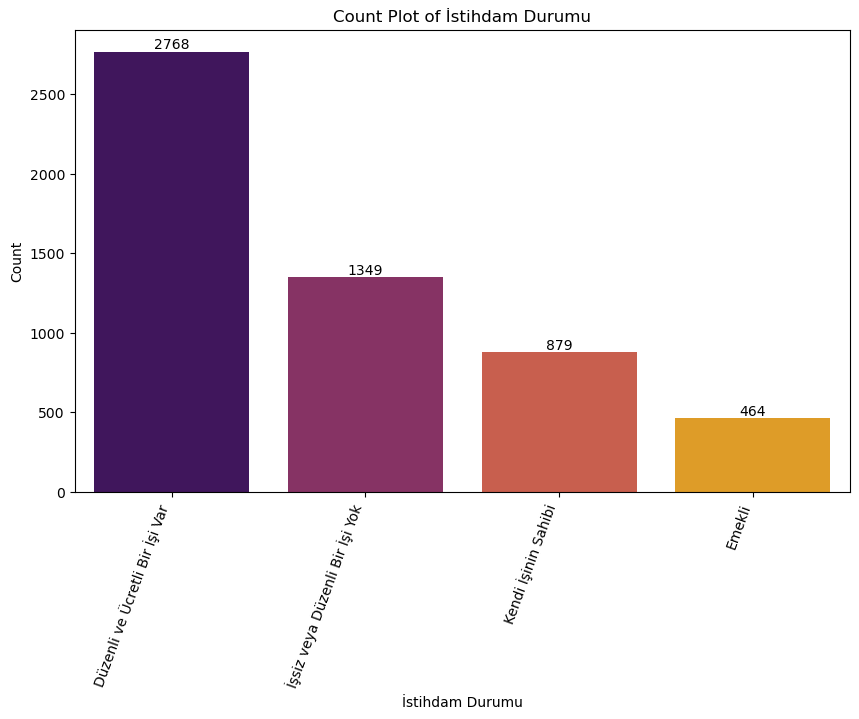

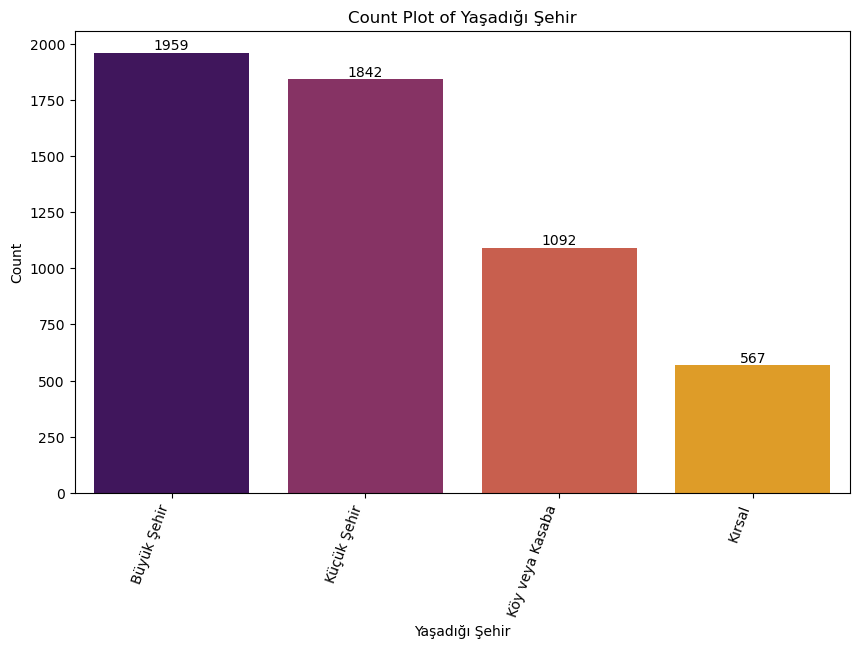

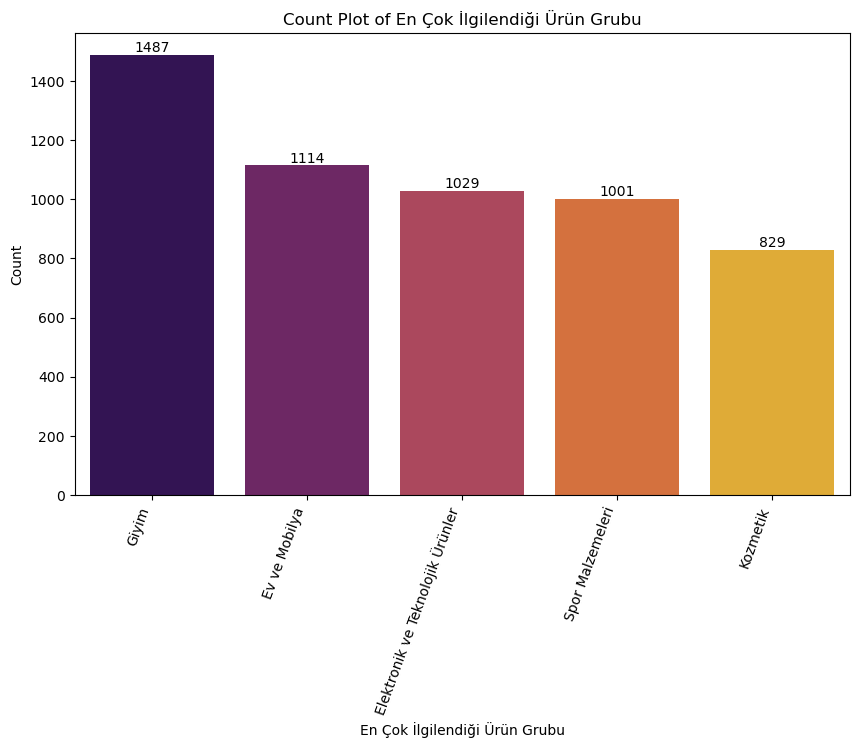

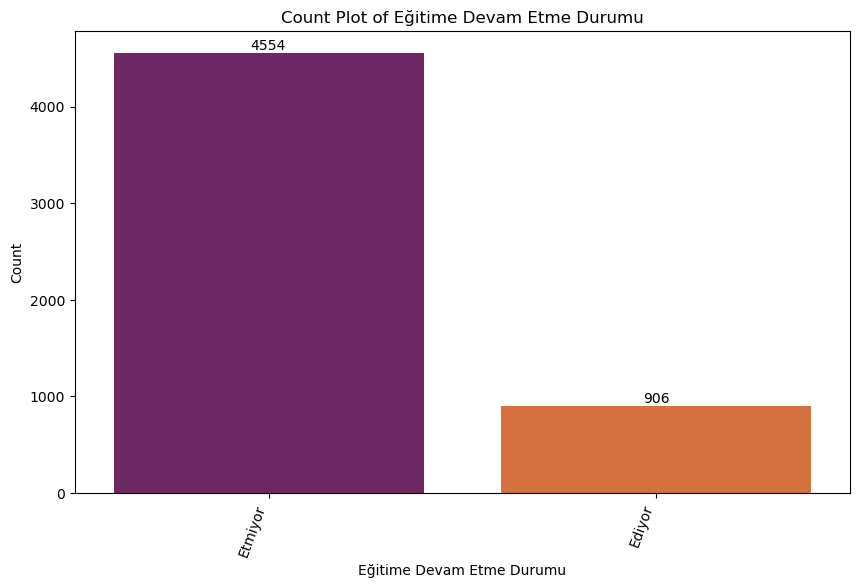

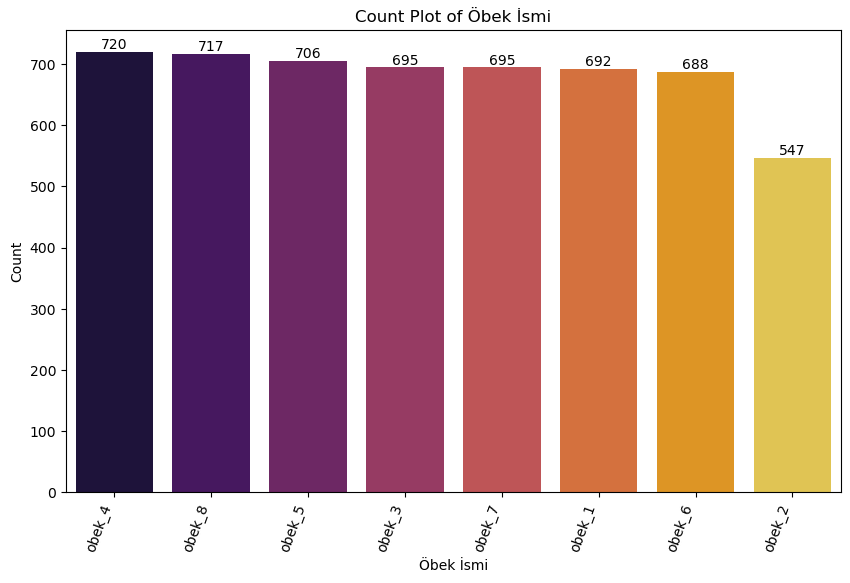

Column Name  N Unique  NaN  NaN (%) Data Type
0                       Cinsiyet         2    0     0.00    object
0                      Yaş Grubu         5    0     0.00    object
0                   Medeni Durum         2    0     0.00    object
0                  Eğitim Düzeyi         9    0     0.00    object
0                İstihdam Durumu         4    0     0.00    object
0                 Yaşadığı Şehir         4    0     0.00    object
0  En Çok İlgilendiği Ürün Grubu         5    0     0.00    object
0      Eğitime Devam Etme Durumu         2    0     0.00    object
0                      Öbek İsmi         8    0     0.00    object

In [11]:
temp = pd.DataFrame()

for col in cats:
    cat_info = categoric_summary(df, col, plot=1, rotation_degree=70)
    temp = pd.concat([temp,cat_info], axis=0)
    
temp

## Çıkarımlar 🤔

1. Müşterilerimizin demografik yapısına bakıldığında:
    1. Cinsiyet dengesi aşırı dengesiz değil.
    1. Eğitim durumu lise ve lisans ağırlıklı olmak üzere çoğunluğu nitelikli eğitim seviyesinde.
    1. Hitap ettiğimiz yaş grubu çoğunlukkla genç ve orta yaşlı insanlar.
    1. Müşterilerimizin büyük bir çoğunluğu eğitimine devam eden insanlar.
1. En çok satışı yapılan ürün Giyim kategorisidir.
1. Büyük ve küçük şehir çoğunlukta olacak şekilde kırsala dahi ürün satan bir markayız. 

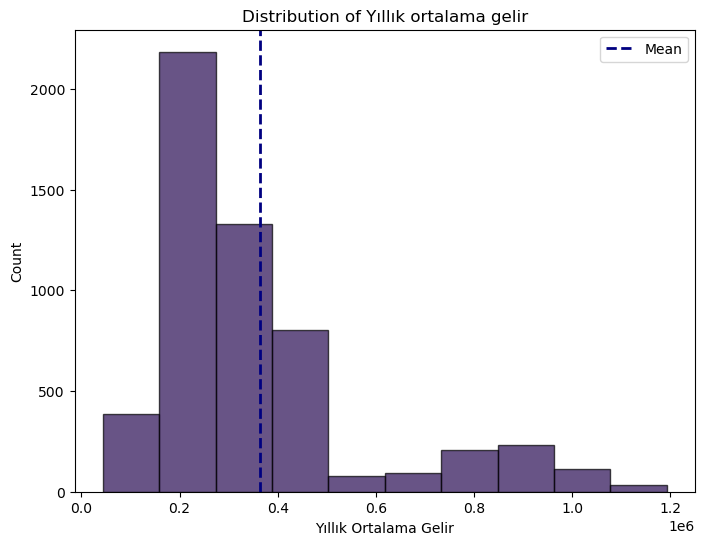

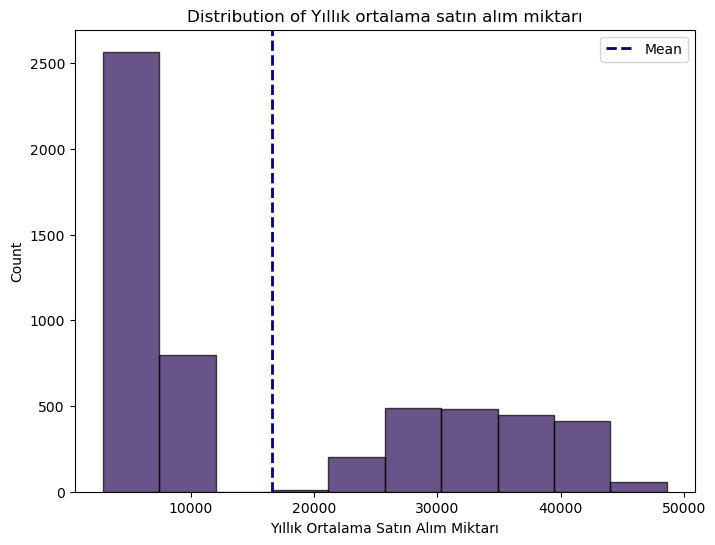

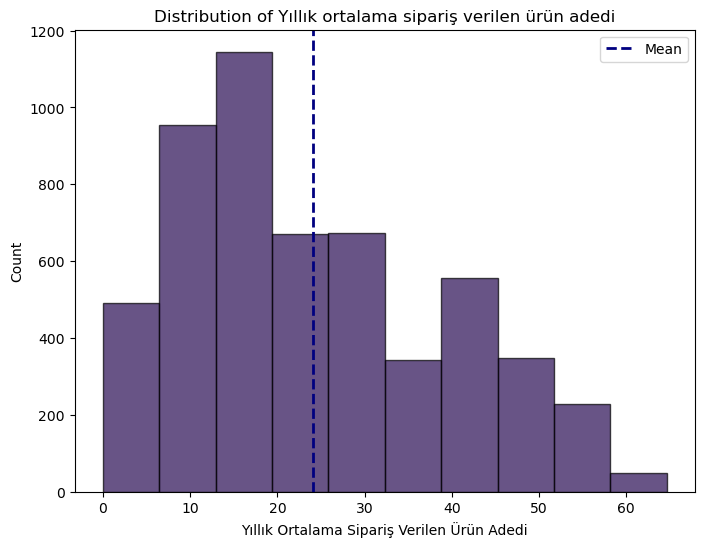

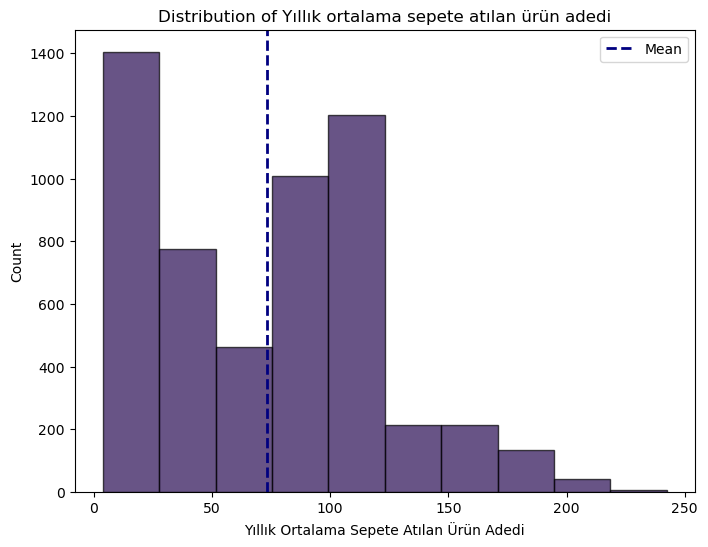

Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  \
count                5460.00                             5460.00   
mean               363571.13                            16616.61   
std                219714.44                            14099.17   
min                 43922.99                             2859.25   
25%                215693.44                             4931.86   
50%                286925.44                             8426.82   
75%                468188.22                            30579.24   
max               1192437.15                            48605.59   

       Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
count                                     5460.00   
mean                                        24.04   
std                                         14.95   
min                                          0.00   
25%                                         11.55   
50%                                         20.10   
75%                                         35.92   
max                                         64.62   

       Yıllık Ortalama Sepete Atılan Ürün Adedi  
count                                   5460.00  
mean                                      73.45  
std                                       47.21  
min                                        3.98  
25%                                       25.01  
50%                                       82.49  
75%                                      104.47  
max                                      242.31

In [12]:
temp = pd.DataFrame()

for col in nums:
    num_info = numeric_summary(df, col, plot=1)
    temp = pd.concat([temp, num_info], axis=1)
    
temp

## Çıkarımlar 🤔

1. Çok geniş bir müşteri yelpazemiz var. Yıllık ortalama geliri çok yüksek ve onlara göre çok düşük olan müşterilere sahibiz. Bu durum öbek türlerinde büyük bir etkiye sahip olabilir.
1. Yıllık ortalama satın alım miktarı ise yine aynı şekilde simetrik bir dağılım göstermiyor. Perakende alım yapan müşterilerin varlığından şüphelenilebilir.
1. Yıllık ortalama sipariş verile ürün adedinin histogram grafiği Chi-Square dağılımına benziyor. Bu demektir ki düşük adetlerde daha fazla alım yapılıyor. MÜşterilerimiz düşük adetlerde ürün satın alıyor.
1. Yıllık ortalama sepete atılan ürün adedine bakıldığında ise öyle müşterilerimiz var ki gerçekten çok çeşitlilikte ürünler satın alırken, bazı müşterilerimiz ise sadece belirli ürünleri alıyorlar.

# İlişkisel Veri Analizi

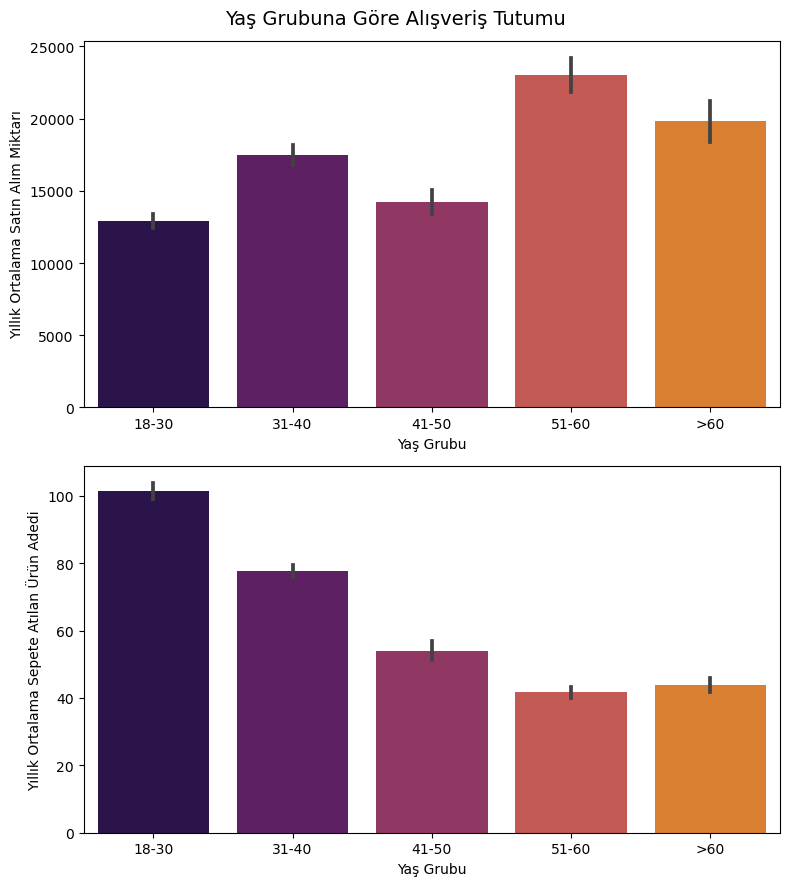

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,9))

sns.barplot(
    x='Yaş Grubu',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df,
    order = ["18-30", "31-40", "41-50", "51-60", ">60"],
    ax=ax[0]
)

sns.barplot(
    x='Yaş Grubu',
    y="Yıllık Ortalama Sepete Atılan Ürün Adedi",
    data=df,
    order = ["18-30", "31-40", "41-50", "51-60", ">60"],
    ax=ax[1]
)

fig.suptitle('Yaş Grubuna Göre Alışveriş Tutumu', fontsize=14)
fig.tight_layout()
plt.show()

* Genç nüfus yıllık ortalama olarak sepetine çok fazla ürün atıyor ancak yaptığı yıllık ortalam satın alım miktarı çok düşük kalıyor. Ya çok kararsız bir genç nüfus var ya da ekonomik şartlardan dolayı sepetlerindeki her ürünü alamıyorlar.

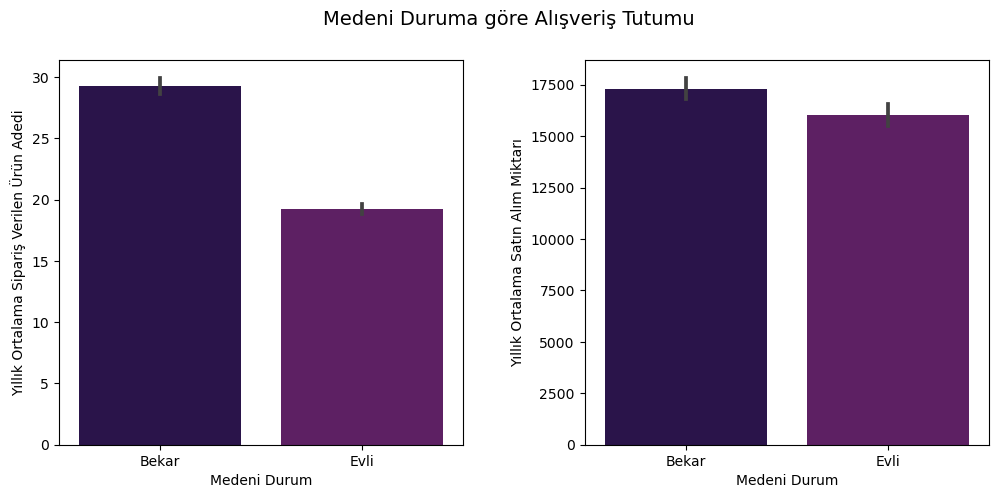

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.barplot(
    x='Medeni Durum',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    data=df,
    ax=ax[0]
)

sns.barplot(
    x='Medeni Durum',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df,
    ax=ax[1]
)

fig.suptitle('Medeni Duruma göre Alışveriş Tutumu', fontsize=14)

plt.subplots_adjust(wspace=0.3)
plt.show()

* Bekarlar evlilerden daha fazla sayıda ve tutarda ürün alıyorlar. Evli ve bekar müşteri sayımızın hemen hemen eşit olduğunu varsayarsak bekarlar daha gözde müşterilerimiz diyebiliriz.

In [15]:
df['Eğitim Düzeyi'].unique()

array(['Yüksek Lisans Mezunu', 'Lise Mezunu', 'Ortaokul Mezunu',
       'Yüksekokul Mezunu', 'Üniversite Mezunu', 'Doktora Mezunu',
       'İlkokul Mezunu', 'Doktora Ötesi', 'Eğitimsiz'], dtype=object)

In [16]:
edu_map = {
    "Eğitimsiz":0,
    "İlkokul Mezunu":1,
    "Ortaokul Mezunu":2,
    "Lise Mezunu": 3,
    "Yüksekokul Mezunu":4,
    "Üniversite Mezunu":5,
    'Yüksek Lisans Mezunu':6,
    "Doktora Mezunu":7,
    "Doktora Ötesi":8
}

df["Encoded Eğitim Düzeyi"] = df.loc[:,"Eğitim Düzeyi"].map(edu_map)
df.head(3)

index Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi  \
0      0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu   
1      1    Erkek       >60         Evli           Lise Mezunu   
2      2    Erkek     18-30        Bekar           Lise Mezunu   

                  İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir  \
0  Düzenli ve Ücretli Bir İşi Var              748266.44    Büyük Şehir   
1             Kendi İşinin Sahibi              246298.61    Küçük Şehir   
2  Düzenli ve Ücretli Bir İşi Var              268582.73    Küçük Şehir   

      En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  \
0  Elektronik ve Teknolojik Ürünler                            32010.90   
1                  Spor Malzemeleri                             4145.73   
2                             Giyim                             9924.38   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu  \
0                                       37.31                   Etmiyor   
1                                       11.55                   Etmiyor   
2                                       55.35                    Ediyor   

  Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi  Encoded Eğitim Düzeyi  
0    obek_4                                    102.94                      6  
1    obek_5                                     82.18                      3  
2    obek_8                                    141.66                      3

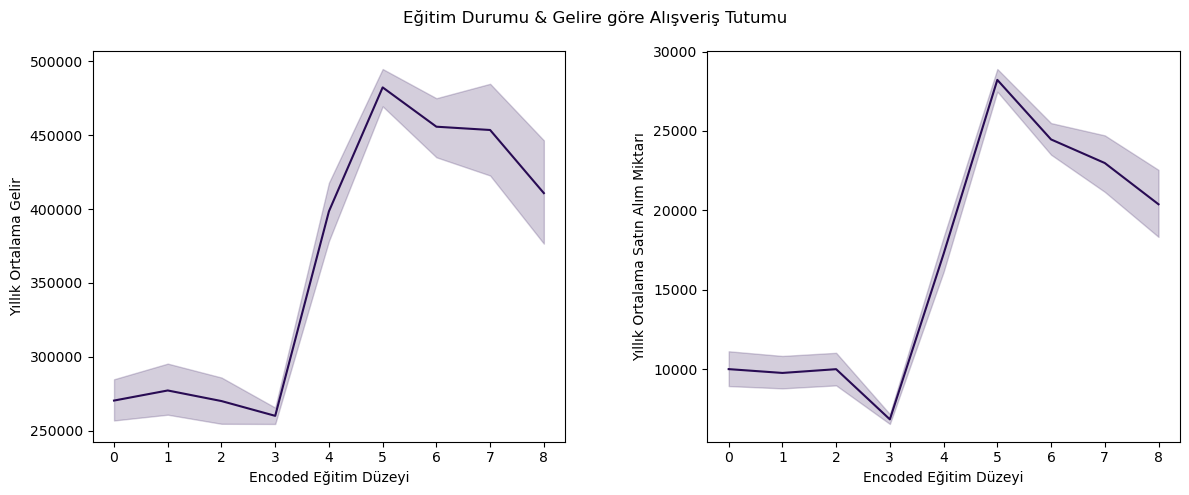

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.lineplot(
    x='Encoded Eğitim Düzeyi',
    y='Yıllık Ortalama Gelir',
    data=df,
    palette='inferno',
    ax=ax[0]
)

sns.lineplot(
    x='Encoded Eğitim Düzeyi',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df,
    palette='inferno',
    ax=ax[1]
)

fig.suptitle("Eğitim Durumu & Gelire göre Alışveriş Tutumu")
fig.tight_layout()

plt.subplots_adjust(wspace=0.3)
plt.show()

* Satın alma düzeyi yıllık ortalama gelir düzeyi ile çok yüksek derecede doğru orantılı. Eğitim düzeyine göre gelirlerin olduğu görüldüğüne göre, müşterilerimizin eğitim düzeyi onları sınıflandırırken büyük rol oynayacak demektir.

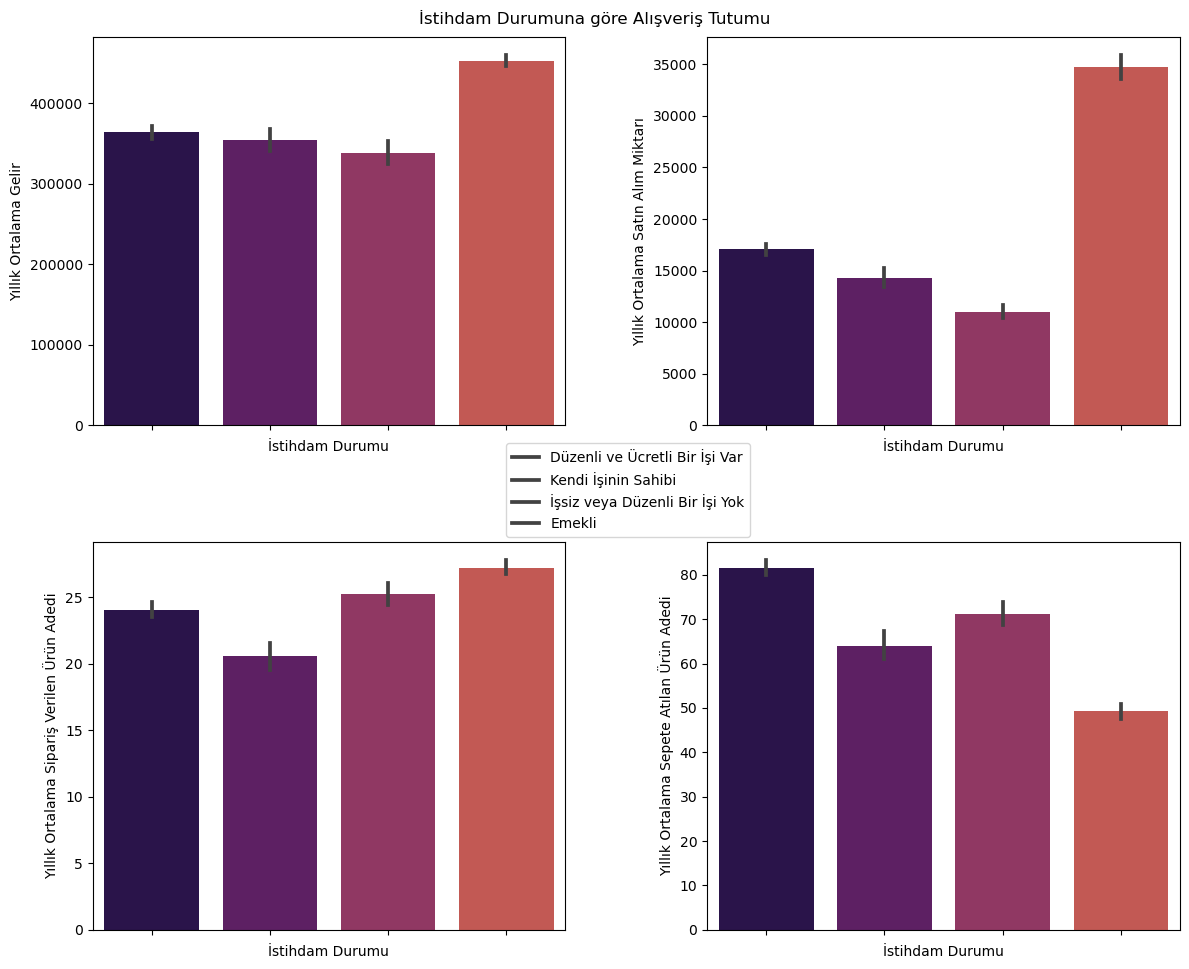

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

sns.barplot(
    x='İstihdam Durumu',
    y='Yıllık Ortalama Gelir',
    data=df,
    ax=ax[0][0]
)

sns.barplot(
    x='İstihdam Durumu',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df,
    ax=ax[0][1]
)

sns.barplot(
    x='İstihdam Durumu',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    data=df,
    ax=ax[1][0]
)

sns.barplot(
    x='İstihdam Durumu',
    y='Yıllık Ortalama Sepete Atılan Ürün Adedi',
    data=df,
    ax=ax[1][1]
)

fig.suptitle("İstihdam Durumuna göre Alışveriş Tutumu")
fig.tight_layout()

for axes in ax.flatten():
    #axes.set_xticklabels(axes.get_xticklabels(), rotation=60)
    axes.set_xticklabels([])
    
legend_labels = df['İstihdam Durumu'].unique()
fig.legend(legend_labels, loc='center left', bbox_to_anchor=(0.42, 0.5))

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

* Yıllık ortalama geliri en yüksek olan müşteri profilimiz emekli olan müşterilerimiz. 
* Yine aynı şekilde yıllık ortalama satın alım miktarı en yüksek olan müşterilerimiz ise emekliler.
* Müşterilerimizin arasında emeklilerin sayısı az olmasına karşın en yüksek alımı onlar yapmaktadır.
* Emekli müşterilerimiz nitelikli, eğitim düzeyi yüksek müşteriler olabilir.

In [19]:
grouped_data = df.groupby(['İstihdam Durumu', 'Yaş Grubu']).size().reset_index(name='Sayısı')

temp = grouped_data.pivot(
    index='İstihdam Durumu',
    columns='Yaş Grubu',
    values='Sayısı'
)

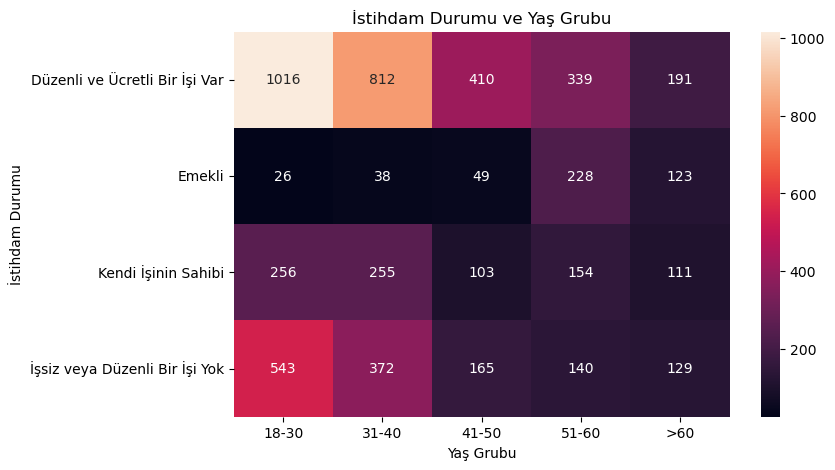

In [20]:
plt.figure(figsize=(8, 5))

sns.heatmap(temp, annot=True, fmt='g')

plt.title('İstihdam Durumu ve Yaş Grubu')
plt.show()

* Genelde yaşa göre emeklilik ilişkilerinde beklenen *>60* yaşındaki kişilerin emekli olması gerektiğidir. Ancak görüyoruz ki daha düşük yaşlarda emekli insanlar var. Ya bu kısımda verilerde bir hata var ya da bu kişileri parası fazla nitelikli insanlar olarak kabul edebiliriz.(yatırım yaparak kendini emekli kabul etmiş insanlar)
* Emekli müşteri grubumuz, yıllık geliri en yüksek olan müşteri profili olduğu için ikinci varsayımımız daha ağır basmaktadır.

In [21]:
df.loc[df['İstihdam Durumu']=='Emekli','Yaşadığı Şehir'].value_counts()

Köy veya Kasaba    199
Kırsal             126
Küçük Şehir         89
Büyük Şehir         50
Name: Yaşadığı Şehir, dtype: int64

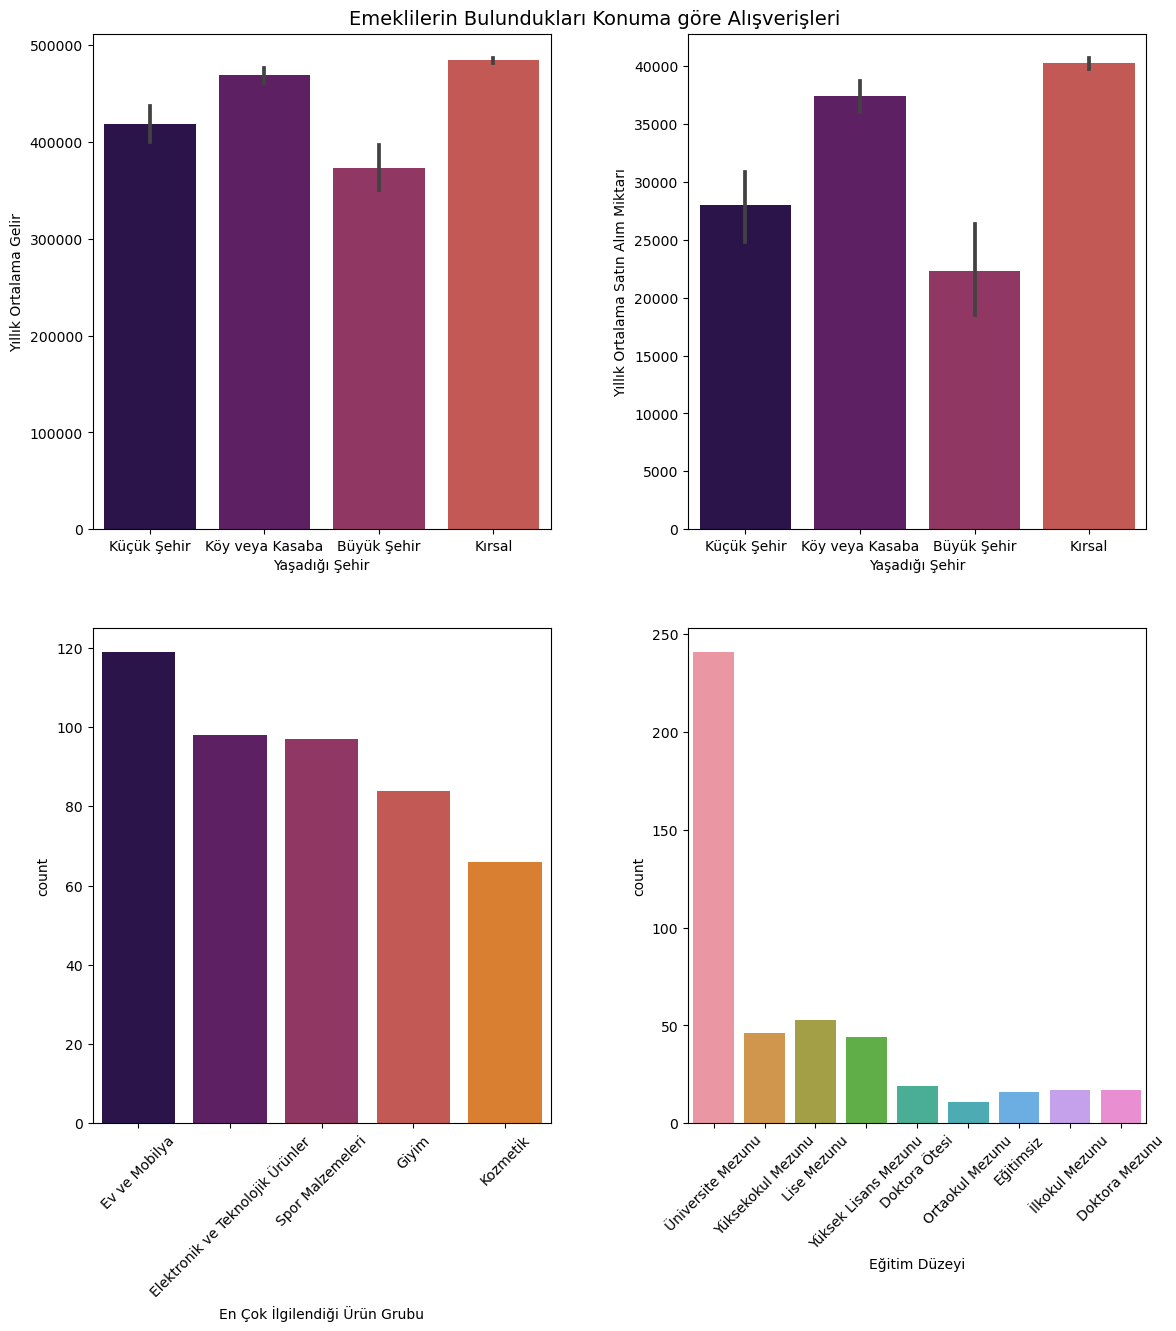

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

sns.barplot(
    x='Yaşadığı Şehir',
    y='Yıllık Ortalama Gelir',
    data=df.loc[df['İstihdam Durumu']=='Emekli',:],
    ax=ax[0][0]
)

sns.barplot(
    x='Yaşadığı Şehir',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df.loc[df['İstihdam Durumu']=='Emekli',:],
    ax=ax[0][1]
)

sns.countplot(
    x='Eğitim Düzeyi',
    data=df.loc[df['İstihdam Durumu']=='Emekli',:],
    ax=ax[1][1]
)

sns.countplot(
    x='En Çok İlgilendiği Ürün Grubu',
    data=df.loc[df['İstihdam Durumu']=='Emekli',:],
    ax=ax[1][0],
    order = df.loc[df['İstihdam Durumu']=='Emekli',:]['En Çok İlgilendiği Ürün Grubu'].value_counts(ascending=0).index.tolist()
)

fig.suptitle("Emeklilerin Bulundukları Konuma göre Alışverişleri", fontsize=14)
fig.tight_layout()

ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=45)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=45)

plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()

* Bizim zengin emekli müşterilerimiz kırsal, köy veya kasabada yaşamakta ve en çok ev-mobilya ürünleri satın almaktalar.
* Emekli müşterilerimizin çok büyük bir çoğunluğu da üniversite mezunu olmakla birlikte yüksek bir çoğunluğu da yine nitelikli bir şekilde eğitim almış diyebiliriz.
* Kırsal ve köylerdeki emekli müşterilerimiz çok fazla sayıda ürün satın alıyorlar. Neler dönüyor arkaplanda bilemiyorum ancak değerli müşterilerimizden bir grupta kırsal ve köyde yaşayan emekli müşterilerimiz. Selam olsun onlara :)

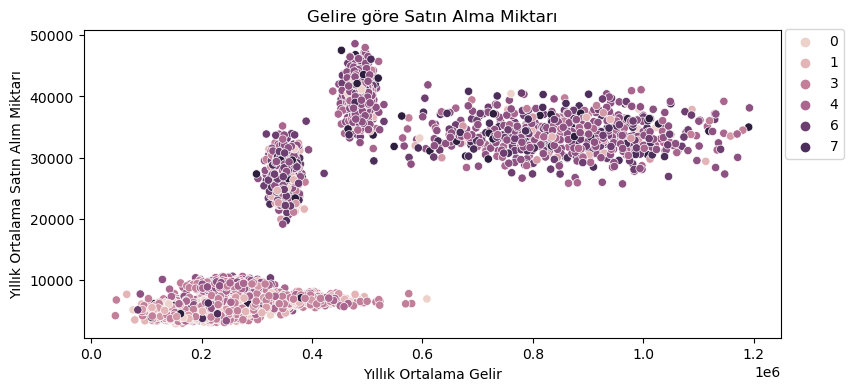

In [23]:
plt.figure(figsize=(9,4))

sns.scatterplot(
    x='Yıllık Ortalama Gelir',
    y='Yıllık Ortalama Satın Alım Miktarı',
    data=df,
    hue='Encoded Eğitim Düzeyi'
)

plt.title("Gelire göre Satın Alma Miktarı")
plt.legend(bbox_to_anchor=(1.1, 1.025))
plt.show()

* Kabaca söylenebilir ki gelir arttıkça alım miktarı da artıyor. Ek olarka saçılım grafiğinden 4 farklı müşteri grubu olduğu net bir şekilde görülebiliyor.

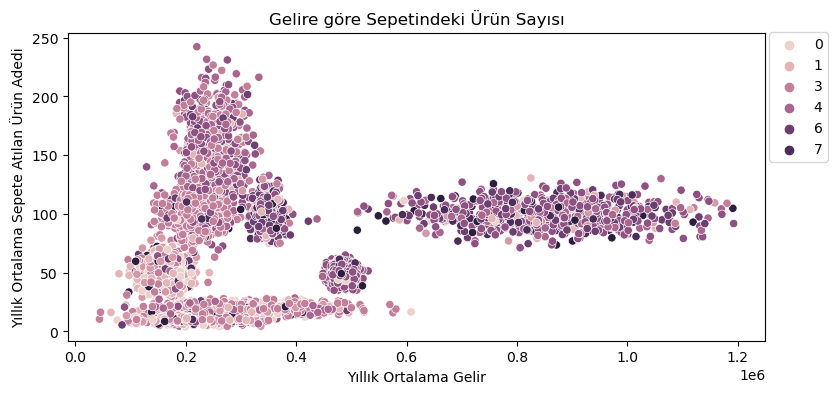

In [24]:
plt.figure(figsize=(9,4))

sns.scatterplot(
    x='Yıllık Ortalama Gelir',
    y='Yıllık Ortalama Sepete Atılan Ürün Adedi',
    data=df,
    hue='Encoded Eğitim Düzeyi'
)

plt.title("Gelire göre Sepetindeki Ürün Sayısı")
plt.legend(bbox_to_anchor=(1.1, 1.025))
plt.show()

* Bu kısımda verilerin rastgele dağılmadığını ancak doğrusal bir ilişki de olmadığını söyleyebiliriz.

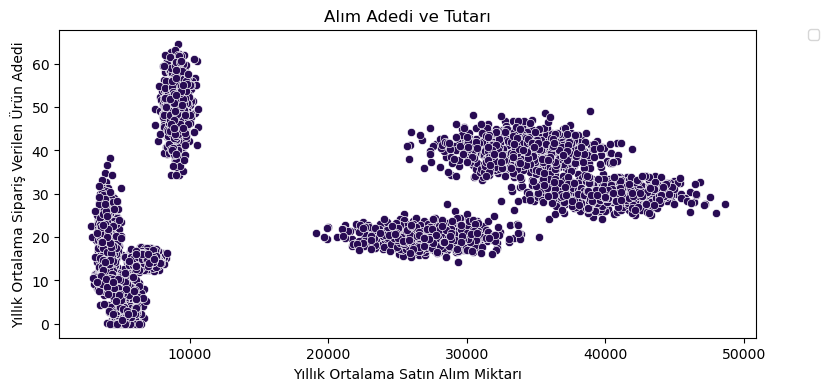

In [25]:
plt.figure(figsize=(9,4))

sns.scatterplot(
    x='Yıllık Ortalama Satın Alım Miktarı',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    data=df,
)

plt.title("Alım Adedi ve Tutarı")
plt.legend(bbox_to_anchor=(1.1, 1.025))
plt.show()

* Bazı müşteriler çok çeşitte az tutarda alışveriş yaparken, bazı müşteriler ise az sayıda ancak yüksek tutarlarda alışveriş yapmaktadır.

# Kümeleme Analizi 

In [26]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
from sklearn.cluster import KMeans

In [27]:
temp = df.loc[:,nums]
temp.head()

Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  \
0              748266.44                            32010.90   
1              246298.61                             4145.73   
2              268582.73                             9924.38   
3              327721.84                             6417.78   
4              397431.63                             7886.66   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                       37.31   
1                                       11.55   
2                                       55.35   
3                                       15.42   
4                                       14.69   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  
0                                    102.94  
1                                     82.18  
2                                    141.66  
3                                     17.10  
4                                     20.47

In [28]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(temp)

## Hiyerarşik Kümeleme

In [29]:
linkage_matrix = linkage(scaled_data, method='ward', metric='euclidean')

⭐ Hiyerarşik kümelemede bağlantı yöntemini belirlerken **ward** seçeneğini seçmemin sebebpleri:
1. Küme içi varyansın artışını minimize ederek birleştirme yapar. Bu bizim daha homojen ve dengeli kümelere sahip olmamızı sağlar.
1. Varyans artışını minimize ederek bağlantı yapılması, birbirine daha çok benzer kümeler oluşturur.
1. Eğer küme içi varyans düşükse, aynı kümeye ait veri noktaları birbirine yakın ve benzer özelliklere sahiptir. 

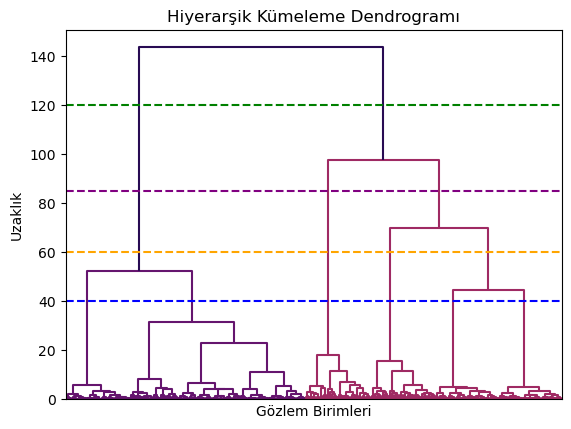

In [30]:
dendrogram(linkage_matrix, no_labels=True)

plt.title('Hiyerarşik Kümeleme Dendrogramı')
plt.xlabel('Gözlem Birimleri')
plt.ylabel('Uzaklık')

plt.axhline(40, color='blue', linestyle='--')
plt.axhline(60, color='orange', linestyle='--')
plt.axhline(85, color='purple', linestyle='--')
plt.axhline(120, color='green', linestyle='--')

plt.grid(False)
plt.show()

## 3D Görselleştirme ile İnceleme

In [31]:
def get_3d(df, scaled_data, cluster_number, affinity_method='euclidean', linkage_method='ward'):
    '''"get_3d" işlevi bir veri çerçevesini, ölçeklendirilmiş verileri, küme numarasını, benzeşim yöntemini
    ve bağlantı yöntemini alır ve her nokta kümeye göre renklendirilmiş olarak verilerin 3 boyutlu
    dağılım grafiğini döndürür.
    
    Parameters
    ----------
    df
        Kümeleme için verileri içeren giriş veri çerçevesi.
    scaled_data
        Scaled_data parametresi, ölçeklendirilmiş veya normalleştirilmiş giriş verileridir. Genellikle
    kümeleme için kullanılan özellikleri veya değişkenleri içeren bir numpy dizisi veya pandas
    DataFrame'dir.
    cluster_number
        Hiyerarşik kümeleme algoritmasında oluşturmak istediğiniz küme sayısı.
    affinity_method, optional
        Afinite yöntemi, veri noktaları arasındaki benzerliği ölçmek için kullanılır. Kümeleme
    algoritmasında kullanılacak mesafe ölçüsünü belirler. Varsayılan değer, veri noktaları arasındaki
    Öklid mesafesini hesaplayan 'öklit'tir. Diğer seçenekler arasında 'manhattan', 'kosinüs' ve 'önceden
    hesaplanmış' yer alır.
    linkage_method, optional
        linkage_method parametresi, hiyerarşik kümeleme işlemi sırasında kümeler arasındaki mesafeyi
    hesaplamak için kullanılan yöntemi belirler. Mevcut seçenekler şunlardır:
    
    '''
    hierarchical_cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity=affinity_method, linkage=linkage_method)
    
    temp = df.loc[:,nums]
    temp['Küme'] = hierarchical_cluster.fit_predict(scaled_data)

    fig = px.scatter_3d(
        temp,
        x='Yıllık Ortalama Satın Alım Miktarı',
        y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
        z='Yıllık Ortalama Gelir',
        color='Küme'
    )

    fig.show()

**Küme Sayısı: 2**

In [32]:
get_3d(df, scaled_data, 2)

**Küme Sayısı: 3**

In [33]:
get_3d(df, scaled_data, 3)

**Küme Sayısı: 4**

In [34]:
get_3d(df,scaled_data,4)

## Elbow Yöntemi

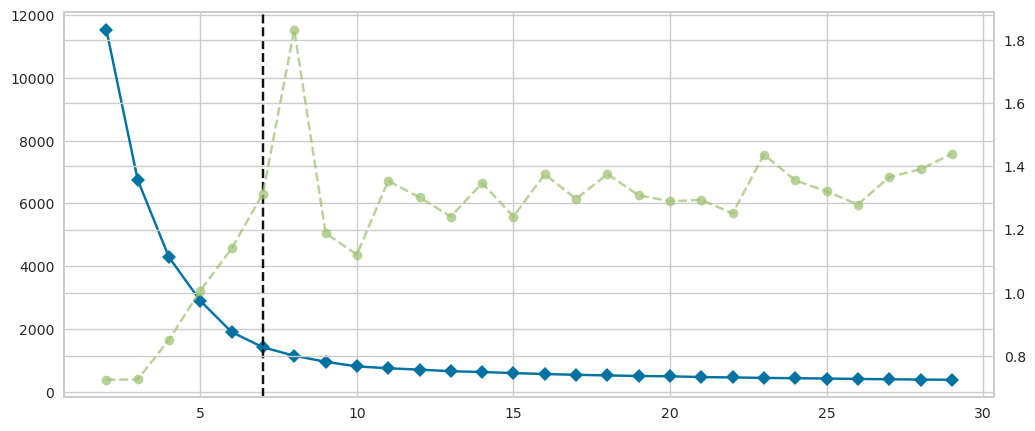

In [35]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()

plt.figure(figsize=(12,5))

visualizer = KElbowVisualizer(kmeans, k=(2,30))
visualizer.fit(scaled_data)

plt.show()

## Çıkarımlar 🤔

1. Hiyerarşik kümeleme sonucunda küme sayısı 2-3-4-6 olarak bulundu.
2. 3D Görselleştirme sonucunda ise küme sayısı 4 olarak bulundu.
3. K-Means ile yapılan kümeleme sonucunda ise elbow yöntemine göre 7 olarak bulundu.

**Sonuç:** Kümeleme analizi sonucunda en iyi küme sayısı tahmin algoritma performansında değerlendirilmek üzere 3,4 ya da 5 olarak belirlendi. 

---

# Hedef Değişken (Öbek İsmi) Analizi

In [36]:
df = pd.read_csv('/kaggle/input/datathon2023/train.csv')

In [37]:
import plotly.express as px

fig = px.scatter_3d(
    df,
    x='Yıllık Ortalama Satın Alım Miktarı',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    z='Yıllık Ortalama Sepete Atılan Ürün Adedi',
    size='Yıllık Ortalama Gelir',
    color= 'Öbek İsmi'
)

fig.show()

In [38]:
def obek_analizi(df, obek_ismi):
    ''''Obek_analizi' işlevi girdi olarak bir veri çerçevesi ve bir nesne adı alır ve ardından söz konusu
    belirli nesne için veri çerçevesinin kategorik sütunları üzerinde analiz gerçekleştirir.
    
    Parameters
    ----------
    df
        "Df" parametresi, analiz etmek istediğiniz verileri içeren bir pandas DataFrame'dir.
    obek_ismi
        "obek_ismi" parametresi analiz etmek istediğiniz kümenin veya grubun adıdır. Veri çerçevesini
    filtrelemek ve yalnızca söz konusu kümeye ait satırları dikkate almak için kullanılır.
    
    '''
    nums = find_numerics(df)
    cats = find_categorics(df)
    
    cats.remove('Öbek İsmi')
    nums.remove('index')
    
    temp = df[df['Öbek İsmi']==obek_ismi]
    
    print(f"######################### {obek_ismi} #########################")
    for col in cats:
        categoric_summary(temp, col, plot=1, rotation_degree=70)

In [39]:
obek_means = {}

for obek in df['Öbek İsmi'].sort_values(ascending=True).unique():
    mean_data = df[df['Öbek İsmi']==obek].drop(['index'], axis=1).describe().T['mean']
    obek_means[obek] = mean_data

obek_df = pd.DataFrame(obek_means)
obek_df['Genel Ortalama'] = df[nums].describe().T['mean']

######################### obek_1 #########################


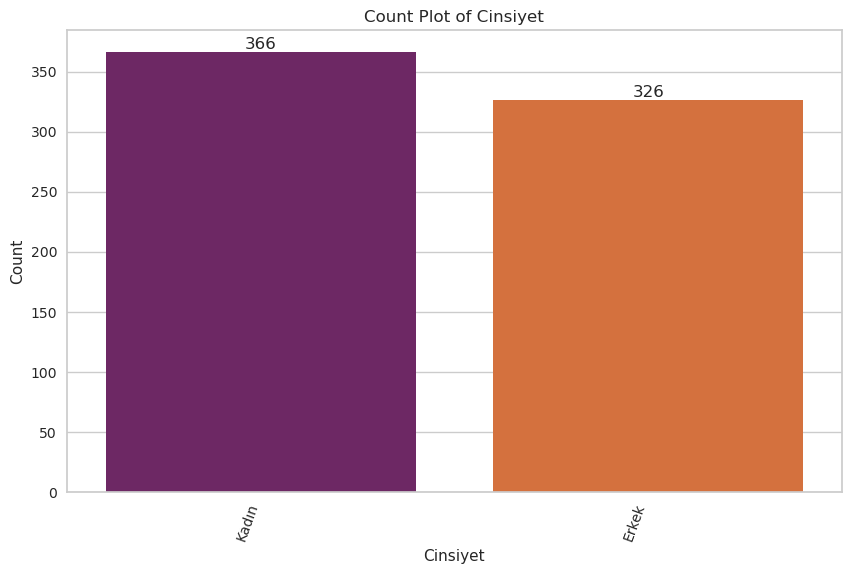

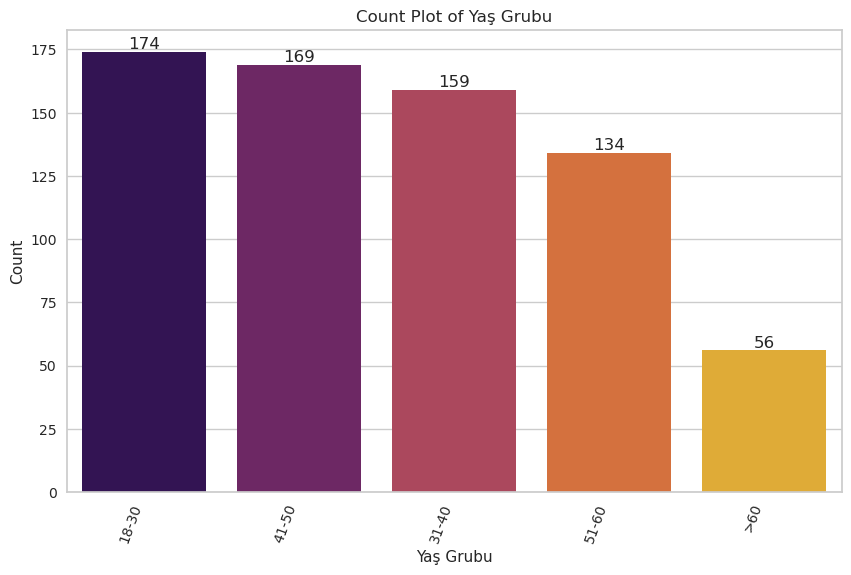

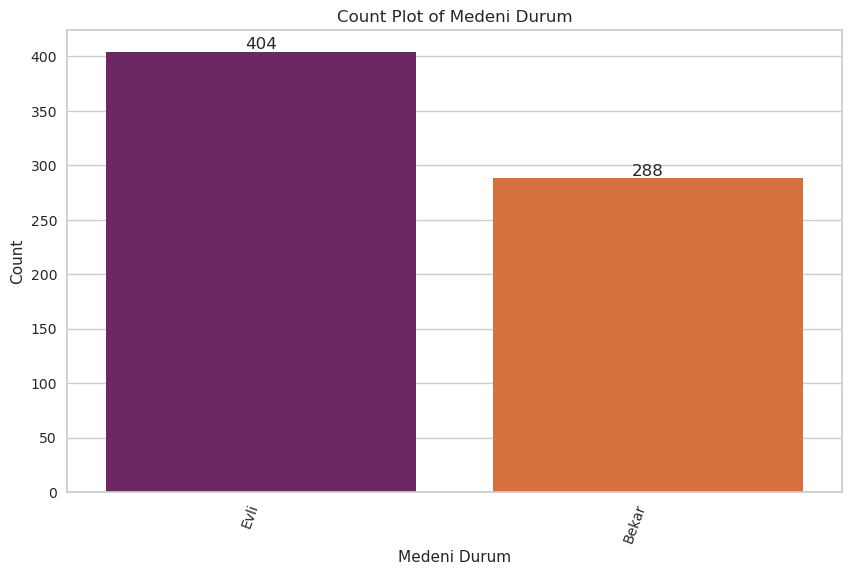

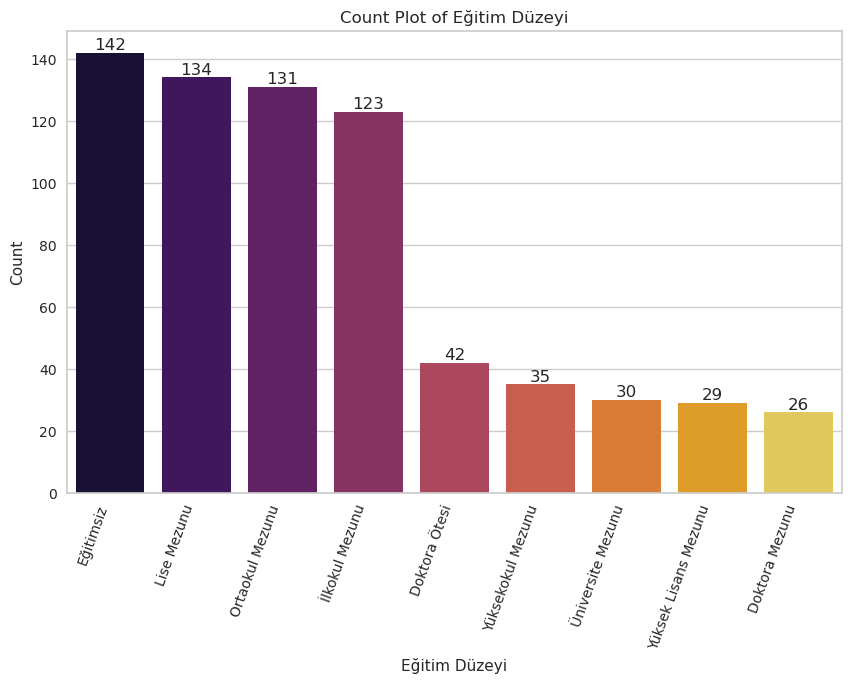

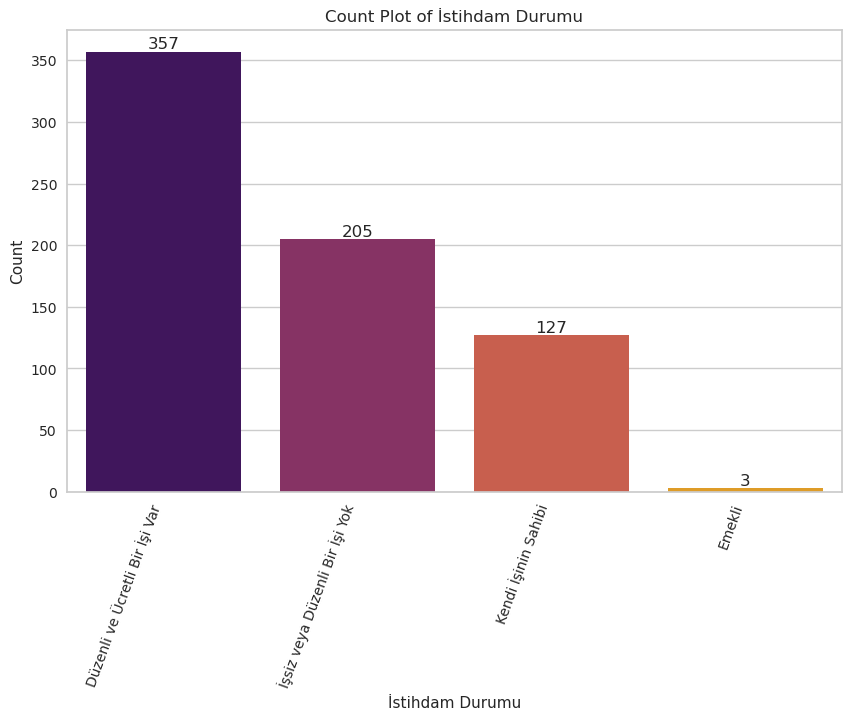

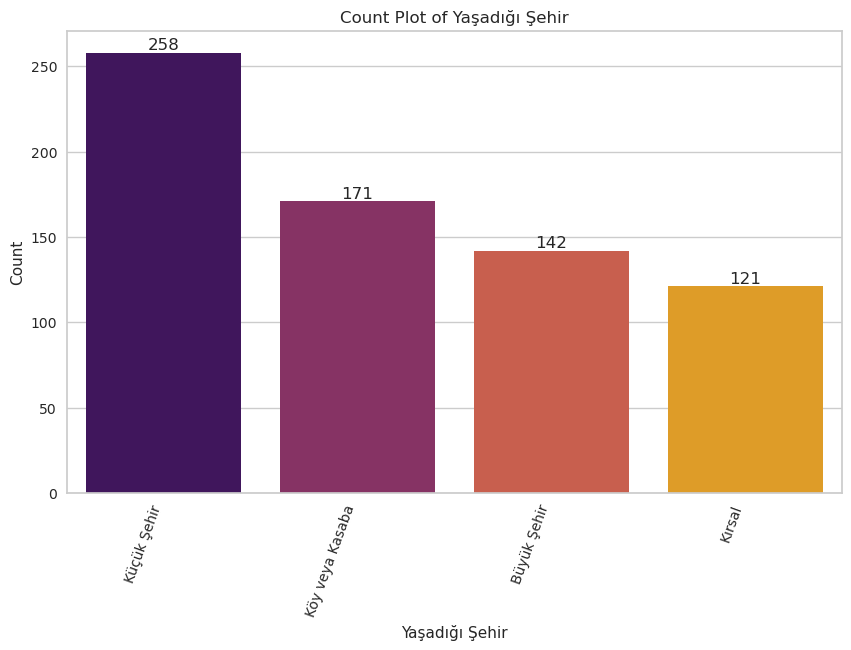

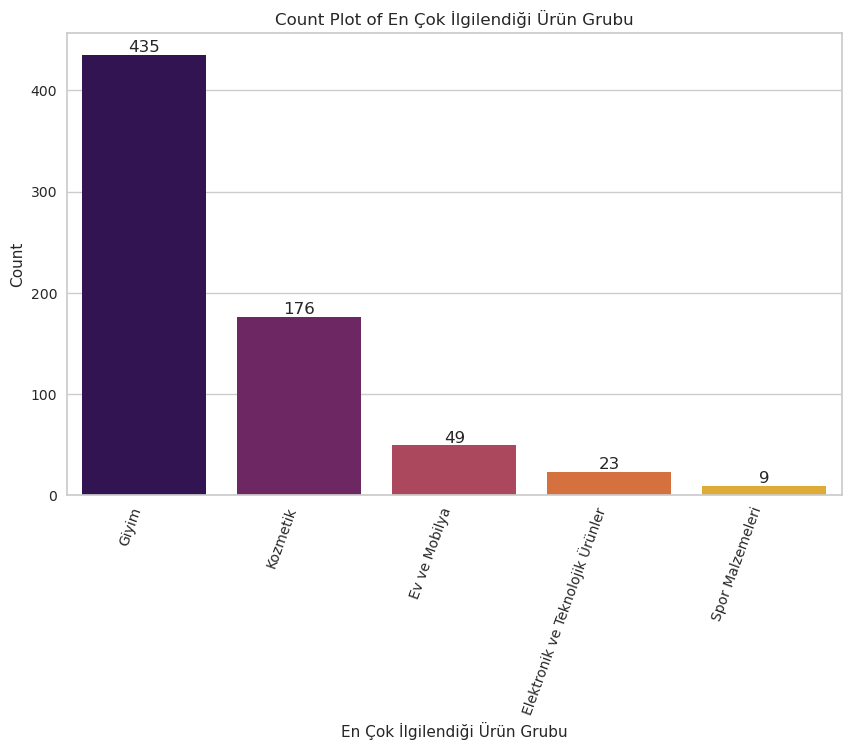

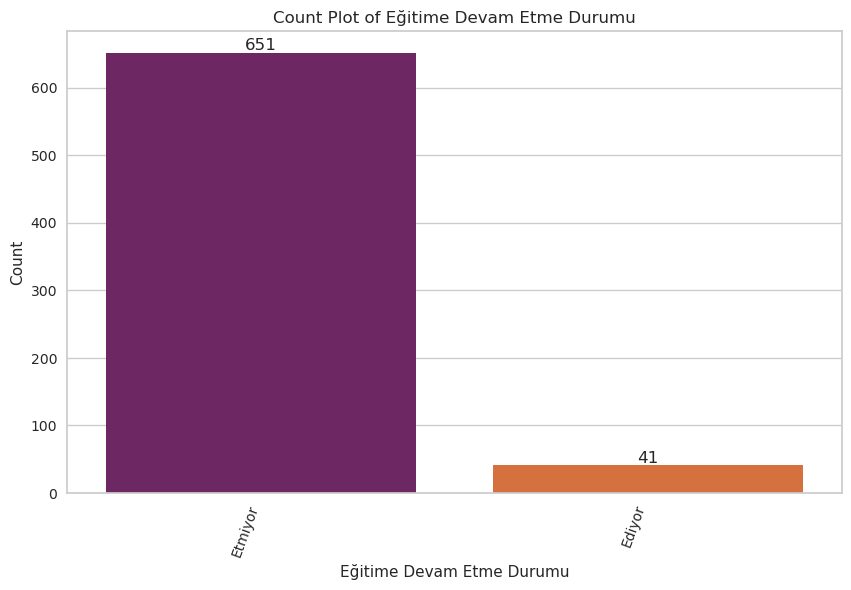

In [40]:
obek_analizi(df, 'obek_1')

######################### obek_2 #########################


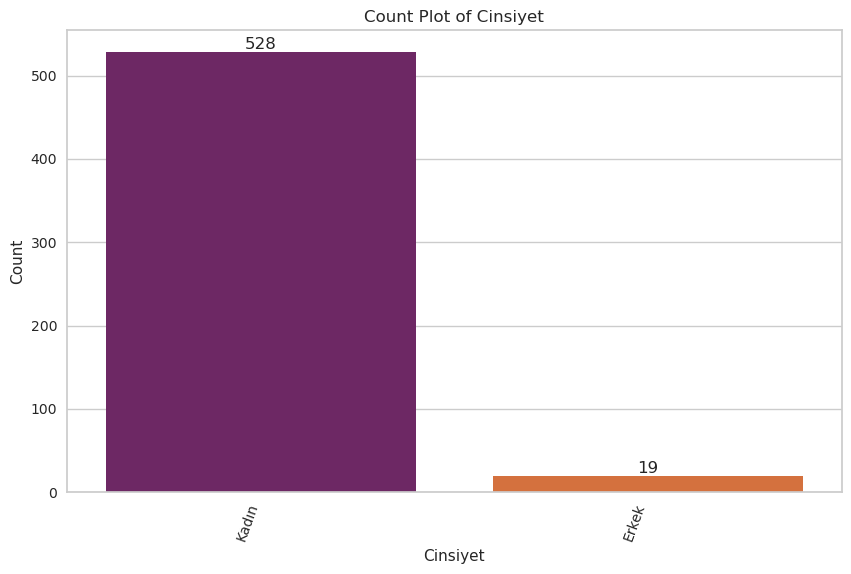

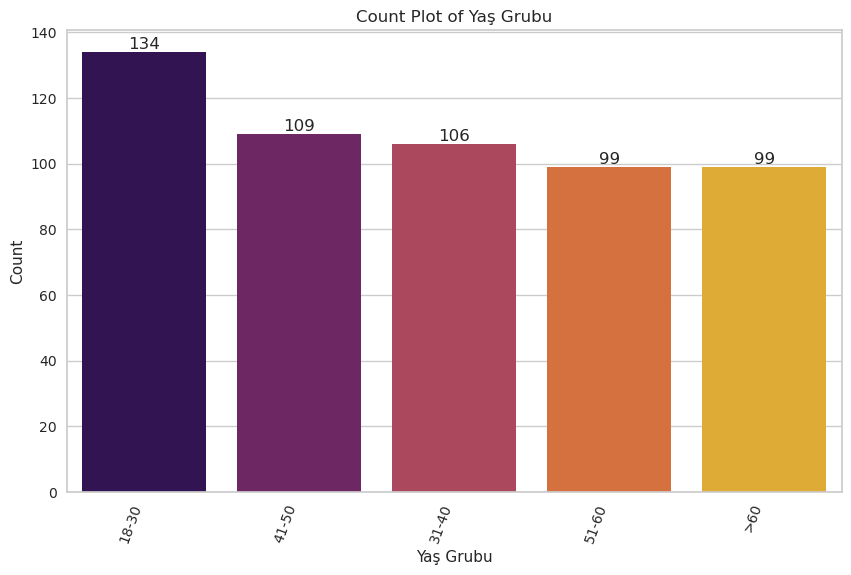

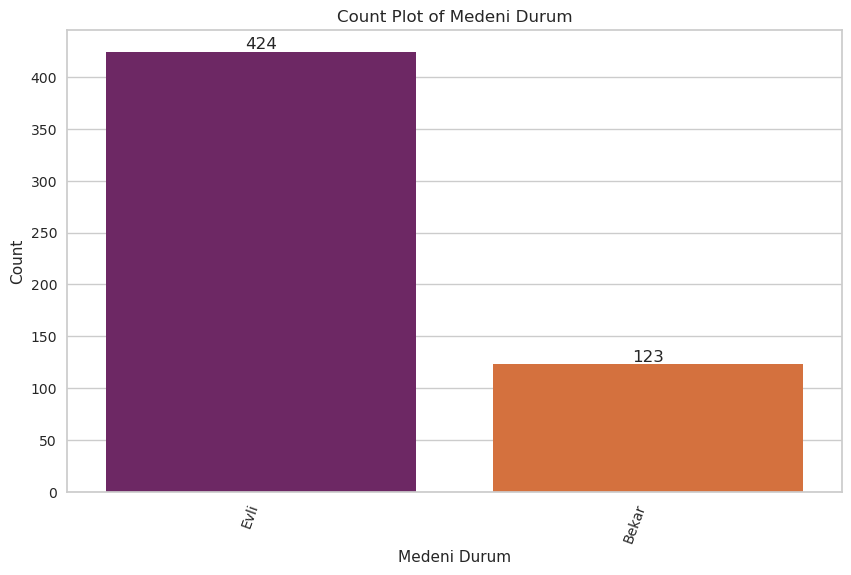

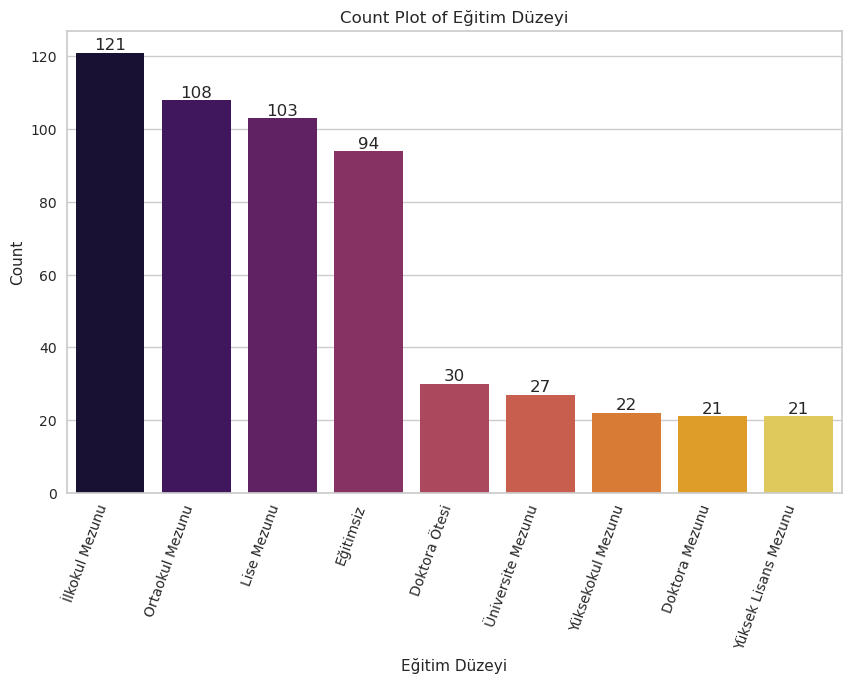

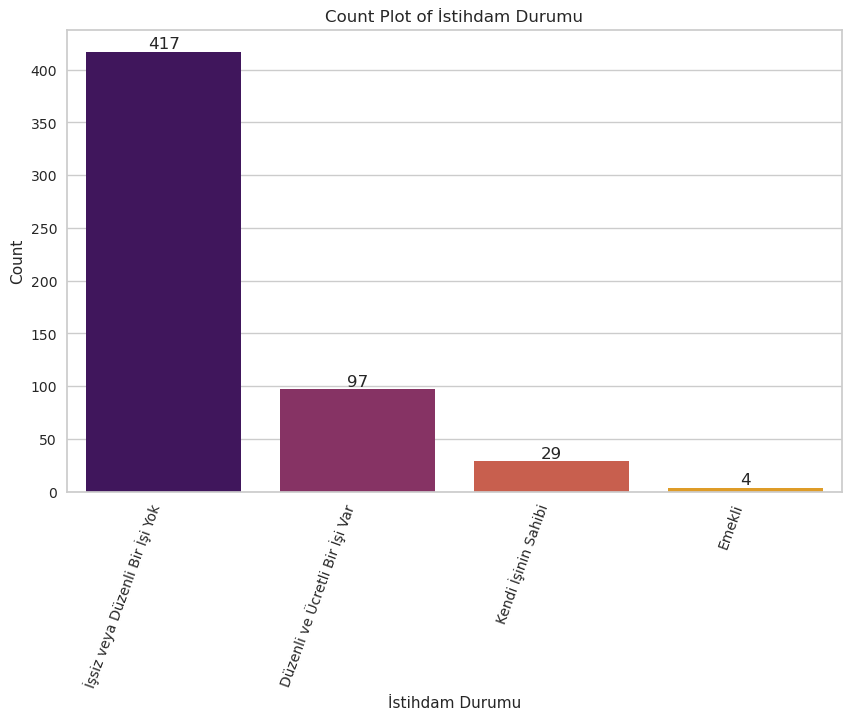

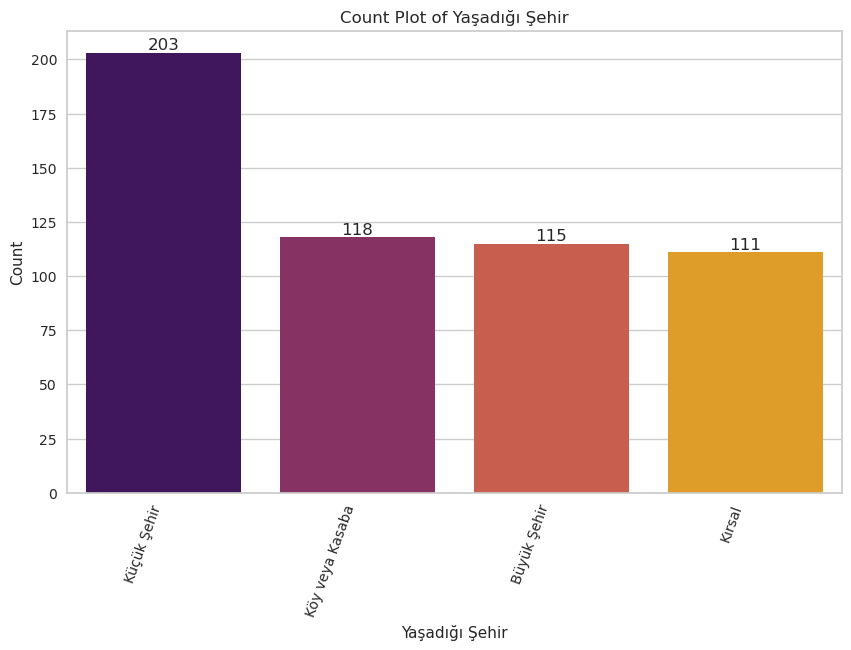

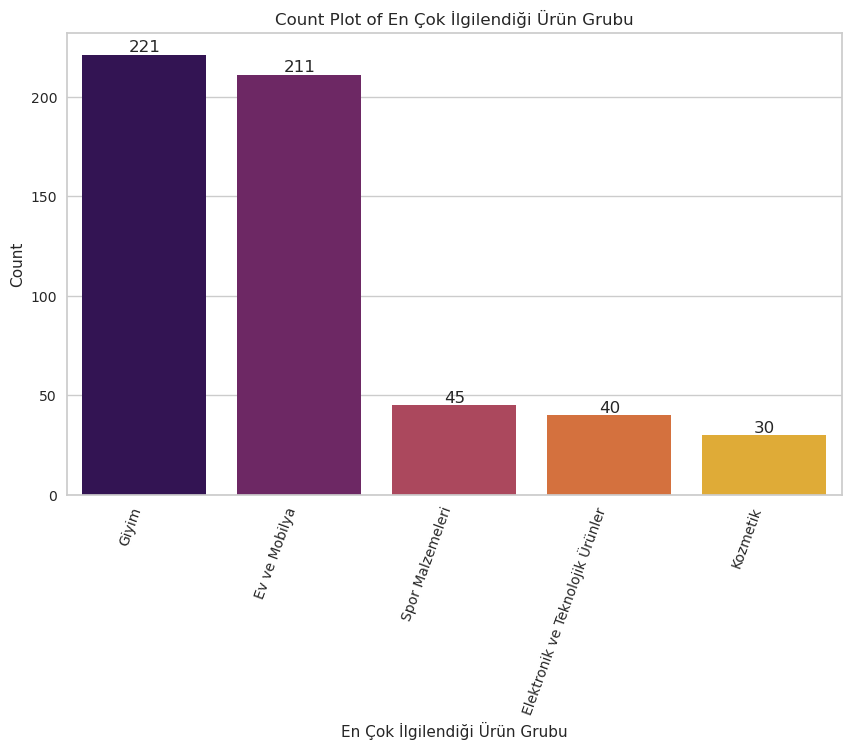

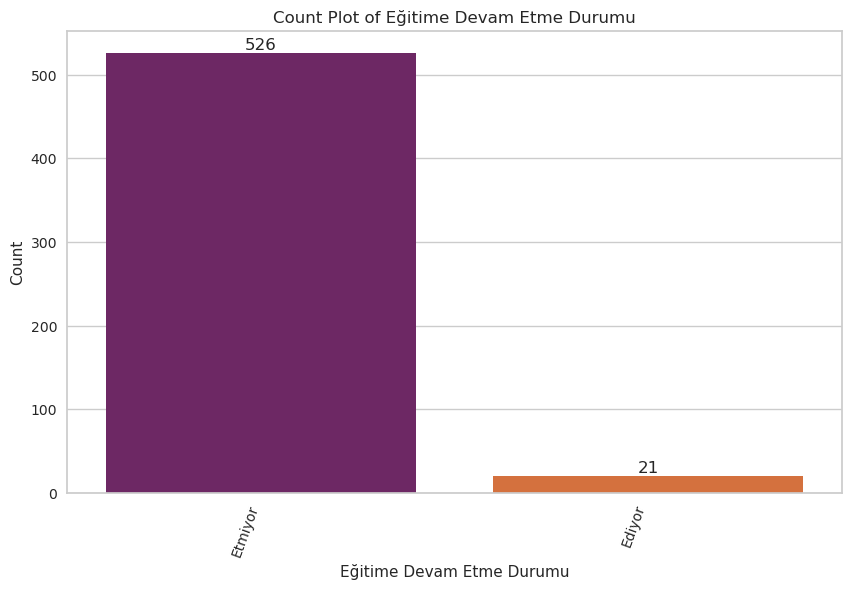

In [41]:
obek_analizi(df, 'obek_2')

######################### obek_3 #########################


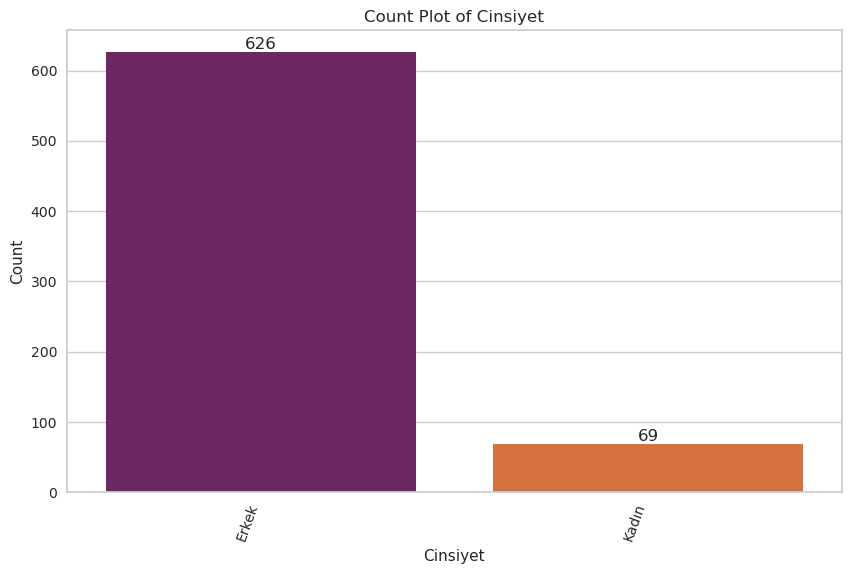

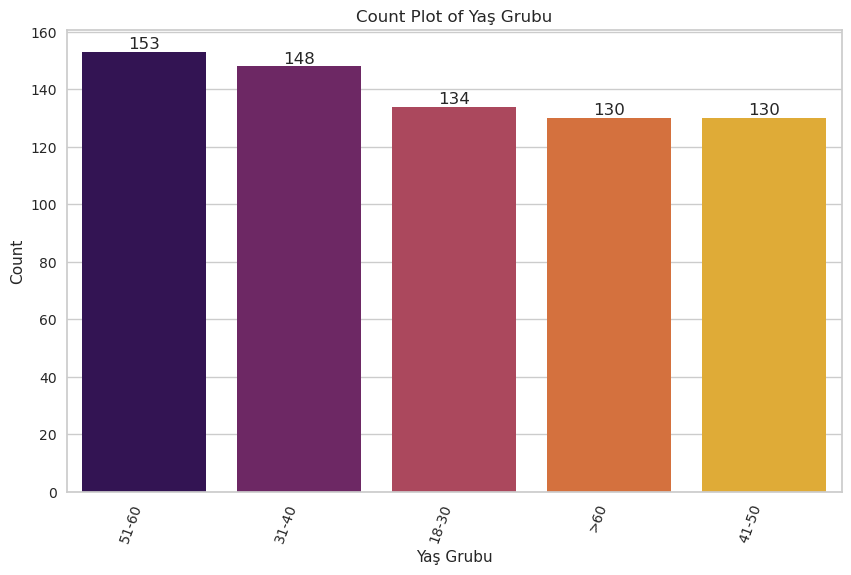

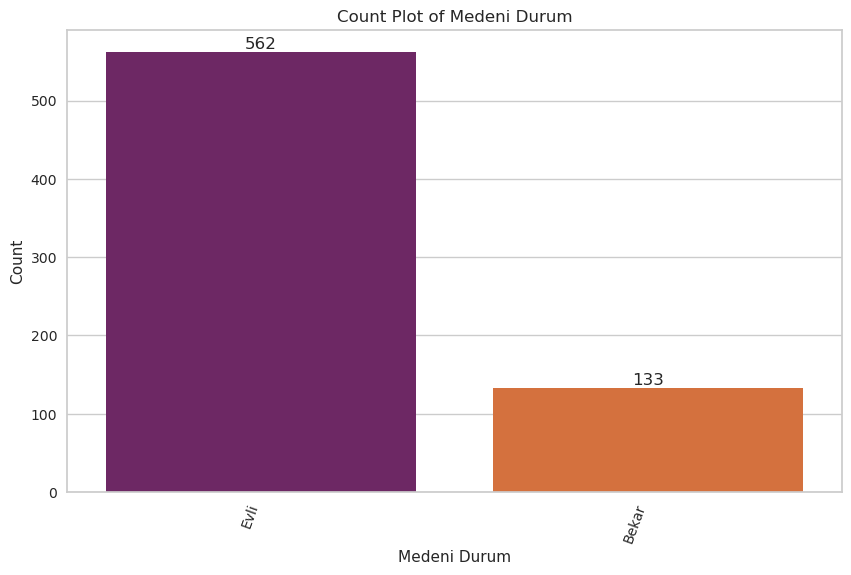

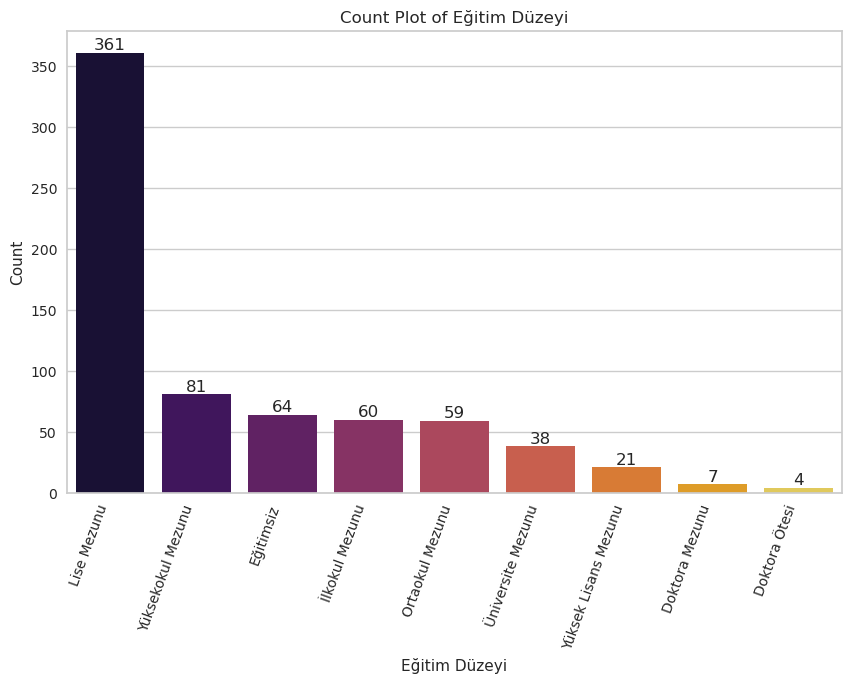

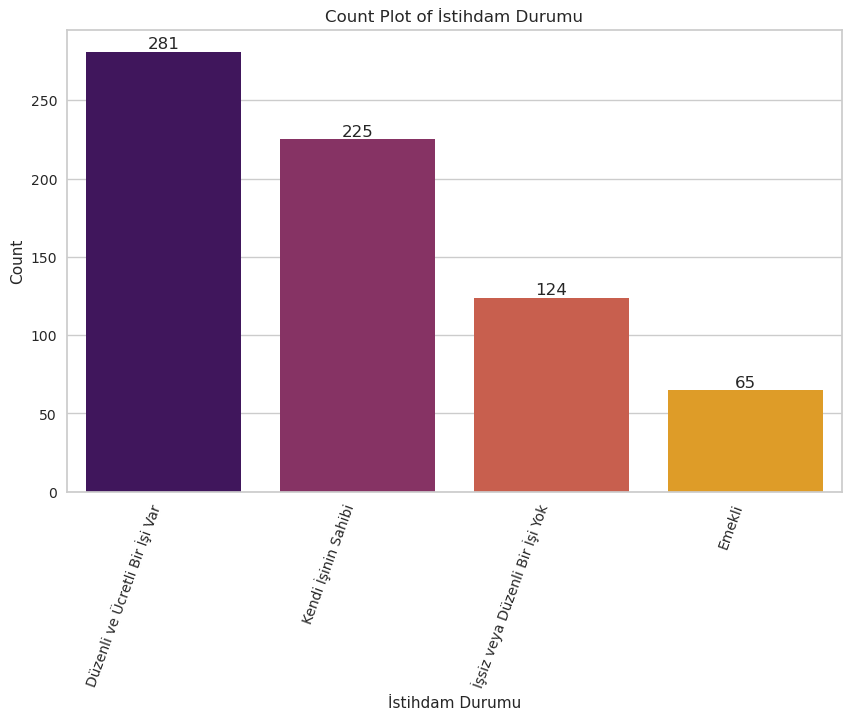

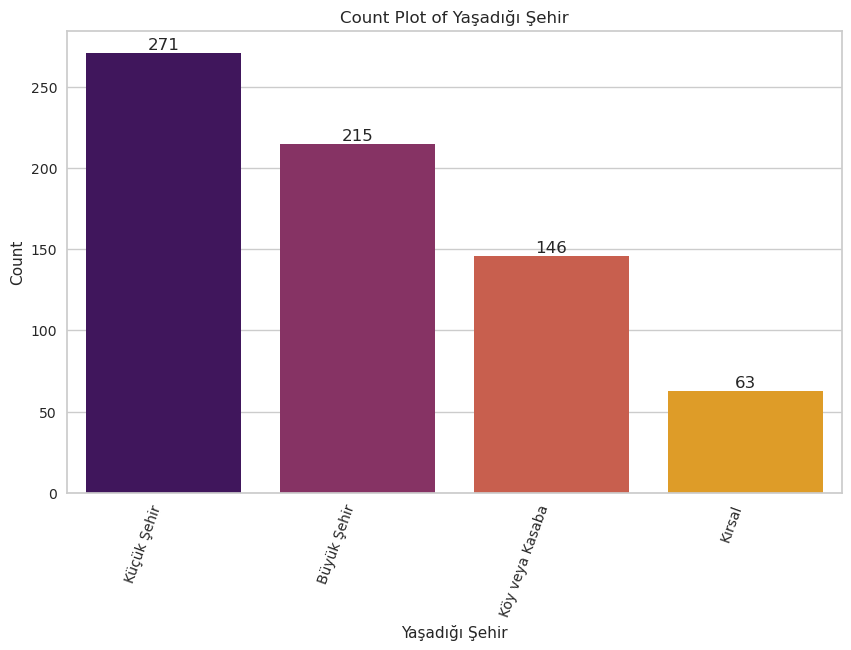

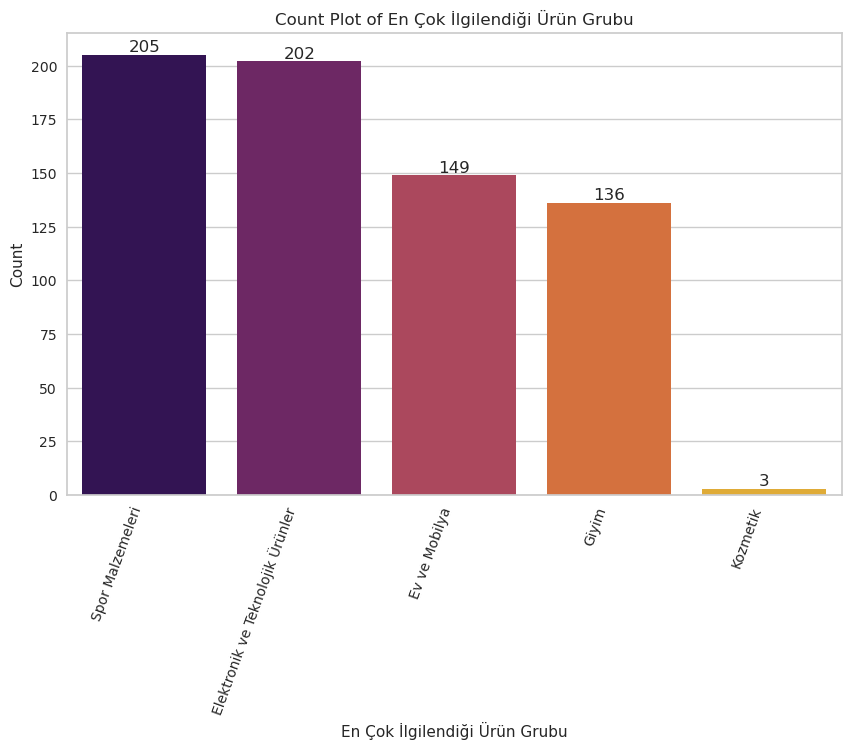

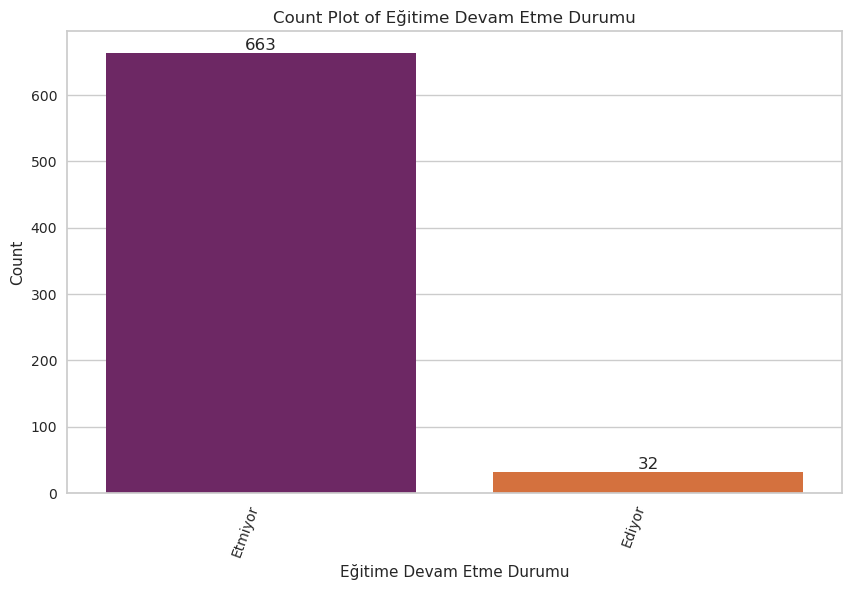

In [42]:
obek_analizi(df, 'obek_3')

######################### obek_4 #########################


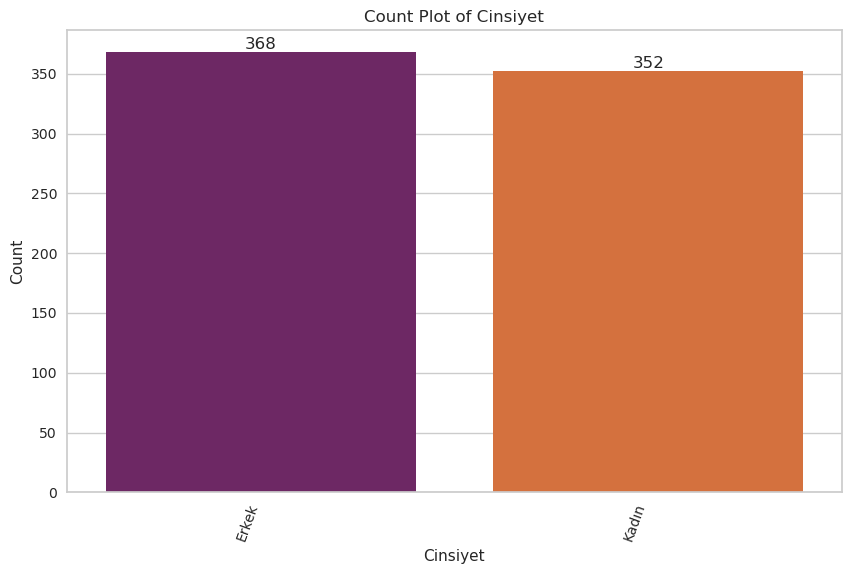

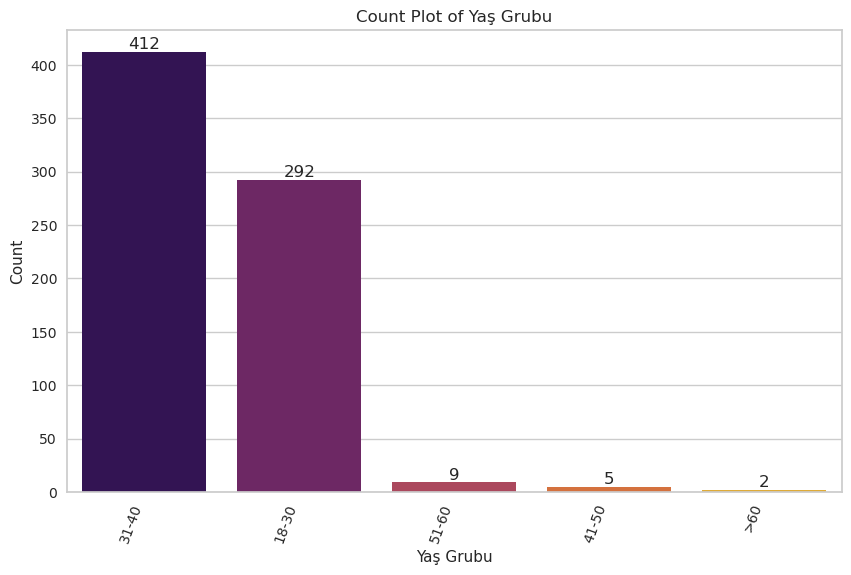

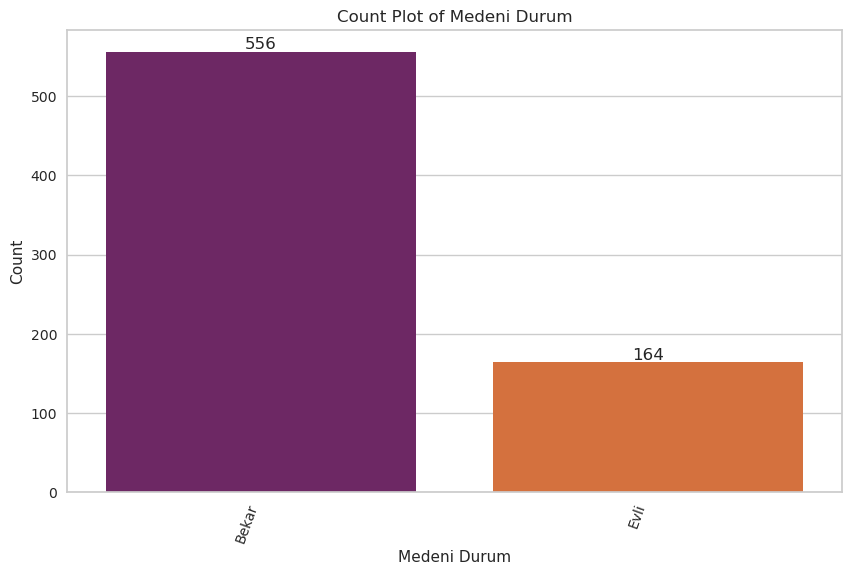

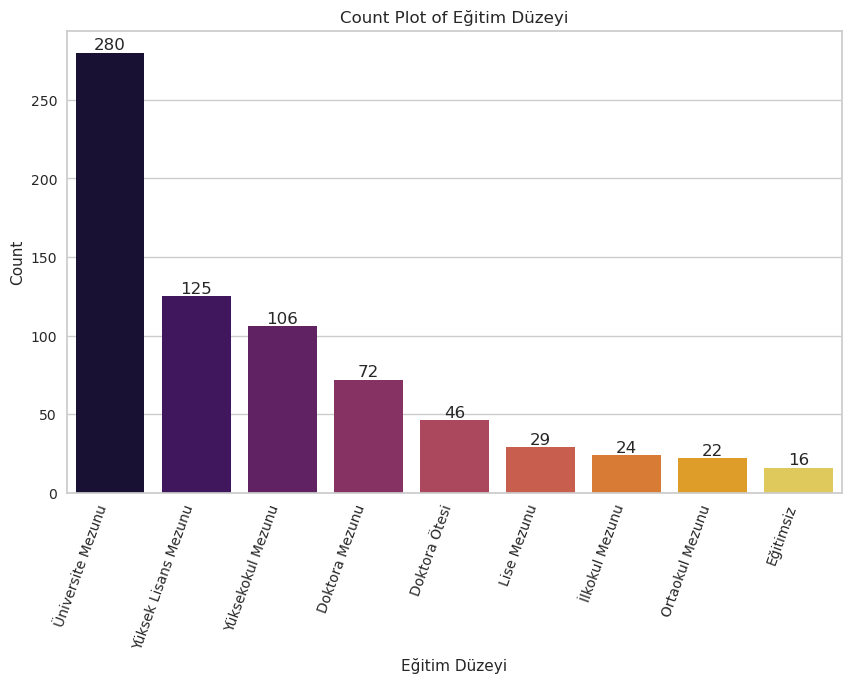

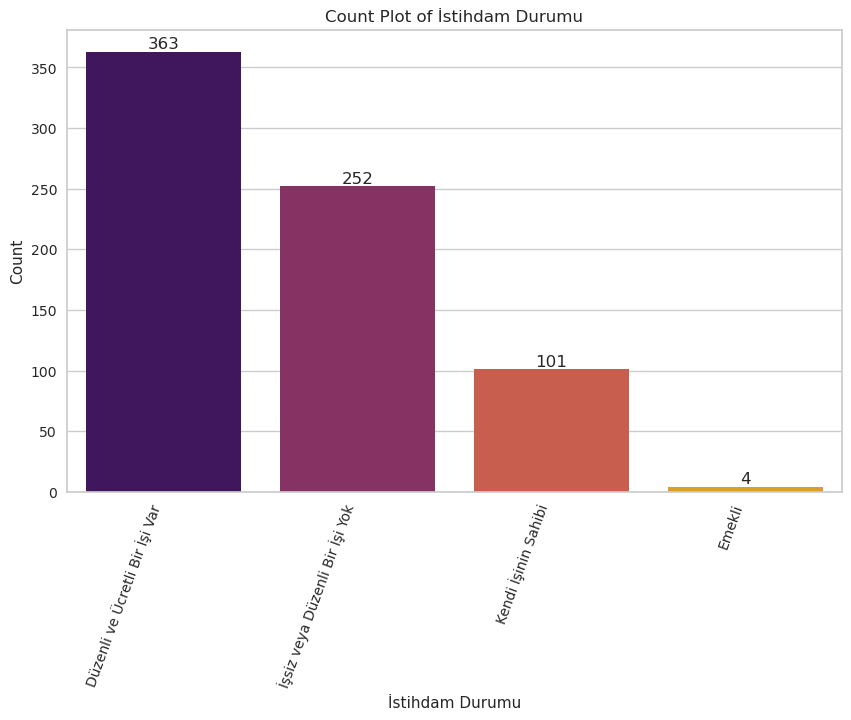

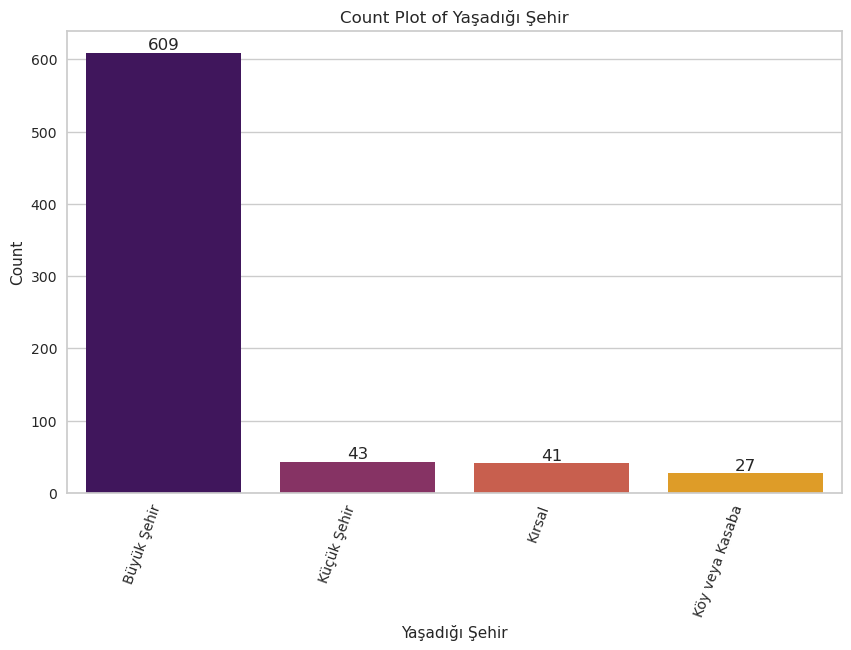

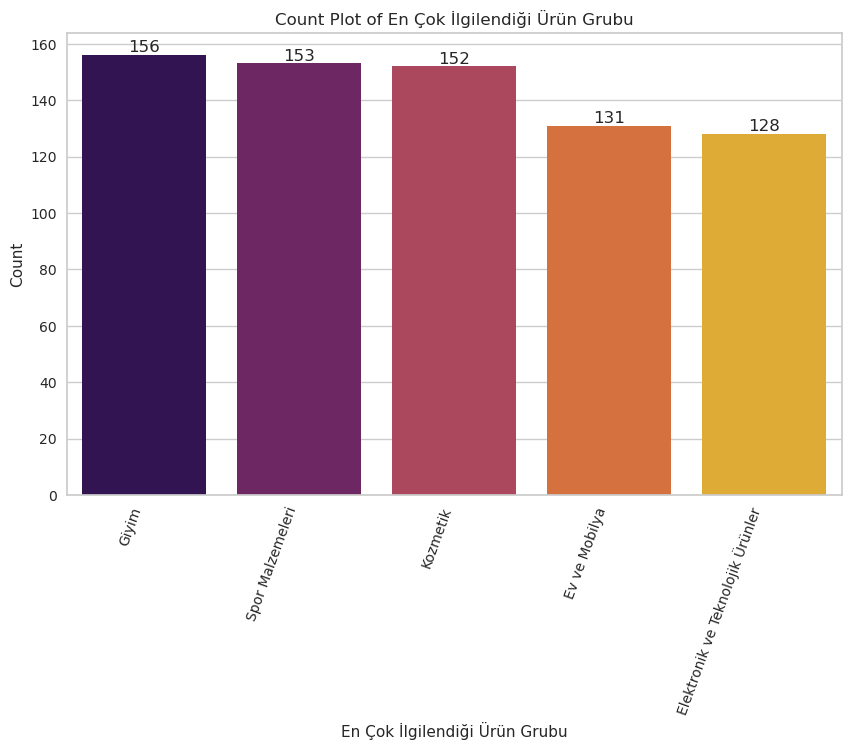

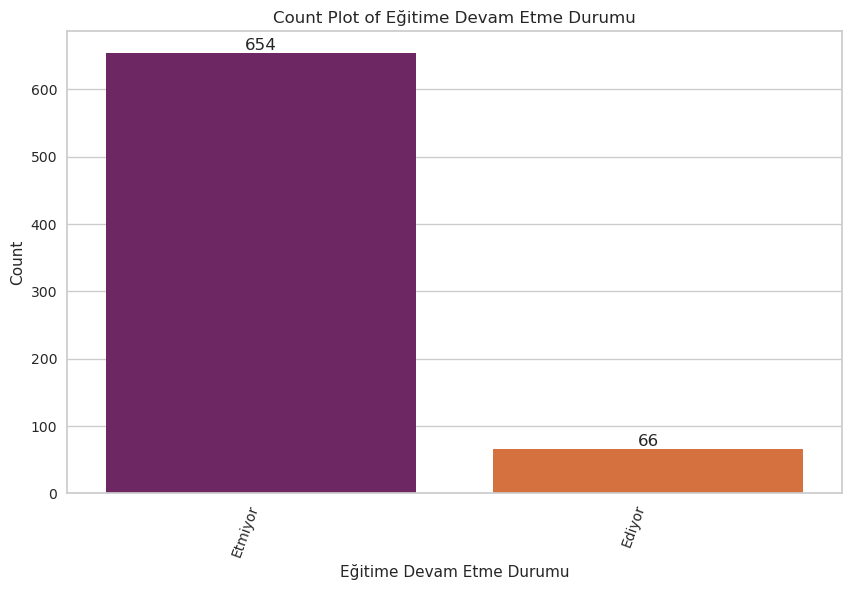

In [43]:
obek_analizi(df, 'obek_4')

######################### obek_5 #########################


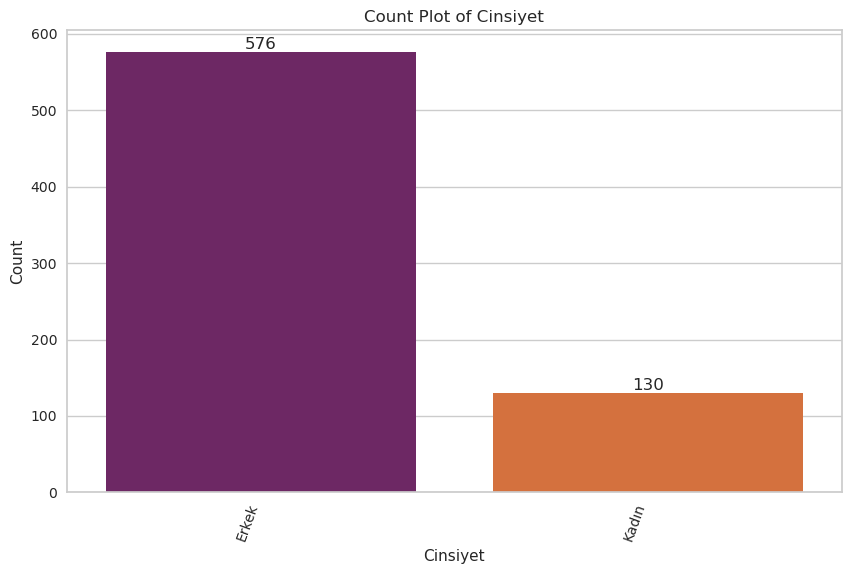

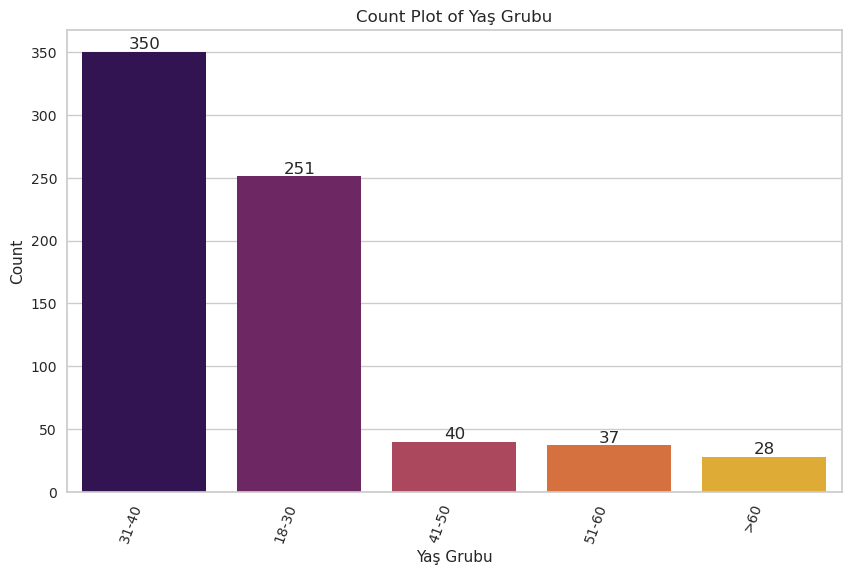

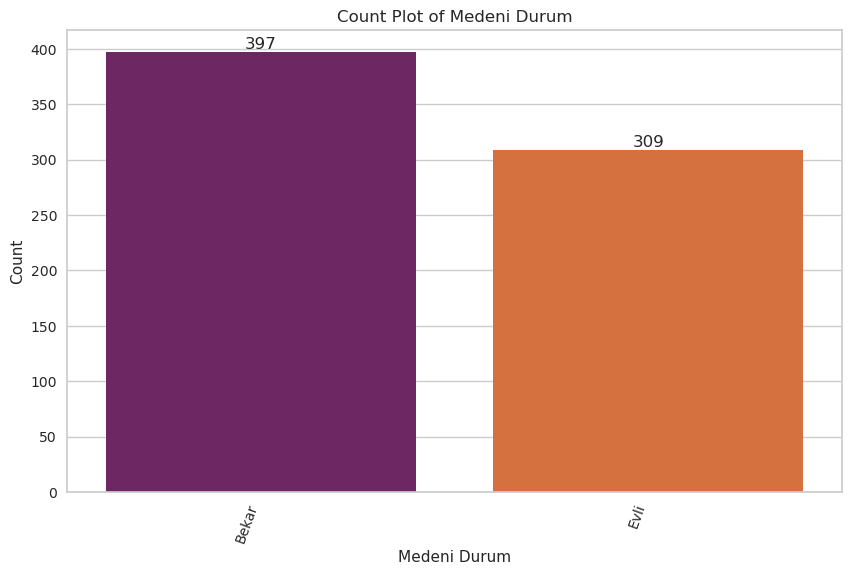

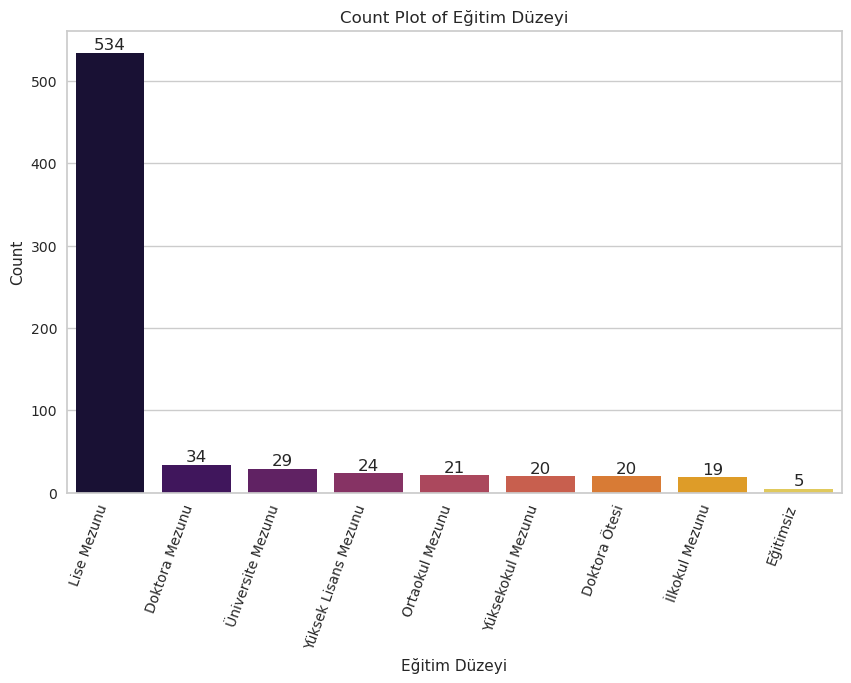

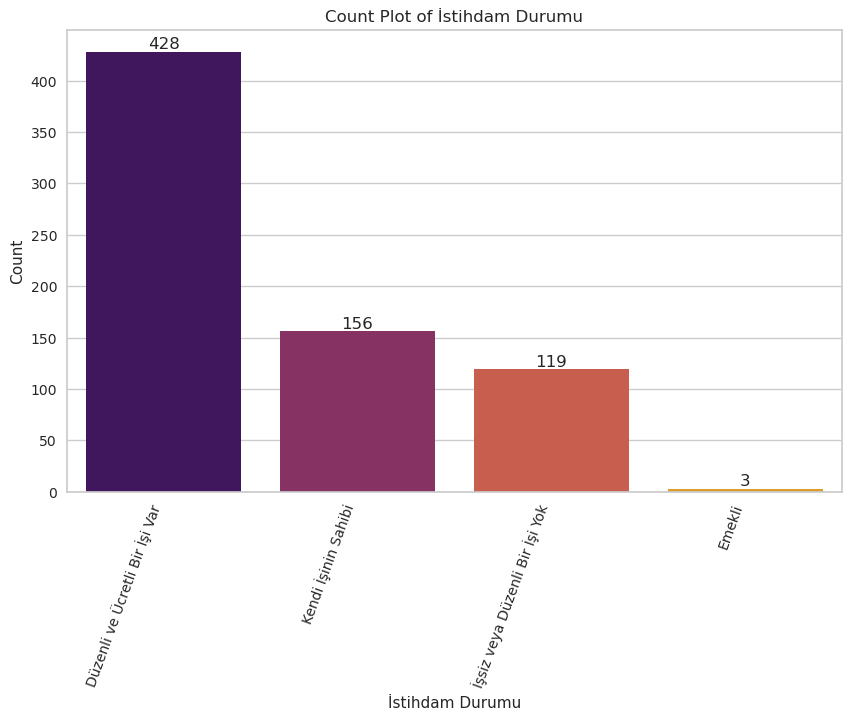

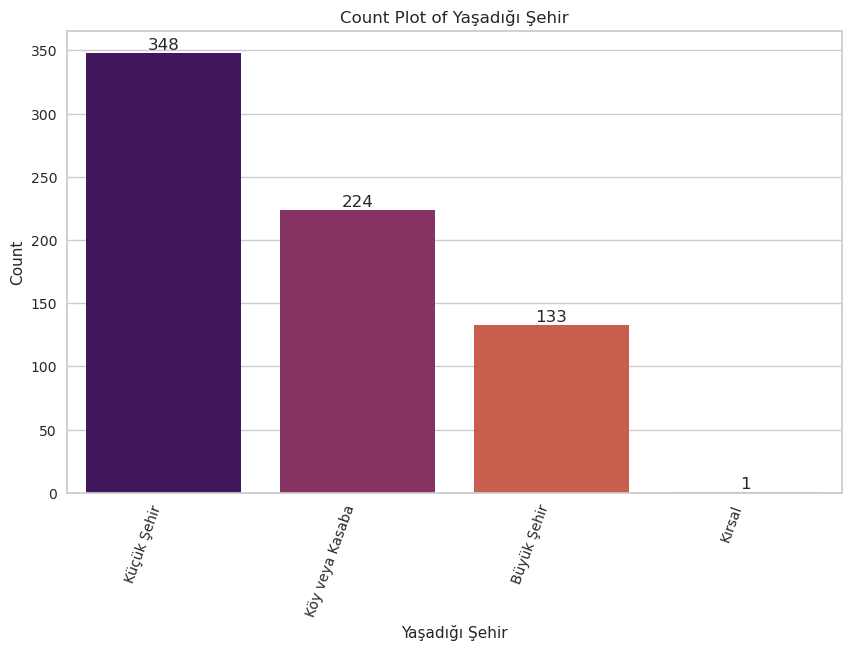

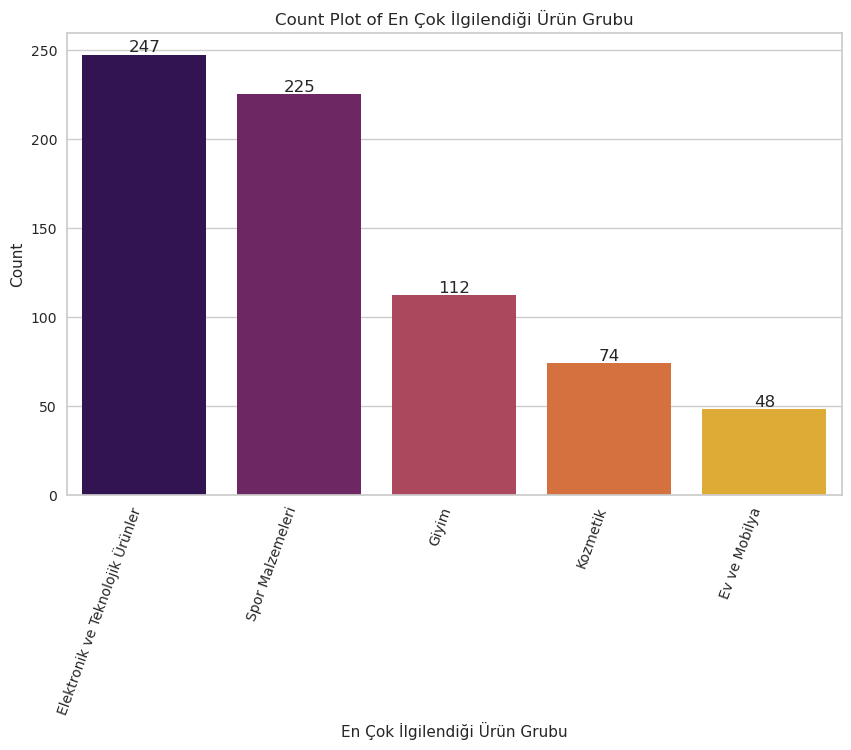

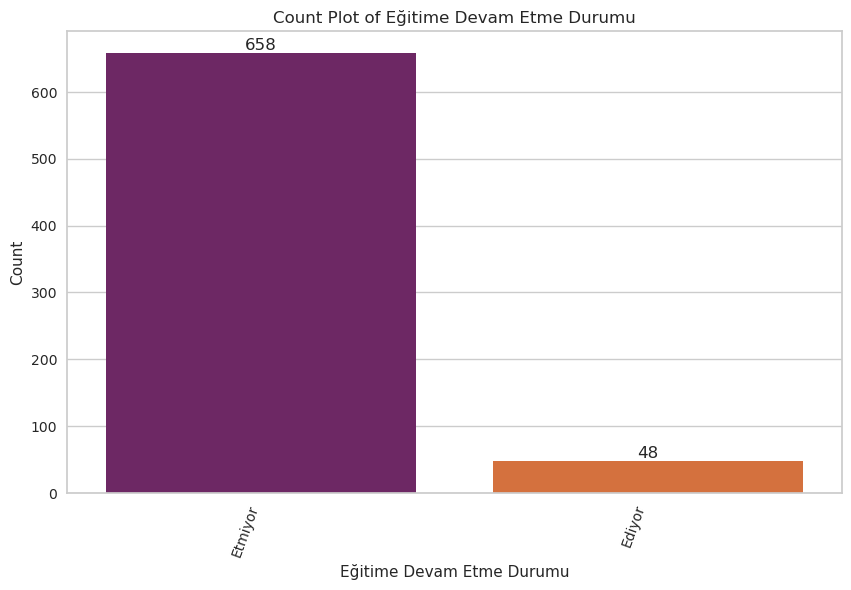

In [44]:
obek_analizi(df, 'obek_5')

######################### obek_6 #########################


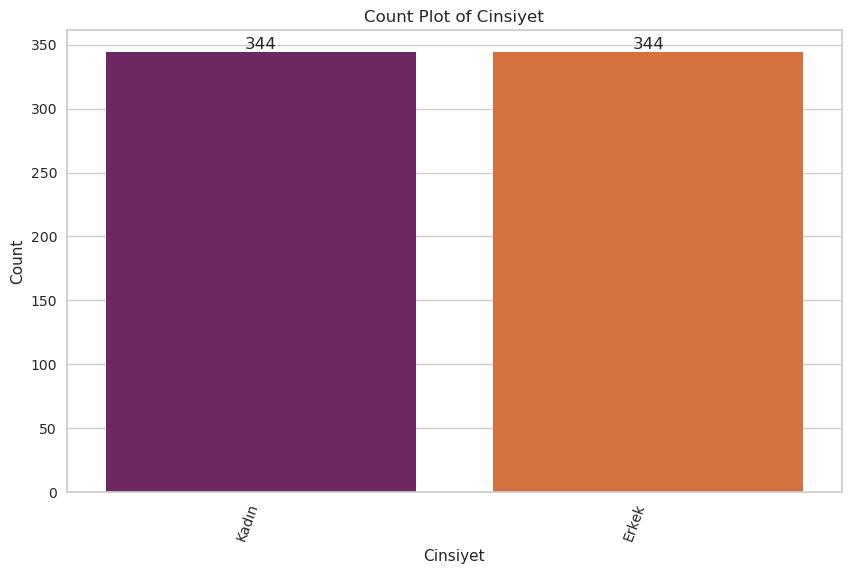

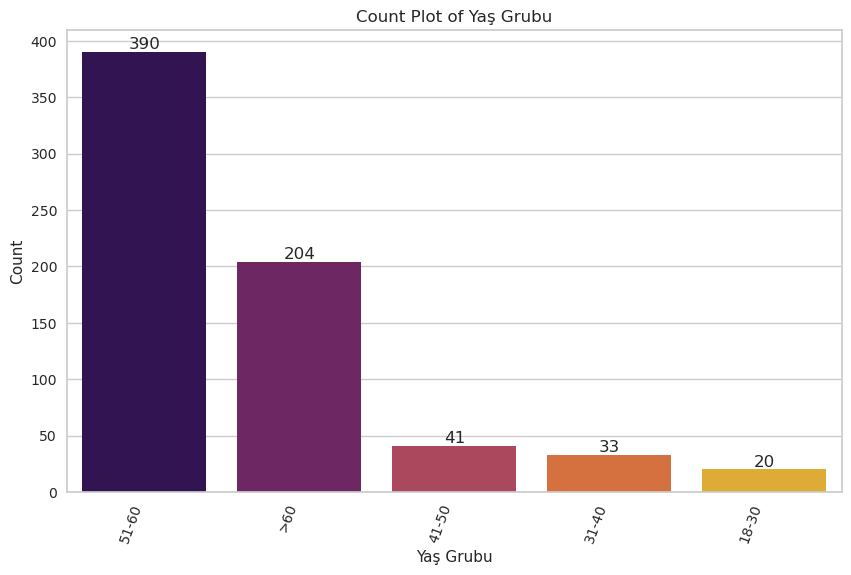

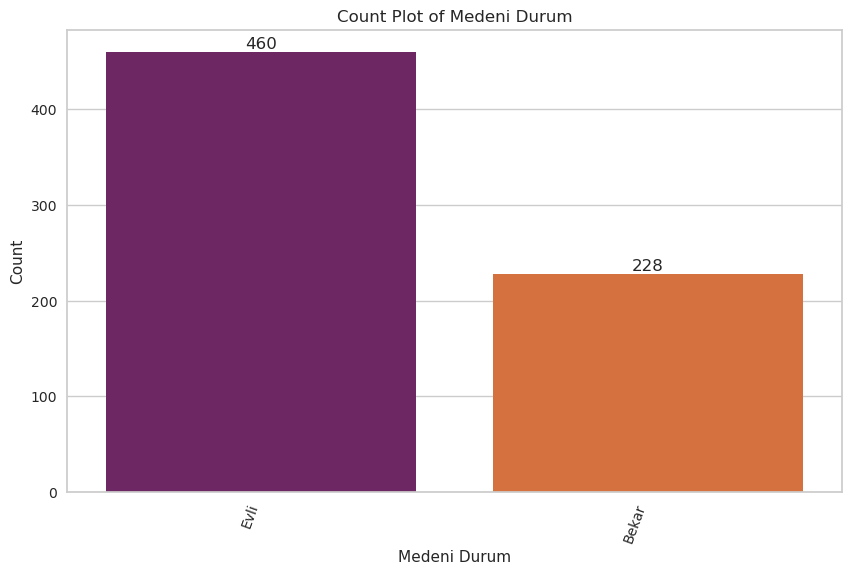

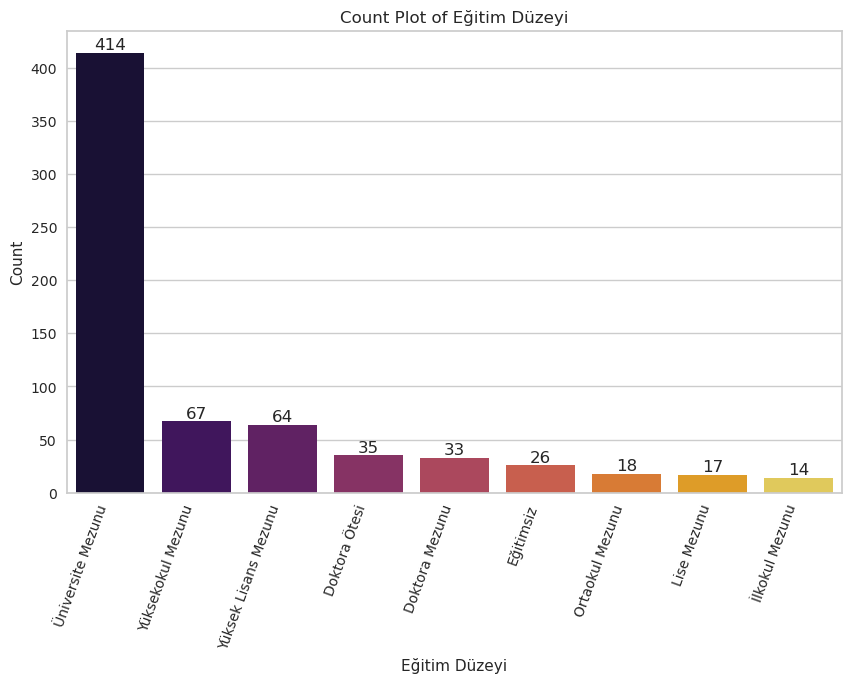

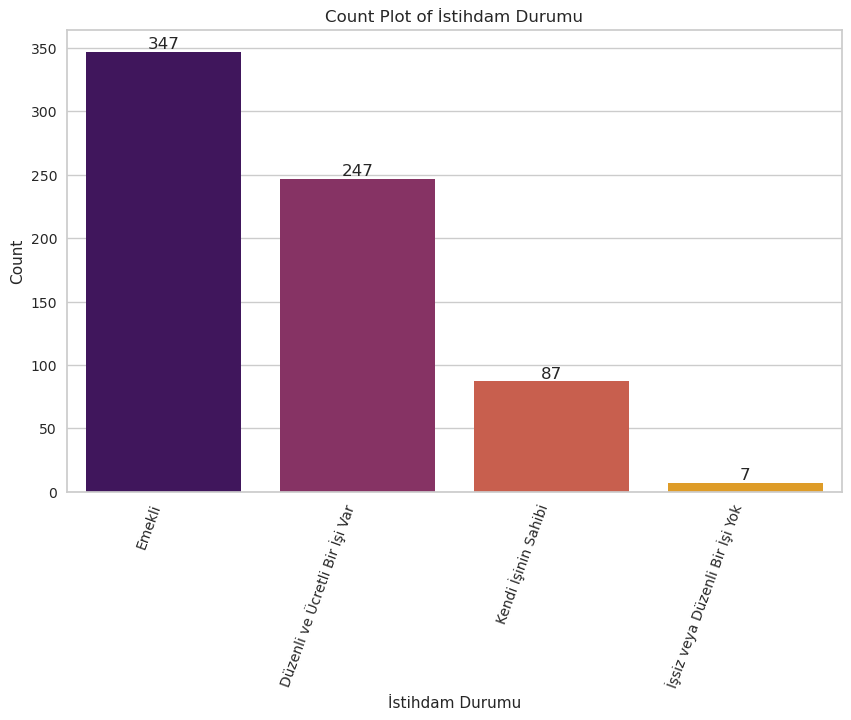

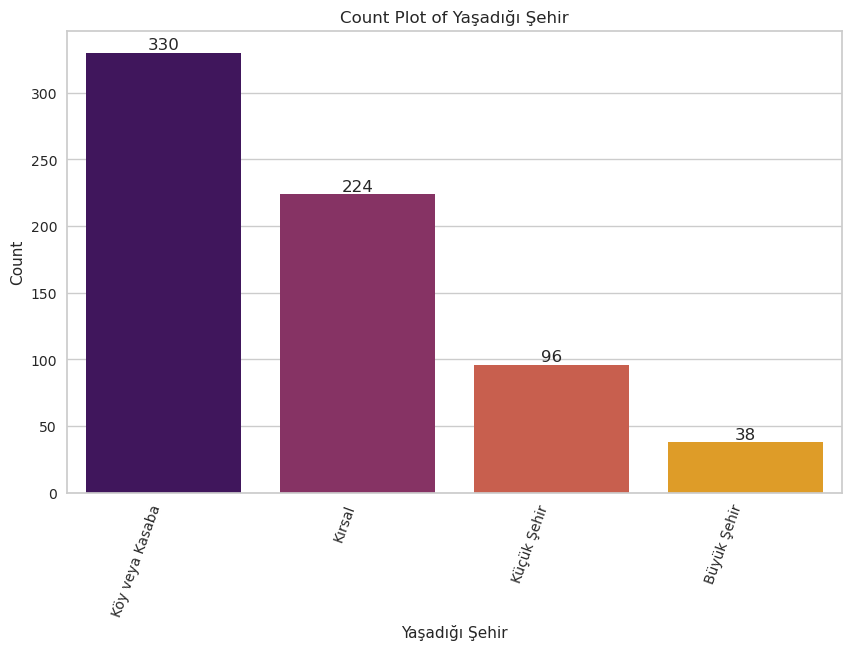

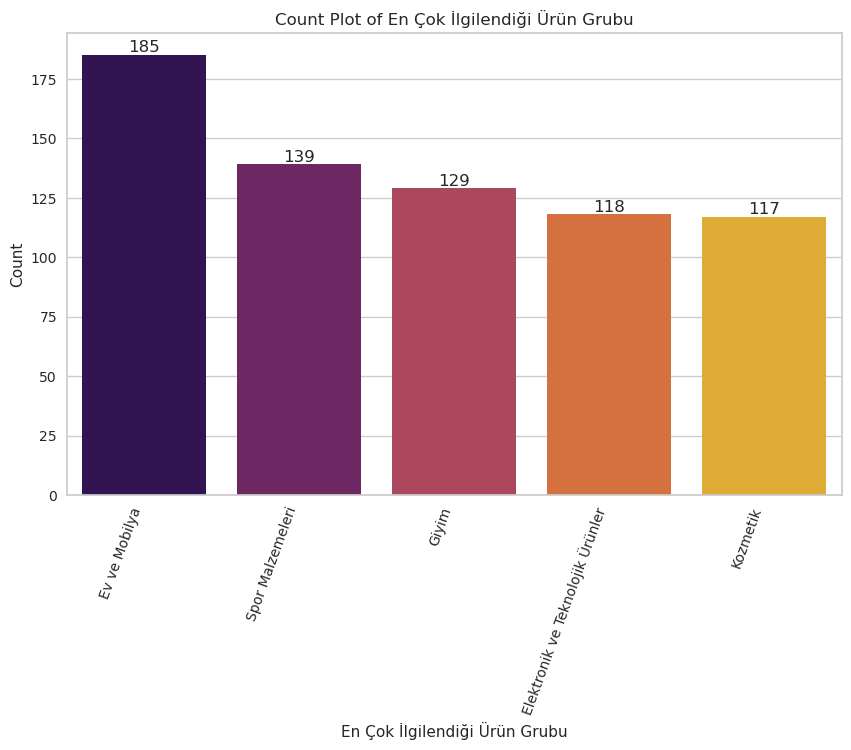

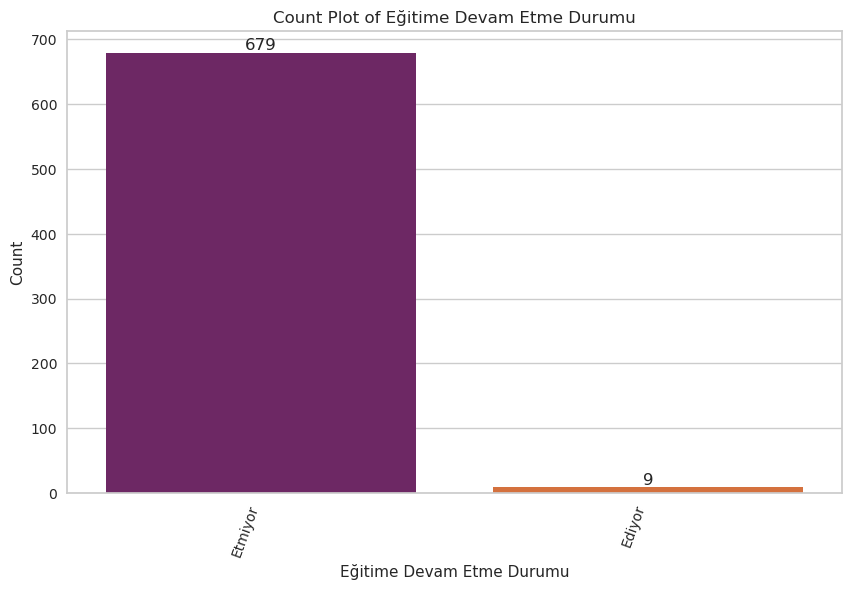

In [45]:
obek_analizi(df, 'obek_6')

######################### obek_7 #########################


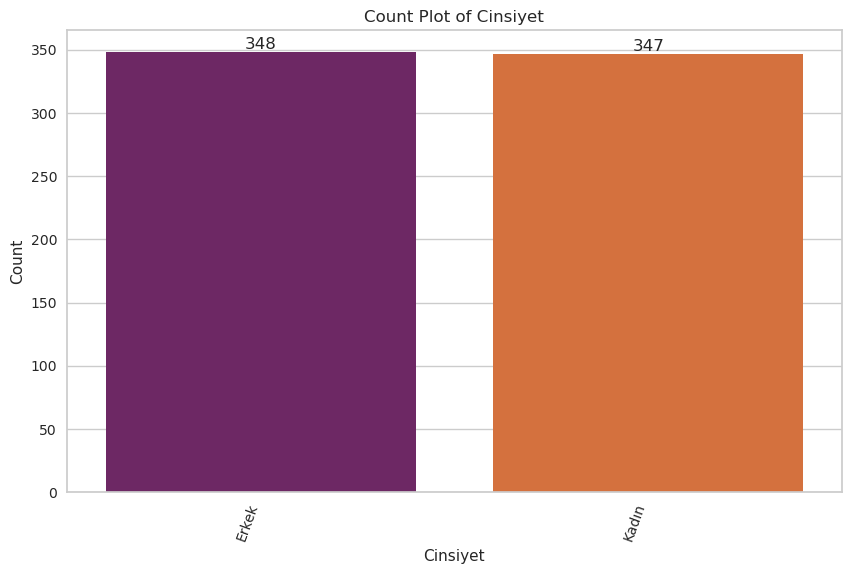

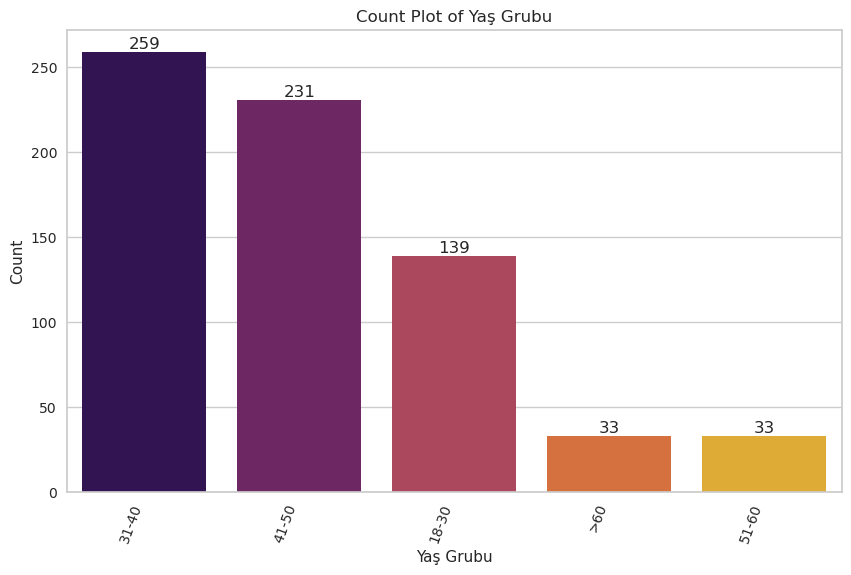

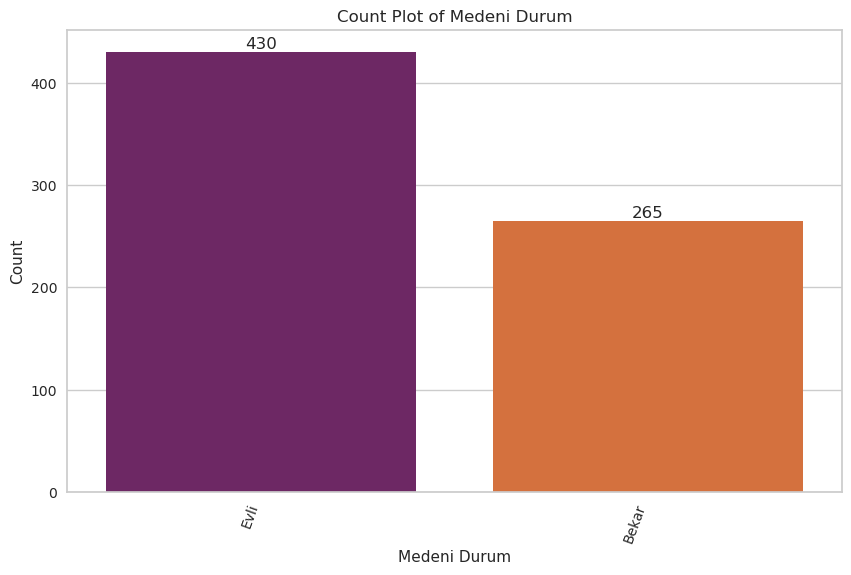

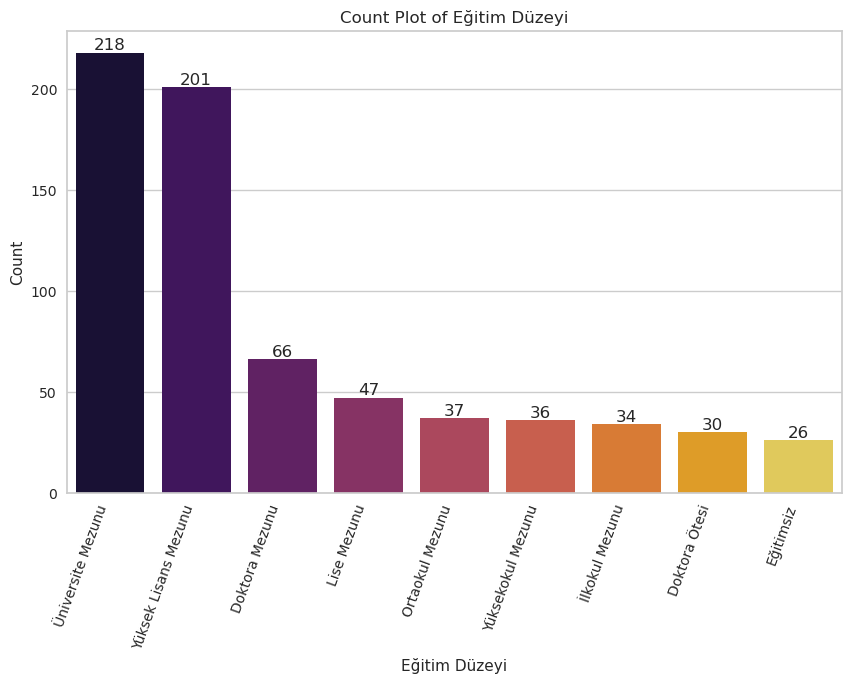

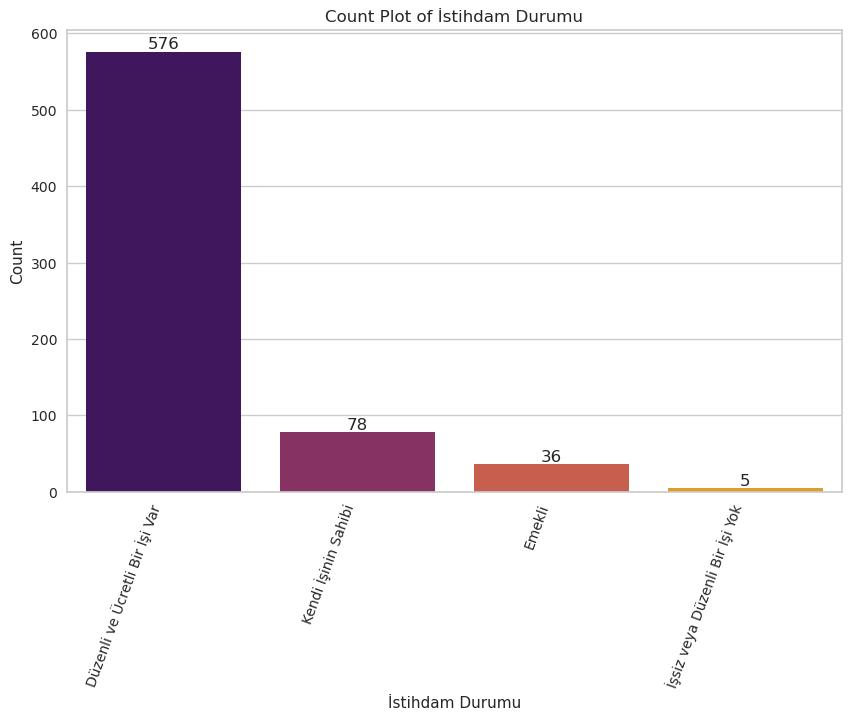

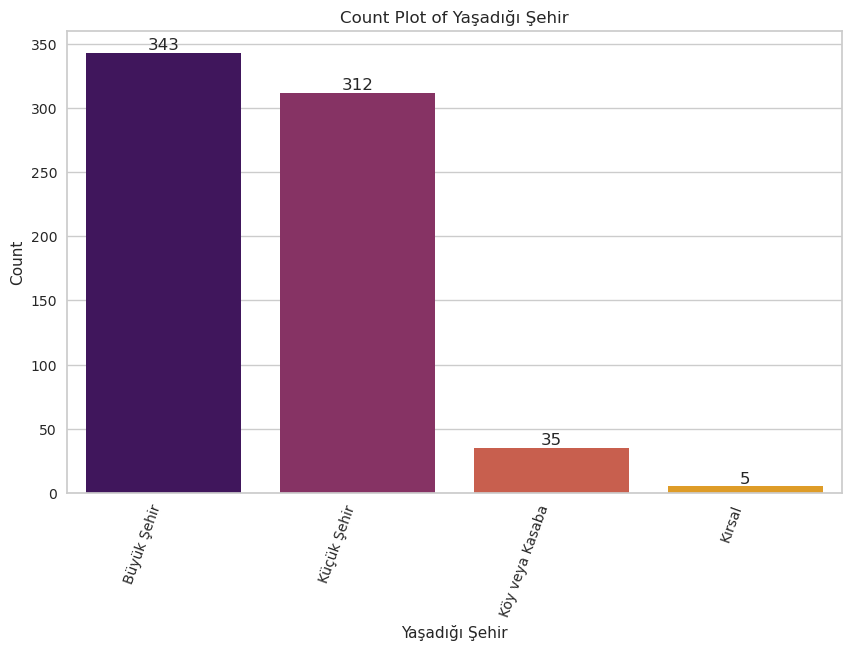

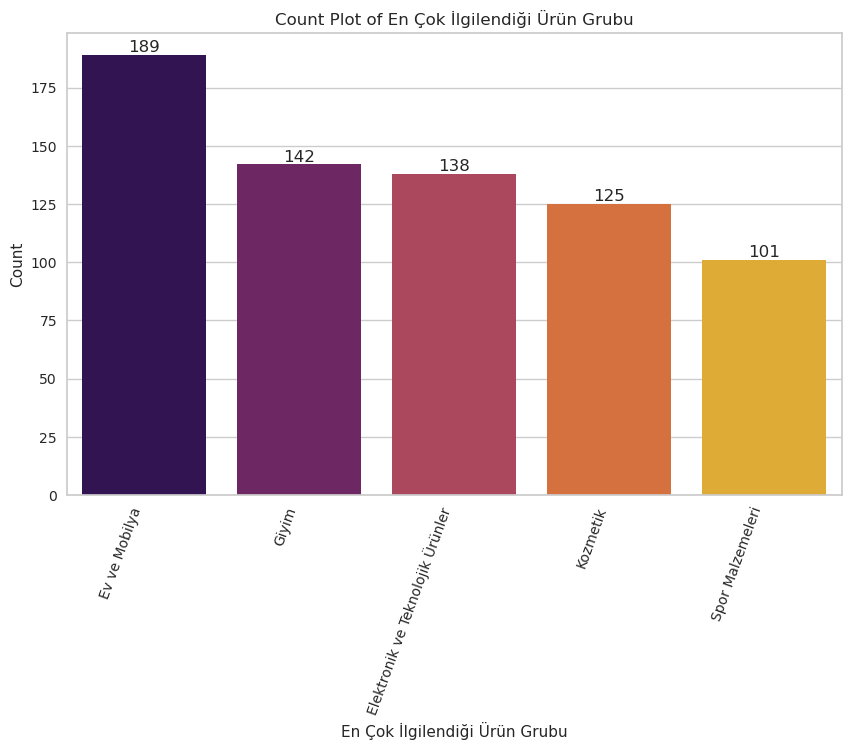

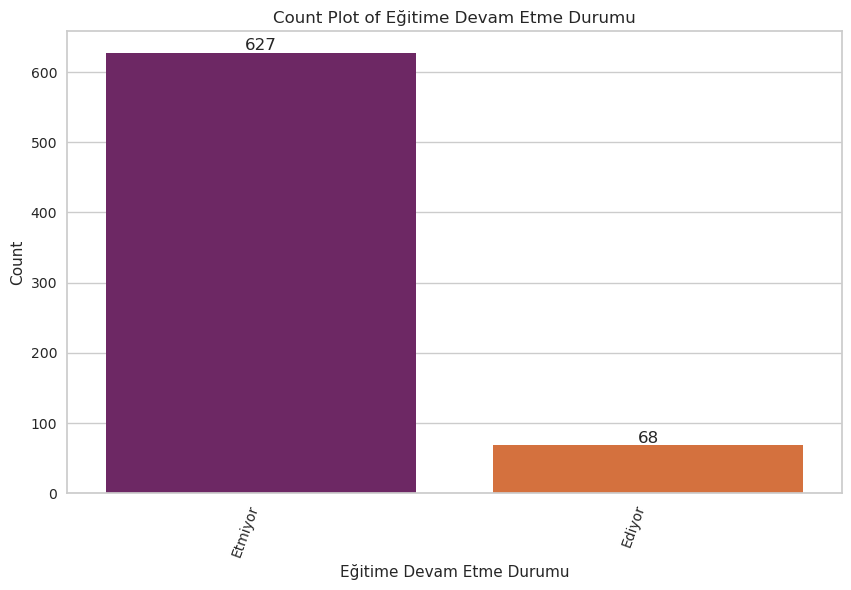

In [46]:
obek_analizi(df, 'obek_7')

######################### obek_8 #########################


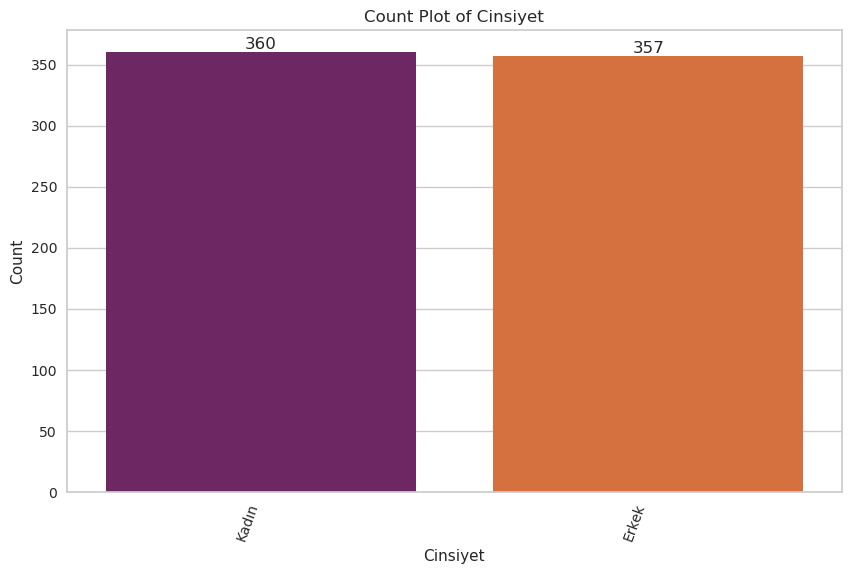

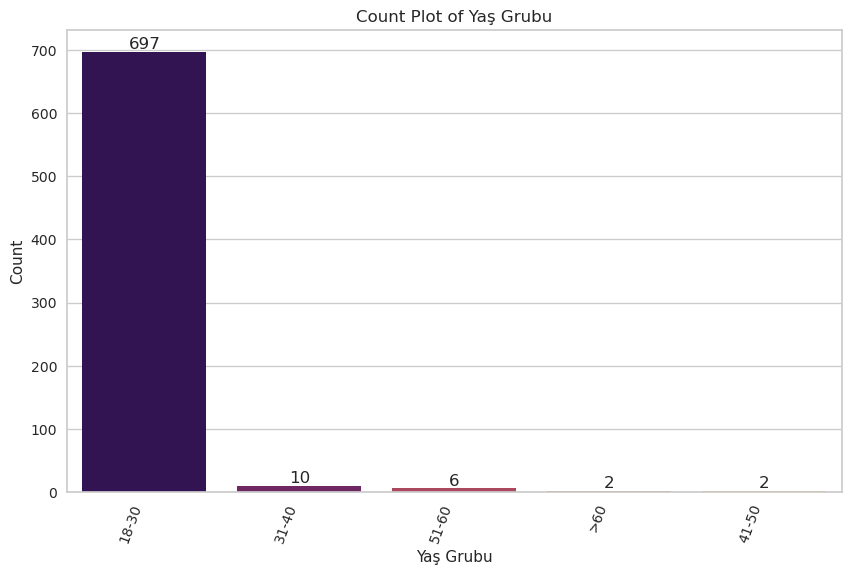

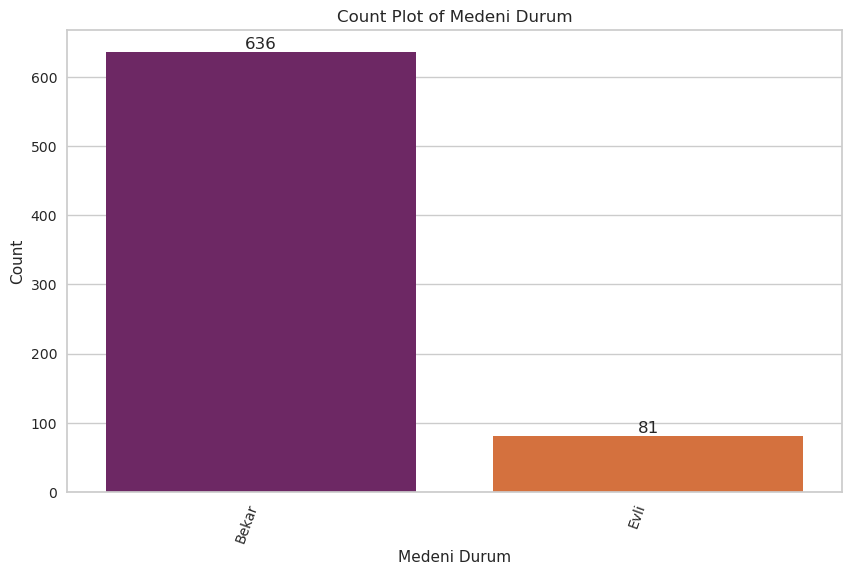

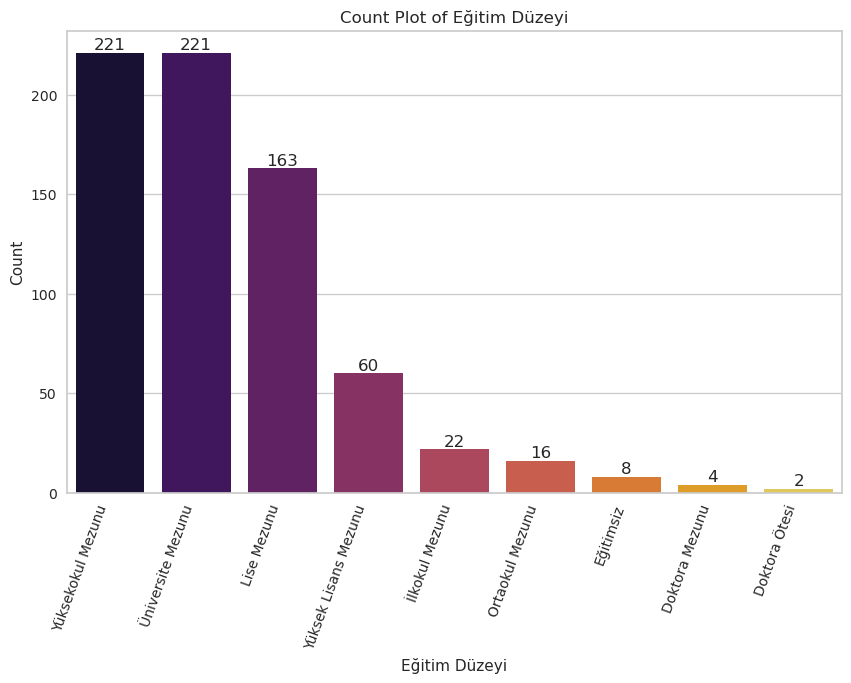

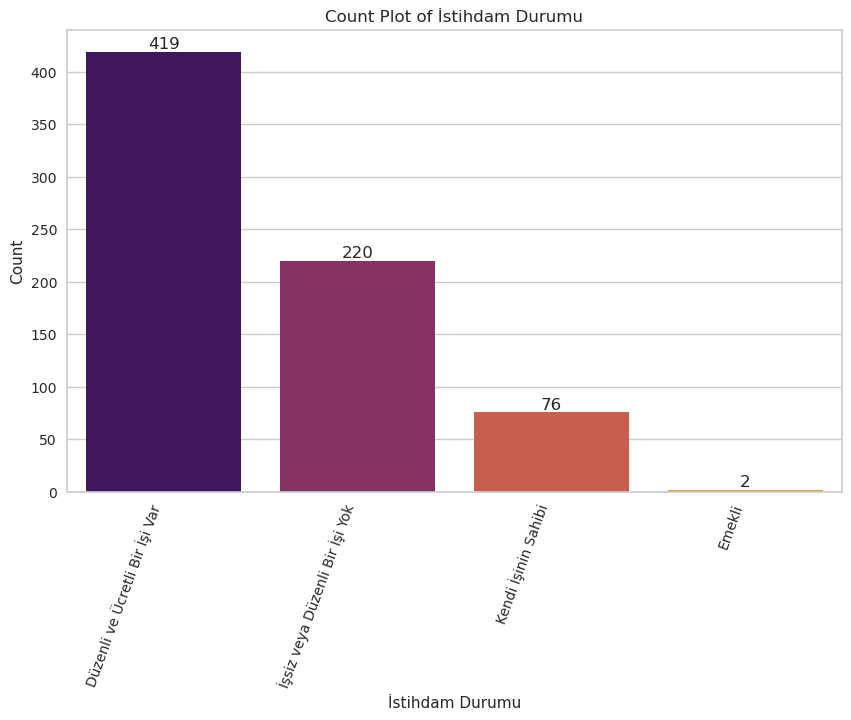

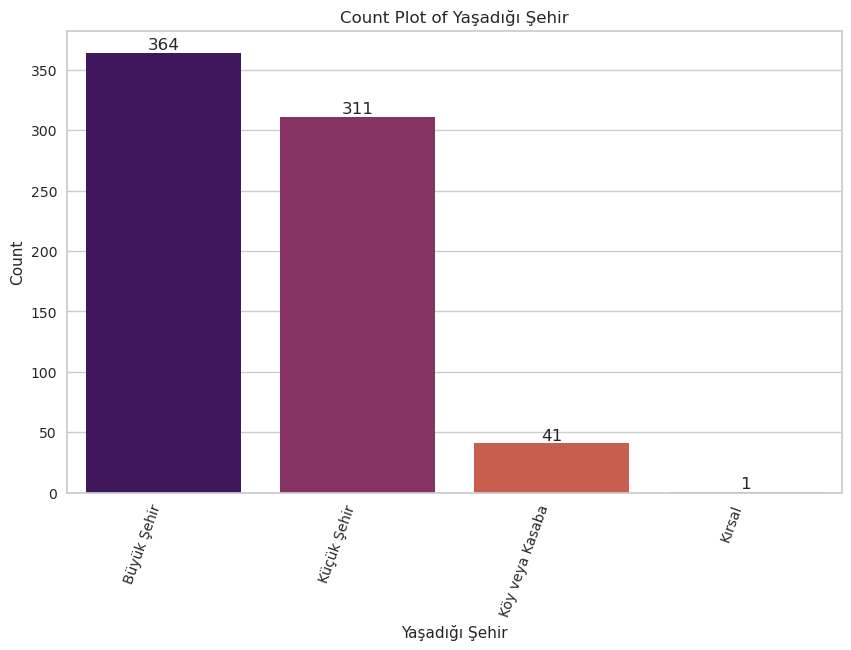

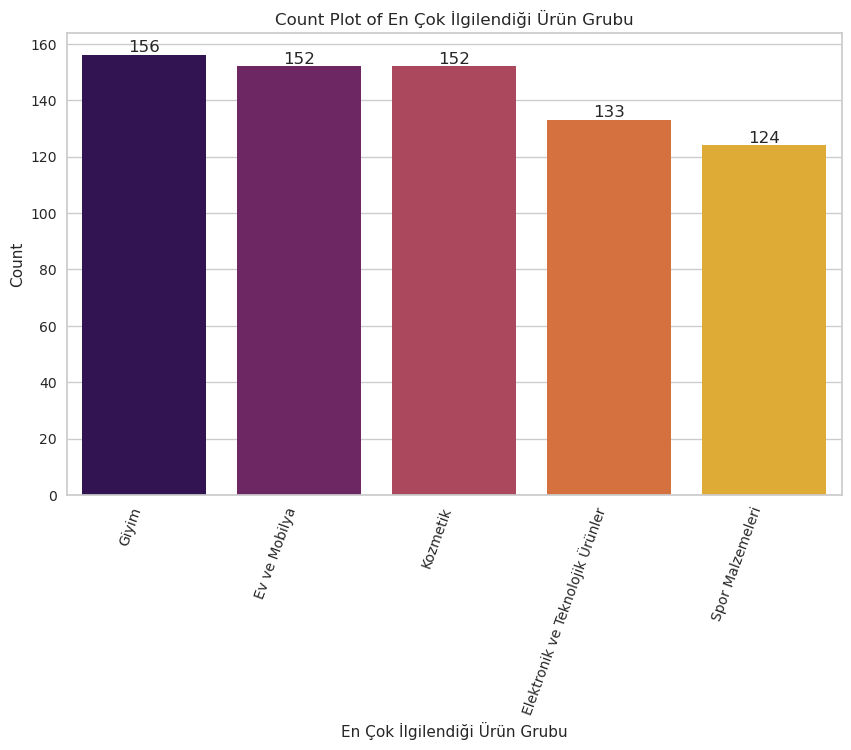

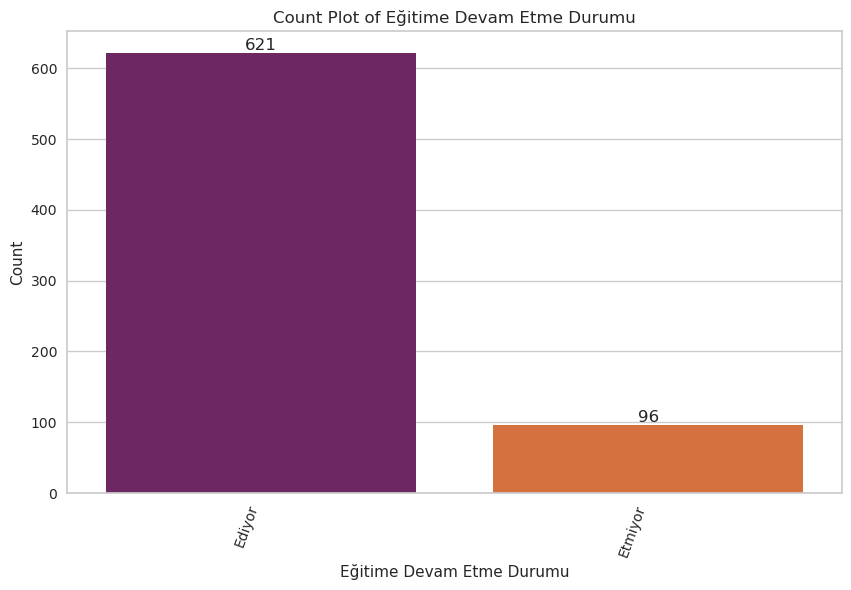

In [47]:
obek_analizi(df, 'obek_8')

In [48]:
np.round(obek_df)

obek_1    obek_2    obek_3  \
Yıllık Ortalama Gelir                      229514.00 172828.00 327899.00   
Yıllık Ortalama Satın Alım Miktarı           6047.00   4996.00   7361.00   
Yıllık Ortalama Sipariş Verilen Ürün Adedi      6.00     21.00     15.00   
Yıllık Ortalama Sepete Atılan Ürün Adedi       13.00     51.00     22.00   

                                              obek_4    obek_5    obek_6  \
Yıllık Ortalama Gelir                      817976.00 222224.00 480118.00   
Yıllık Ortalama Satın Alım Miktarı          32405.00   4542.00  39440.00   
Yıllık Ortalama Sipariş Verilen Ürün Adedi     39.00     11.00     30.00   
Yıllık Ortalama Sepete Atılan Ürün Adedi       98.00    100.00     51.00   

                                              obek_7    obek_8  Genel Ortalama  
Yıllık Ortalama Gelir                      351950.00 255355.00       363571.00  
Yıllık Ortalama Satın Alım Miktarı          26429.00   9277.00        16617.00  
Yıllık Ortalama Sipariş Verilen Ürün Adedi     20.00     49.00           24.00  
Yıllık Ortalama Sepete Atılan Ürün Adedi       98.00    146.00           73.00

## Çıkarımlar 🤔

**Öbek 1:**  <b><span style="color:blue;">Mavi Yakalı İşçi Sınıfı</span></b>  
Genellikle evli ve eğitim seviyeleri düşük, eğitime devam etmiyorlar. Yıllık ortalama gelirleri diğer insanlardan düşük, düzenli ve ücretli bir işi olan, küçük şehirlerde yaşayan insanlardan oluşan bu öbek grubu büyük ihtimalle mavi yakalı işçi sınıfından oluşuyor. Alışveriş alışkanlıklarına bakıldığında ise yıllık ortalama satın alım miktarı ve adedi düşük olan bu grup en fazla giyime para harcıyor. Kitlenin temel ihtiyaçlara para harcadığı çıkarımı yapılabilir.

**Öbek 2:**  <b><span style="color:orange;">Ev Hanımı Sınıfı</span></b>  
Bu kitle çok yüksek sayıda artık eğitimine devam etmeyen ve eğitim seviyesi düşük kadınlardan oluşmaktadır. İşsiz veya düzenli bir işi olmayan bu kitlenin yıllık ortalama geliri mavi yakalı işçilerden bile az. Bundan dolayı bu öbek grubunun ev hanımı olma ihtimali çok yüksek. Alışveriş alışkanlıklarına bakıldığında en fazla giyim, ev ve mobilya harcamalarında bulunulduğu görülüyor. Ayrıca ilginç bir şekilde kozmetik kategorisinde en az alışveriş yapan kadın popülasyonu olmuş.

**Öbek 3:**  <b><span style="color:red;">İş Kadını Sınıfı</span></b>  
Bu kitle eğitim seviyesi lise-MYO mezunu olup eğitimine artık devam etmeyen, gelir düzeyi diğer kadın gruplarının çok üzerinde olan çalışan kadın sınıfıdır ki bu sınıfa iş kadını demek doğru olacaktır. Bu sınıfın alışveriş alışkanlıklarına bakıldığında satın alım miktarı ve satın alınan ürün adedi ortalamanın altında kalsa da genelde spor ve teknolojik ürünler aldıklarından bu beklenen bir durumdur. Bu sınıf neredeyse hiç kozmetik ürünü almadığından kozmetik ürün reklam ve promosyonlarının bu grupla paylaşılmaması reklam bütçesini korumak adına mantıklı olacaktır.

**Öbek 4:**  <b><span style="color:green;">Beyaz Yakalı Sınıfı</span></b>
Kadın erkek dağılımının birbirine çok yakın olduğu orta yaşlı üniversite mezunu bekar insanlardan oluşan bu grup ortalamanın çok üzerinde maaş almaktadırlar. Sepete attıkları ürün miktarının ve satın alım miktarlarının ortalamanın yükselmesine sebep olan bu grubun alışveriş alışkanlıklarına bakıldığında her kategoriden fazlasıyla alışveriş yaptıklarından müşterilerimiz arasında alışveriş bağımlısı diyebileceğimiz bir müşteri grubudur. Büyük şehirlerde yaşayan bu grubun beyaz yakalılardan oluştuğunu söyelyebiliriz.

**Öbek 5:**  <b><span style="color:brown;">Erkek İşçi Sınıfı</span></b>
Orta yaşlı, lise mezunu, erkeklerin çoğunluğunu oluşturduğu küçük şehir ve kasabalarda yaşayan bu sınıf, her türlü ortalamanın altında bulunmaktadırlar, sepete atılan ürün sayısı hariç. Buradan hareketle alışveriş sitemizde sürekli gezinip sepete sürekli bir şeyler atıyorlar ancak satım alım miktar ve adedine bakıldığında ortalamaya yakın bile değiller. Alışveriş alışkanlıkları incelendiğinde az olsa da yaptıkları alışverişler teknoloji ve spor malzemeleri üzerine olmuş. Açıkcası bu sınıf için özel bir reklam/promosyon çalışmasına gidilmesine gerek olmadığını düşünüyorum. Zira yaptıkları alışveriş miktarlarına bakıldığında atılan taş kolu yorduğuna değmez.

**Öbek 6:**  <b><span style="color:#FAE041;">Nitelikli Emekli Sınıfı</span></b>
Erkek ve kadın sayısının eşit olduğu, üniversite mezunu olup emekliye ayrılmış ve köy/kasabaya yerleşmiş ve yaşı epey ilerlemiş bu sınıf eğitim seviyeleri tyüksek nitelikli iş gücünü zamanında oluşturmuş ve emekliye ayrılmış bir sınıf. Çoğunluğu evli olan bu sınıfın geliri ortalamanın çok az üstünde olsa da satın alım miktarı ortalamanın iki katından da fazla olup elmas değerinde nitelendirilen müşteri grubu olduğunu görüyoruz. Ortalama satın alım adedi ve miktarı çok fazla olan bu değerli müşterilerimiz ev ve mobilya ile spor malzemeleri çoğunlukta olacak şekilde  her türlü ürün grubundan alışveriş yapmaktadır. Bu müşteri grubuna yatırım yapılmalıdır. Reklam ve promosyon verilecekse bu gruba verilmeli ve müşterilerimiz ölmeden maksimum kârı hızlı bir şekilde elde etmeliyiz. 

**Öbek 7:**  <b><span style="color:lightblue;">Doktorlar Profesörler Sınıfı</span></b>
Yine erkek ve kadın sayısının birbirine eşit olduğu yüksek eğitim düzeyine sahip ve çoğunluğunun evli olduğu, çoğunluğu orta olmak üzere her yaştan (genç-orta-yaşlı) insanın bulunduğu niteliki katma değer seviyesi yüksek olan müşteri sınıfı. Geliri ortalama seviyelerde bulunan ancak ortalamanın üzerinde alışveriş yapan bu müşteri sınıfı ev ve mobilya başta olmak her ürün grubundan alışveriş yapıyor. Elmas olmasa da altın diye tabir edebileceğimiz bu müşteri grubuna da yatırım yapılabilir. 

**Öbek 8:**  <b><span style="color:darkorange;">Öğrenci Sınıfı</span></b>
Erkek ve kadın sayısının eşit, eğitimine devam eden ve çoğunluğunun üniversite ve yüksek lisans yaptığı henüz gencecik olan bu müşteri grubumuza bakıldığında ortalamanın altında gelir elde eden öğrenci grubu olduğunu söylemek mümkündür. Sepete attıkları ürün sayısı ortalamanın çooook üzerinde olsa da satın alım miktarı ortalamanın maalesef altındadır. Çok fazla almak istedikleri ürün var ama alamıyorlar, çünkü gelirleri yok. Ancak tam bir gelecek vaat eden bir müşteri grubu, zira alışverişi seven bağımlı bir grup olduğu görülüyor. İleride çok kâr elde edebiliriz bu gruptan. Sadece indirim reklamları vermek yeterli olacaktır :/ kıyamam

# Tahminleme Çalışması

## Haritalandırma

In [49]:
egitim_duzeyi_map = {
    "Eğitimsiz":0,
    "İlkokul Mezunu":1,
    "Ortaokul Mezunu":2,
    "Lise Mezunu": 3,
    "Yüksekokul Mezunu":4,
    "Üniversite Mezunu":5,
    'Yüksek Lisans Mezunu':6,''
    "Doktora Mezunu":7,
    "Doktora Ötesi":8
}

In [50]:
yas_grubu_map = {
    '18-30':1,
    '31-40':2,
    '41-50':3,
    '51-60':4,
    '>60':5
}

In [51]:
obek_map = {
    'obek_1':1,
    'obek_2':2,
    'obek_3':3,
    'obek_4':4,
    'obek_5':5,
    'obek_6':6,
    'obek_7':7,
    'obek_8':8
}

In [52]:
train['Eğitim Düzeyi'] = train['Eğitim Düzeyi'].map(egitim_duzeyi_map)
train['Yaş Grubu'] = train['Yaş Grubu'].map(yas_grubu_map)
train['Öbek İsmi'] = train['Öbek İsmi'].map(obek_map)

In [53]:
train.head(3)

index Cinsiyet  Yaş Grubu Medeni Durum  Eğitim Düzeyi  \
0      0    Kadın          2        Bekar              6   
1      1    Erkek          5         Evli              3   
2      2    Erkek          1        Bekar              3   

                  İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir  \
0  Düzenli ve Ücretli Bir İşi Var              748266.44    Büyük Şehir   
1             Kendi İşinin Sahibi              246298.61    Küçük Şehir   
2  Düzenli ve Ücretli Bir İşi Var              268582.73    Küçük Şehir   

      En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  \
0  Elektronik ve Teknolojik Ürünler                            32010.90   
1                  Spor Malzemeleri                             4145.73   
2                             Giyim                             9924.38   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu  \
0                                       37.31                   Etmiyor   
1                                       11.55                   Etmiyor   
2                                       55.35                    Ediyor   

   Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi  
0          4                                    102.94  
1          5                                     82.18  
2          8                                    141.66

## Eğitim-Test Ayrımı

In [54]:
X = train.drop(['Öbek İsmi','index'], axis=1)
y = train['Öbek İsmi']

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4095, 12), (1365, 12), (4095,), (1365,))

In [56]:
cats = train.select_dtypes(include=['object']).columns

In [57]:
X_train_num = X_train.drop(cats, axis=1)
X_test_num = X_test.drop(cats, axis=1)
X_train_num.head(3)

Yaş Grubu  Eğitim Düzeyi  Yıllık Ortalama Gelir  \
4528          2              3              275248.47   
4119          2              5             1049123.83   
1121          2              2              177586.35   

      Yıllık Ortalama Satın Alım Miktarı  \
4528                             4475.82   
4119                            39179.36   
1121                             4406.92   

      Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
4528                                        8.24   
4119                                       38.58   
1121                                       28.29   

      Yıllık Ortalama Sepete Atılan Ürün Adedi  
4528                                    110.91  
4119                                     96.03  
1121                                     46.97

In [58]:
X_train_cat = X_train[cats]
X_test_cat = X_test[cats]
X_train_cat.head(3)

Cinsiyet Medeni Durum                 İstihdam Durumu Yaşadığı Şehir  \
4528    Kadın         Evli  İşsiz veya Düzenli Bir İşi Yok    Küçük Şehir   
4119    Erkek        Bekar  İşsiz veya Düzenli Bir İşi Yok    Büyük Şehir   
1121    Kadın         Evli  İşsiz veya Düzenli Bir İşi Yok    Büyük Şehir   

     En Çok İlgilendiği Ürün Grubu Eğitime Devam Etme Durumu  
4528                         Giyim                   Etmiyor  
4119                         Giyim                    Ediyor  
1121                 Ev ve Mobilya                    Ediyor

## One-Hot Encode Etme

Eğitim ve test olarak veri setini ayırdıktan sonra bu encode işlemini yapmak istedim ki `X_test` olarak ayırdığım veri setini görmesin ki data leakage olmasın.

In [59]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', drop='first')
encoder.fit(X_train_cat)

OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')

In [60]:
X_train_encoded = encoder.transform(X_train_cat)
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out())

In [61]:
X_train = pd.concat([X_train_num.reset_index(drop=1),X_train_encoded_df], axis=1)
X_train.head()

Yaş Grubu  Eğitim Düzeyi  Yıllık Ortalama Gelir  \
0          2              3              275248.47   
1          2              5             1049123.83   
2          2              2              177586.35   
3          4              5              478072.22   
4          1              5              346973.70   

   Yıllık Ortalama Satın Alım Miktarı  \
0                             4475.82   
1                            39179.36   
2                             4406.92   
3                            38386.04   
4                            28600.70   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                        8.24   
1                                       38.58   
2                                       28.29   
3                                       30.76   
4                                       19.08   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  \
0                                    110.91            1.00   
1                                     96.03            0.00   
2                                     46.97            1.00   
3                                     43.55            0.00   
4                                    115.38            0.00   

   Medeni Durum_Evli  İstihdam Durumu_Emekli  \
0               1.00                    0.00   
1               0.00                    0.00   
2               1.00                    0.00   
3               1.00                    0.00   
4               1.00                    0.00   

   İstihdam Durumu_Kendi İşinin Sahibi  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 1.00   
4                                 0.00   

   İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok  \
0                                            1.00   
1                                            1.00   
2                                            1.00   
3                                            0.00   
4                                            0.00   

   Yaşadığı Şehir_Köy veya Kasaba  Yaşadığı Şehir_Küçük Şehir  \
0                            0.00                        1.00   
1                            0.00                        0.00   
2                            0.00                        0.00   
3                            1.00                        0.00   
4                            0.00                        1.00   

   Yaşadığı Şehir_Kırsal  En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya  \
0                   0.00                                         0.00   
1                   0.00                                         0.00   
2                   0.00                                         1.00   
3                   0.00                                         1.00   
4                   0.00                                         1.00   

   En Çok İlgilendiği Ürün Grubu_Giyim  \
0                                 1.00   
1                                 1.00   
2                                 0.00   
3                                 0.00   
4                                 0.00   

   En Çok İlgilendiği Ürün Grubu_Kozmetik  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
4                                    0.00   

   En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri  \
0                                            0.00   
1                                            0.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   Eğitime Devam Etme Durumu_Etmiyor  
0                               1.00  
1                               0.00  
2                               0.00  
3                               1.00  
4                           

In [62]:
X_test_encoded = encoder.transform(X_test_cat)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out())

In [63]:
X_test = pd.concat([X_test_num.reset_index(drop=1),X_test_encoded_df], axis=1)
X_test.head()

Yaş Grubu  Eğitim Düzeyi  Yıllık Ortalama Gelir  \
0          5              5              502762.99   
1          2              3              159148.41   
2          1              5              208945.80   
3          5              5              477960.13   
4          4              5              495910.73   

   Yıllık Ortalama Satın Alım Miktarı  \
0                            38754.54   
1                             3881.02   
2                             9639.35   
3                            37014.88   
4                            40325.80   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                       30.61   
1                                       22.45   
2                                       52.45   
3                                       30.83   
4                                       31.34   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  \
0                                     35.50            0.00   
1                                     48.09            1.00   
2                                    177.50            0.00   
3                                     50.13            1.00   
4                                     42.94            1.00   

   Medeni Durum_Evli  İstihdam Durumu_Emekli  \
0               1.00                    0.00   
1               1.00                    0.00   
2               0.00                    0.00   
3               1.00                    1.00   
4               1.00                    0.00   

   İstihdam Durumu_Kendi İşinin Sahibi  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 0.00   
4                                 0.00   

   İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok  \
0                                            0.00   
1                                            1.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   Yaşadığı Şehir_Köy veya Kasaba  Yaşadığı Şehir_Küçük Şehir  \
0                            1.00                        0.00   
1                            0.00                        0.00   
2                            0.00                        0.00   
3                            0.00                        0.00   
4                            0.00                        0.00   

   Yaşadığı Şehir_Kırsal  En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya  \
0                   0.00                                         1.00   
1                   0.00                                         0.00   
2                   0.00                                         1.00   
3                   1.00                                         0.00   
4                   1.00                                         1.00   

   En Çok İlgilendiği Ürün Grubu_Giyim  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 1.00   
4                                 0.00   

   En Çok İlgilendiği Ürün Grubu_Kozmetik  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
4                                    0.00   

   En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri  \
0                                            0.00   
1                                            1.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   Eğitime Devam Etme Durumu_Etmiyor  
0                               1.00  
1                               1.00  
2                               0.00  
3                               1.00  
4                           

In [64]:
y_train = y_train.reset_index(drop=1)
y_test = y_test.reset_index(drop=1)

## Tahmin Algoritmaları

| Modelin İsmi | Avantajları | Dezavantajları |
|:---------------|:-------------|:------------------|
| **Logistic Regression** | - Basit ve hızlıdır. - İyi bir başlangıç modelidir. - İyi yorumlanabilirlik sağlar. | - Karmaşık ilişkileri öğrenme konusunda sınırlıdır. - Doğrusal sınırlarla sınırlıdır. - Teknik olarak istatistik biliminde ikili sınıflandırmalar için tercih edilmektedir.|
| **Random Forest** | - İyi performans sağlar. - Çoklu sınıf problemlerinde etkilidir. - Overfitting'e karşı dayanıklıdır. - Otomatik olarak özellik seçimi yapar. | - Büyük veri setlerinde zaman alabilir. - Modelin yapısı karmaşık olabilir. |
| **Gradient Boosting** | - Yüksek performans sağlar. - Doğrusal olmayan ilişkileri öğrenebilir. - Overfitting'e karşı dayanıklıdır. - Otomatik olarak özellik seçimi yapar. | - Parametre ayarı gerektirir. - Eğitim süresi uzun olabilir. |
| **Support Vector Machine (SVM)** | - Doğrusal olmayan ilişkileri öğrenebilir. - Çoklu boyutlarda iyi performans gösterir. - Outlier'lara karşı dayanıklıdır. | - Parametre ayarı gerektirir. - Veri seti büyükse eğitim süresi uzun olabilir. |
| **K-Nearest Neighbors (KNN)** | - Basit ve anlaşılır bir algoritmadır. - Eğitim süresi yok denecek kadar azdır. | - Özellik sayısının artmasıyla performans düşebilir. - Aykırı değerlere hassastır. |
| **Decision Trees** | - Karmaşıklığı anlaşılır ve yorumlanabilir. - Hem sınıflandırma hem de regresyon için kullanılabilir. - Veri üzerindeki ilişkileri görselleştirir. | - Aşırı öğrenmeye yatkın olabilir. - Veri setindeki gürültüye duyarlıdır. - Veri setindeki değişikliklere hassastır. |
| **Naive Bayes** | - Küçük veri setleri için etkili sonuçlar verebilir. - Basit ve hızlı bir modeldir. | - Bağımsızlık varsayımı her durumda geçerli değildir. - Özellikler arası ilişkileri yakalayamaz. - Sınıf olasılıklarının tahmin edilmesi istatistiksel olarak sınırlıdır. |
| **XGBoost** | - Yüksek performans sağlar. - Özellik önem sıralamasını sağlar. - Doğrusal olmayan ilişkileri öğrenme yeteneği vardır. | - Hiperparametre optimizasyonu ve parametre ayarı gerekebilir. - Eğitim süresi uzun olabilir. |
| **LightGBM** | - Hızlı ve performanslıdır. - Büyük veri setlerinde etkili sonuçlar verebilir. - Özellik önem sıralamasını sağlar. | - Daha az örneklemle iyi sonuçlar verme eğilimindedir. - Veri setindeki gürültüye karşı hassas olabilir. |
| **Linear Discriminant Analysis (LDA)** | - Sınıflar arasındaki farkı vurgular. - Veri boyutunu azaltarak çalışır. - İyi sonuçlar için düşük boyutlu veri setlerinde etkilidir. | - Sadece sınıflandırma problemleri için uygundur. - Çoklu sınıf problemlerinde bazı sınırlamaları olabilir. |
| **Quadratic Discriminant Analysis (QDA)** | - Sınıflar arasındaki farkı daha hassas yakalar. - Esneklik açısından LDA'dan daha geniştir. | - Büyük boyutlu veri setlerinde aşırı öğrenmeye yatkın olabilir. - Sınıf sayısı arttıkça hesaplama karmaşıklığı artabilir. |
| **Principal Component Analysis (PCA)** | - Veri boyutunu azaltırken değişkenlik bilgisini korur. - Değişken önem sıralaması sağlar. - Aşırı öğrenme riskini azaltabilir. | - Sınıflandırma için direkt bir model değildir. - Yorumlanabilirliği düşüktür. |

## Uygulanacak Modeller

**Random Forest:**  
Bu model, veri setimizdeki çoklu özelliklerin etkileşimlerini yakalama yeteneği nedeniyle seçilmiştir. Aynı zamanda, veri setimizdeki potansiyel gürültüyü düzeltebilme yeteneği ve hata toleransı da avantajlıdır.

**Gradient Boosting:**  
Gradient Boosting, veri setinmizdeki doğrusal olmayan ilişkileri ve yüksek etkili özellikleri öğrenme yeteneği nedeniyle seçilmiştir. Gradient Boosting, güçlü bir tahmin yeteneğine sahip olup overfitting'e karşı dayanıklıdır. 

⚠️ Ayrıca 4 ve 0 Numaraları kümelrin olduğu kısım yüksek küme sayılarına çıkıldığında karmaşıklaşıyor. İleride veri setinin o kısmı harici olarak tutulup Gradient Boosting ile tahmin edilmeye çalışılabilir. Çünkü, gradient boosting veri setimizdeki karmaşıklıkları yakalayabilir.

## Değerlendirme Fonksiyonu

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluation(y_test, y_pred, plot=True):
    ''''Değerlendirme' işlevi, karışıklık matrisini çizme seçeneğiyle birlikte, belirli bir tahmin edilen
    ve doğru etiketler dizisi için doğruluğu, sınıflandırma raporunu ve karışıklık matrisini hesaplar ve
    görüntüler.
    
    Parameters
    ----------
    y_test
        y_test, test verilerinin gerçek etiketleridir. Test verilerinin gerçek etiketlerini içeren 1
    boyutlu bir dizi veya listedir.
    y_pred
        Test verileri için öngörülen etiketler.
    plot, optional
        'Plot' parametresi, karışıklık matrisinin ısı haritasının görüntülenip görüntülenmeyeceğini
    belirleyen bir boole değeridir. 'Plot', 'True' olarak ayarlanmışsa, işlev ısı haritasını görüntüler.
    'Grafik' 'Yanlış' olarak ayarlanırsa, işlev yalnızca doğruluk ve sınıflandırma raporunu
    yazdıracaktır
    
    '''
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    classReport = classification_report(y_test, y_pred)
    
    if plot:
        print("----------------------ACCURACY-----------------------")
        print(f"{accuracy*100:.2f}%")
        print("----------------CLASSIFICATION REPORT----------------")
        print(classReport)
        print("------------------CONFUSION MATRIX-------------------")

        plt.figure(figsize=(4.35, 4.35))
        sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    else:
        print("----------------------ACCURACY-----------------------")
        print(f"{accuracy*100:.2f}%")
        print("----------------CLASSIFICATION REPORT----------------")
        print(classReport)
        print("-------------------CONFUSION MATRIX------------------")
        print(cm)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [67]:
gbc = GradientBoostingClassifier(random_state=101)
gbc.fit(X_train, y_train)

gbc_pred = gbc.predict(X_test)
gbc_train_pred = gbc.predict(X_train)

In [68]:
rf = RandomForestClassifier(random_state=101)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_train_pred = rf.predict(X_train)

**Kümeleme analizi sonuçları eklenmeden tahminleme çalışması:**

----------------------ACCURACY-----------------------
95.09%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       173
           2       0.96      0.93      0.94       137
           3       0.92      0.97      0.94       174
           4       0.96      0.91      0.94       180
           5       0.98      0.95      0.97       176
           6       0.95      0.95      0.95       172
           7       0.94      0.98      0.96       174
           8       0.94      0.96      0.95       179

    accuracy                           0.95      1365
   macro avg       0.95      0.95      0.95      1365
weighted avg       0.95      0.95      0.95      1365

------------------CONFUSION MATRIX-------------------


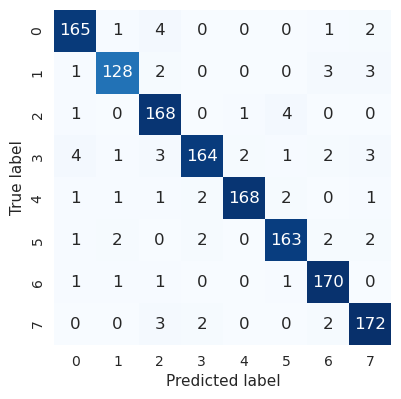

In [69]:
evaluation(y_test,gbc_pred, plot=1)

In [70]:
evaluation(y_train, gbc_train_pred, plot=0)

----------------------ACCURACY-----------------------
98.83%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       519
           2       0.99      0.99      0.99       410
           3       0.98      0.99      0.99       521
           4       0.99      0.97      0.98       540
           5       0.98      0.99      0.99       530
           6       0.99      0.99      0.99       516
           7       0.98      0.99      0.99       521
           8       0.99      0.99      0.99       538

    accuracy                           0.99      4095
   macro avg       0.99      0.99      0.99      4095
weighted avg       0.99      0.99      0.99      4095

-------------------CONFUSION MATRIX------------------
[[509   1   0   2   2   1   4   0]
 [  0 405   0   1   1   0   1   2]
 [  1   0 518   0   0   0   2   0]
 [  1   1   5 526   3   0   2   2]
 [  0   0   1   0 527   1   0   1]
 [  0

----------------------ACCURACY-----------------------
95.53%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       173
           2       0.96      0.94      0.95       137
           3       0.93      0.97      0.95       174
           4       0.97      0.93      0.95       180
           5       0.98      0.96      0.97       176
           6       0.95      0.95      0.95       172
           7       0.94      0.98      0.96       174
           8       0.95      0.97      0.96       179

    accuracy                           0.96      1365
   macro avg       0.96      0.96      0.96      1365
weighted avg       0.96      0.96      0.96      1365

------------------CONFUSION MATRIX-------------------


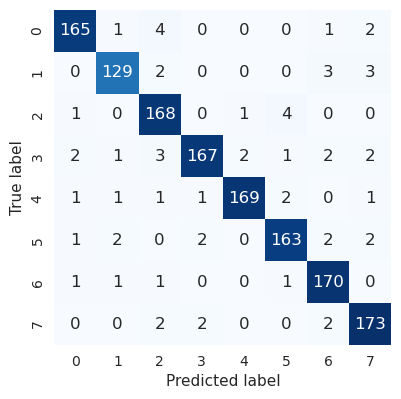

In [71]:
evaluation(y_test, rf_pred, plot=1)

In [72]:
evaluation(y_train, rf_train_pred, plot=0)

----------------------ACCURACY-----------------------
99.98%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       519
           2       1.00      1.00      1.00       410
           3       1.00      1.00      1.00       521
           4       1.00      1.00      1.00       540
           5       1.00      1.00      1.00       530
           6       1.00      1.00      1.00       516
           7       1.00      1.00      1.00       521
           8       1.00      1.00      1.00       538

    accuracy                           1.00      4095
   macro avg       1.00      1.00      1.00      4095
weighted avg       1.00      1.00      1.00      4095

-------------------CONFUSION MATRIX------------------
[[518   0   1   0   0   0   0   0]
 [  0 410   0   0   0   0   0   0]
 [  0   0 521   0   0   0   0   0]
 [  0   0   0 540   0   0   0   0]
 [  0   0   0   0 530   0   0   0]
 [  0

**Kümeleme analizi sonuçlarının eklenerek tahminleme yapılması:**

In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train[nums])
X_test_scaled = sc.fit_transform(X_test[nums])

In [74]:
for i in range(1, 4):
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')

    X_train[f'Küme_{i}'] = hierarchical_cluster.fit_predict(X_train_scaled)
    X_test[f'Küme_{i}'] = hierarchical_cluster.fit_predict(X_test_scaled)

In [75]:
rf = RandomForestClassifier(random_state=101)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_train_pred = rf.predict(X_train)

In [76]:
gbc = GradientBoostingClassifier(random_state=101)
gbc.fit(X_train, y_train)

gbc_pred = gbc.predict(X_test)
gbc_train_pred = gbc.predict(X_train)

----------------------ACCURACY-----------------------
95.09%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       173
           2       0.95      0.93      0.94       137
           3       0.93      0.97      0.95       174
           4       0.96      0.92      0.94       180
           5       0.98      0.96      0.97       176
           6       0.95      0.94      0.95       172
           7       0.94      0.98      0.96       174
           8       0.95      0.97      0.96       179

    accuracy                           0.95      1365
   macro avg       0.95      0.95      0.95      1365
weighted avg       0.95      0.95      0.95      1365

------------------CONFUSION MATRIX-------------------


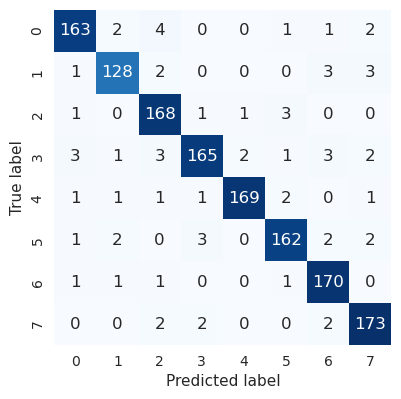

----------------------ACCURACY-----------------------
98.63%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       519
           2       0.99      0.98      0.99       410
           3       0.98      0.99      0.98       521
           4       0.99      0.97      0.98       540
           5       0.99      0.99      0.99       530
           6       0.99      0.99      0.99       516
           7       0.98      0.99      0.99       521
           8       0.99      0.99      0.99       538

    accuracy                           0.99      4095
   macro avg       0.99      0.99      0.99      4095
weighted avg       0.99      0.99      0.99      4095

------------------CONFUSION MATRIX-------------------


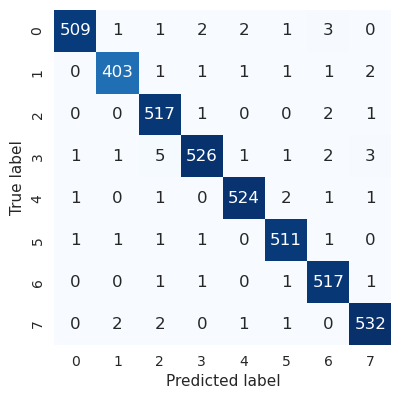

(None, None)

In [77]:
evaluation(y_test, gbc_pred),evaluation(y_train, gbc_train_pred)

----------------------ACCURACY-----------------------
95.53%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       0.96      0.95      0.96       173
           2       0.96      0.94      0.95       137
           3       0.93      0.97      0.95       174
           4       0.97      0.93      0.95       180
           5       0.98      0.96      0.97       176
           6       0.95      0.95      0.95       172
           7       0.94      0.98      0.96       174
           8       0.95      0.97      0.96       179

    accuracy                           0.96      1365
   macro avg       0.96      0.96      0.96      1365
weighted avg       0.96      0.96      0.96      1365

------------------CONFUSION MATRIX-------------------


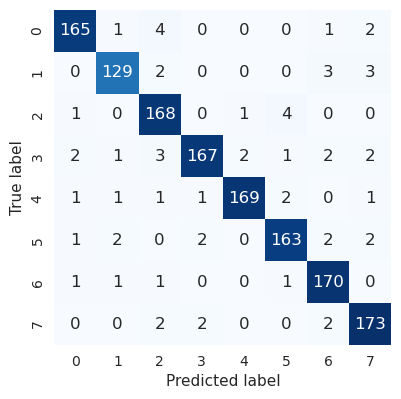

----------------------ACCURACY-----------------------
99.98%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       519
           2       1.00      1.00      1.00       410
           3       1.00      1.00      1.00       521
           4       1.00      1.00      1.00       540
           5       1.00      1.00      1.00       530
           6       1.00      1.00      1.00       516
           7       1.00      1.00      1.00       521
           8       1.00      1.00      1.00       538

    accuracy                           1.00      4095
   macro avg       1.00      1.00      1.00      4095
weighted avg       1.00      1.00      1.00      4095

------------------CONFUSION MATRIX-------------------


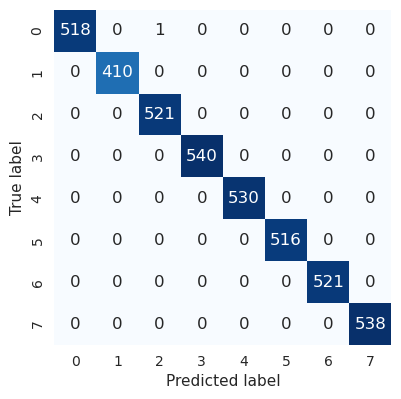

(None, None)

In [78]:
evaluation(y_test, rf_pred),evaluation(y_train, rf_train_pred)

## Modellerin Sonuçları

| Model | Test Accuracy | Train Accuracy | Özellik Çıkarımı | Hiperparametre Ayarı |
|:------|:--------:|:----------------:|:----------------:|:--------------------:|
| RandomForest | %95,53 | <span style="color:red;">%99,98</span> | ❌ | ❌ |
| Gradient Boosting | %95,09 | %98,83 | ❌ | ❌ |
| RandomForest | %95,53 | <span style="color:red;">%100</span> | ✅ | ❌ |
| Gradient Boosting | %95,09 | %98,63 | ✅ | ❌ |

⚠️ Rassal ormanlar ve Gradient Arttırma algoritmaları için overfit olduğunu söyleyebiliriz. Hiperparametre ayarı ile düşürülebilir.
* Şu fikir denenebilir:
    * Verilerimizin kümelenme görselleştirmesine bakıldığında gözle görülür küme ayrımları var. Ancak öyle bir küme var ki içerisinde çeşitli öbek sayıları yer alıyor.
    * GradientBoosting modeller karmaşık veri yapılarını kolay anlayabilen modeller olduğu için sadece o kümeyi hariç tutulup GBC ile tahmin edilip veri setine harici eklenebilir. Deneyelim...
* Özellik çıkarımı ile eklediğimiz küme numaraları modellerin gelişmesine bir katkı sağlayamadı.

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def get_OHE(X, y, split=1, ts=.3, rs=42):
    ''''get_OHE' işlevi bir veri kümesi 'X'i ve hedef değişkeni 'y'yi alır, kategorik özellikler üzerinde
    tek-etkin kodlama (OHE) gerçekleştirir ve verileri eğitim ve test kümelerine böler.
    
    Parameters
    ----------
    X
        Veri kümesi için giriş özellikleri (bağımsız değişkenler).
    y
        'y' parametresi veri kümenizdeki hedef değişkeni veya bağımlı değişkeni temsil eder. Tahmin etmeye
    veya modellemeye çalıştığınız değişkendir.
    split, optional
        "Bölme" parametresi, verilerin eğitim ve test kümelerine bölünüp bölünmeyeceğini belirler. 1 olarak
    ayarlanırsa veriler eğitim ve test kümelerine bölünür. Başka bir değere ayarlanırsa veriler
    bölünmez.
    ts
        'ts' parametresi, test için kullanılacak veri kümesinin oranını belirleyen test boyutudur. 0,3
    olarak ayarlanmıştır; bu, verilerin %30'unun test için, %70'inin eğitim için kullanılacağı anlamına
    gelir.
    rs, optional
        "rs" parametresi "random_state" anlamına gelir ve tekrarlanabilirlik için rastgele tohumu ayarlamak
    için kullanılır. Bu kodda 42 olarak ayarlanmıştır ancak bunu herhangi bir tam sayı değeriyle
    değiştirebilirsiniz.
    
    Returns
    -------
        "split" parametresinin değerine bağlı olarak farklı değerler.
    
    '''
    if split == 1:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs, stratify=y)

        cats = X_train.select_dtypes(include=['object']).columns

        X_train_num = X_train.drop(cats, axis=1)
        X_test_num = X_test.drop(cats, axis=1)

        X_train_cat = X_train[cats]
        X_test_cat = X_test[cats]

        encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', drop='first')
        encoder.fit(X_train_cat)

        X_train_encoded = encoder.transform(X_train_cat)
        X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out())

        X_test_encoded = encoder.transform(X_test_cat)
        X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out())

        X_train = pd.concat([X_train_num.reset_index(drop=1),X_train_encoded_df], axis=1)

        X_test = pd.concat([X_test_num.reset_index(drop=1),X_test_encoded_df], axis=1)

        y_train = y_train.reset_index(drop=1)
        y_test = y_test.reset_index(drop=1)

        return X_train, X_test, y_train, y_test
    
    else: 
        cats = X.select_dtypes(include=['object']).columns

        X_num = X.drop(cats, axis=1)

        X_cat = X[cats]

        encoder = OneHotEncoder(handle_unknown='infrequent_if_exist', drop='first')
        encoder.fit(X_cat)

        X_encoded = encoder.transform(X_cat)
        X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out())

        X_final = pd.concat([X_num.reset_index(drop=1),X_encoded_df], axis=1)
        
        return X_final

In [80]:
def get_rf(X_train, X_test, y_train, y_test):
    ''''get_rf' işlevi, verilen eğitim verileri üzerinde rastgele bir orman sınıflandırıcısını eğitir ve
    test verileri üzerindeki performansını değerlendirir.
    
    Parameters
    ----------
    X_train
        Rastgele orman modeli için eğitim verileri özellikleri (girdi değişkenleri).
    X_test
        X_test parametresi özelliklerin test kümesidir. Eğitilmiş rastgele orman modelini kullanarak tahmin
    yapmak istediğimiz girdi verilerini içerir.
    y_train
        'y_train' parametresi eğitim verileri için hedef değişkeni temsil eder. Eğitim seti için hedef
    değişkenin gerçek değerlerini içerir.
    y_test
        'y_test' parametresi test kümesinin gerçek etiketleridir. Eğitilmiş rastgele orman modelini
    kullanarak tahmin etmeye çalıştığımız hedef değişkendir.
    
    '''
    rf = RandomForestClassifier(random_state=101)
    rf.fit(X_train.drop('index', axis=1), y_train)

    rf_pred = rf.predict(X_test.drop('index', axis=1))
    rf_train_pred = rf.predict(X_train.drop('index', axis=1))

    evaluation(y_test, rf_pred), evaluation(y_train, rf_train_pred)

In [81]:
def get_gbc(X_train, X_test, y_train, y_test):
    '''`get_gbc` işlevi, sağlanan eğitim verilerini kullanarak bir Gradient Boosting Classifier modelini
    eğitir, test verileri üzerinde tahminler yapar ve modelin hem test hem de eğitim verileri üzerindeki
    performansını değerlendirir.
    
    Parameters
    ----------
    X_train
        GradientBoostingClassifier modeli için eğitim verileri özellikleri (giriş değişkenleri).
    X_test
        X_test, özelliklerin test kümesidir. Tahmin yapmak için kullanılan bağımsız değişkenleri içerir.
    y_train
        'y_train' parametresi eğitim verileri için hedef değişkeni temsil eder. Eğitim seti için hedef
    değişkenin gerçek değerlerini içerir.
    y_test
        'y_test' parametresi test kümesinin gerçek etiketleridir. Eğitilen modeli kullanarak tahmin etmeye
    çalıştığımız hedef değişkendir.
    
    '''
    gbc = GradientBoostingClassifier()
    gbc.fit(X_train.drop('index', axis=1), y_train)

    gbc_pred = gbc.predict(X_test.drop('index', axis=1))
    gbc_train_pred = gbc.predict(X_train.drop('index', axis=1))

    evaluation(y_test, gbc_pred), evaluation(y_train, gbc_train_pred)

In [82]:
train = pd.read_csv('/kaggle/input/datathon2023/train.csv')
test = pd.read_csv('/kaggle/input/datathon2023/test_x.csv')

In [83]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

scaled_data = sc.fit_transform(train.loc[:,nums])

In [84]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
train['Küme'] = hierarchical_cluster.fit_predict(scaled_data)

In [85]:
fig = px.scatter_3d(
    train,
    x='Yıllık Ortalama Satın Alım Miktarı',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    z='Yıllık Ortalama Gelir',
    color='Küme'
)

fig.show()

In [86]:
train_karisik = train[train['Küme'].isin([0, 4])]
train_temiz = train[~train['Küme'].isin([0, 4])]

### Temiz Veri Seti ile Tahminleme

In [87]:
train_temiz.head(2)

index Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi  \
0      0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu   
2      2    Erkek     18-30        Bekar           Lise Mezunu   

                  İstihdam Durumu  Yıllık Ortalama Gelir Yaşadığı Şehir  \
0  Düzenli ve Ücretli Bir İşi Var              748266.44    Büyük Şehir   
2  Düzenli ve Ücretli Bir İşi Var              268582.73    Küçük Şehir   

      En Çok İlgilendiği Ürün Grubu  Yıllık Ortalama Satın Alım Miktarı  \
0  Elektronik ve Teknolojik Ürünler                            32010.90   
2                             Giyim                             9924.38   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi Eğitime Devam Etme Durumu  \
0                                       37.31                   Etmiyor   
2                                       55.35                    Ediyor   

  Öbek İsmi  Yıllık Ortalama Sepete Atılan Ürün Adedi  Küme  
0    obek_4                                    102.94     1  
2    obek_8                                    141.66     2

In [88]:
X = train_temiz.drop('Öbek İsmi', axis=1)
y = train_temiz['Öbek İsmi']

In [89]:
X_train, X_test, y_train, y_test = get_OHE(X, y)
X_train.head(2)

index  Yıllık Ortalama Gelir  Yıllık Ortalama Satın Alım Miktarı  \
0   2301              334455.08                            23376.20   
1   2820              350582.56                            30566.58   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                       18.37   
1                                       18.06   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  Küme  Cinsiyet_Kadın  \
0                                     95.04     5            0.00   
1                                    106.76     5            0.00   

   Yaş Grubu_31-40  Yaş Grubu_41-50  Yaş Grubu_51-60  Yaş Grubu_>60  \
0             0.00             1.00             0.00           0.00   
1             0.00             0.00             0.00           0.00   

   Medeni Durum_Evli  Eğitim Düzeyi_Doktora Ötesi  Eğitim Düzeyi_Eğitimsiz  \
0               1.00                         0.00                     0.00   
1               1.00                         1.00                     0.00   

   Eğitim Düzeyi_Lise Mezunu  Eğitim Düzeyi_Ortaokul Mezunu  \
0                       0.00                           0.00   
1                       0.00                           0.00   

   Eğitim Düzeyi_Yüksek Lisans Mezunu  Eğitim Düzeyi_Yüksekokul Mezunu  \
0                                1.00                             0.00   
1                                0.00                             0.00   

   Eğitim Düzeyi_Üniversite Mezunu  Eğitim Düzeyi_İlkokul Mezunu  \
0                             0.00                          0.00   
1                             0.00                          0.00   

   İstihdam Durumu_Emekli  İstihdam Durumu_Kendi İşinin Sahibi  \
0                    0.00                                 0.00   
1                    0.00                                 0.00   

   İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok  \
0                                            0.00   
1                                            0.00   

   Yaşadığı Şehir_Köy veya Kasaba  Yaşadığı Şehir_Küçük Şehir  \
0                            0.00                        0.00   
1                            0.00                        1.00   

   Yaşadığı Şehir_Kırsal  En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya  \
0                   0.00                                         0.00   
1                   0.00                                         0.00   

   En Çok İlgilendiği Ürün Grubu_Giyim  \
0                                 0.00   
1                                 0.00   

   En Çok İlgilendiği Ürün Grubu_Kozmetik  \
0                                    0.00   
1                                    0.00   

   En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri  \
0                                            1.00   
1                                            0.00   

   Eğitime Devam Etme Durumu_Etmiyor  
0                               1.00  
1                               0.00

----------------------ACCURACY-----------------------
95.63%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.00      0.00      0.00         6
      obek_2       0.00      0.00      0.00         6
      obek_3       0.00      0.00      0.00         5
      obek_4       0.95      0.97      0.96       208
      obek_5       0.00      0.00      0.00         5
      obek_6       0.96      0.99      0.97       203
      obek_7       0.94      0.99      0.96       203
      obek_8       0.97      0.99      0.98       210

    accuracy                           0.96       846
   macro avg       0.48      0.49      0.48       846
weighted avg       0.93      0.96      0.94       846

------------------CONFUSION MATRIX-------------------


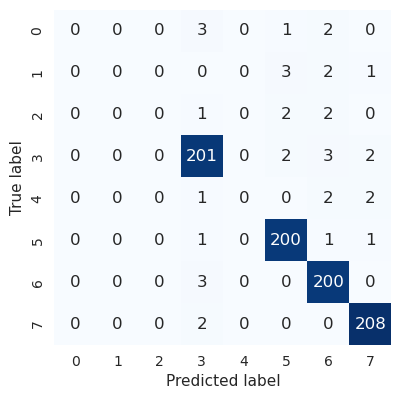

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00        14
      obek_2       1.00      1.00      1.00        15
      obek_3       1.00      1.00      1.00        12
      obek_4       1.00      1.00      1.00       486
      obek_5       1.00      1.00      1.00        11
      obek_6       1.00      1.00      1.00       472
      obek_7       1.00      1.00      1.00       472
      obek_8       1.00      1.00      1.00       490

    accuracy                           1.00      1972
   macro avg       1.00      1.00      1.00      1972
weighted avg       1.00      1.00      1.00      1972

------------------CONFUSION MATRIX-------------------


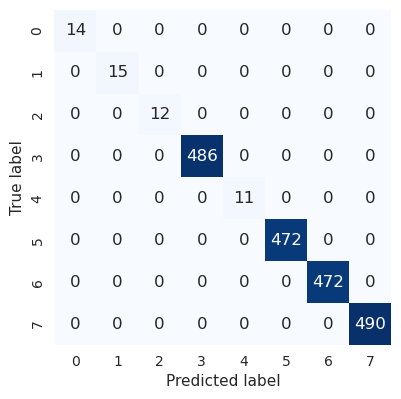

In [90]:
get_rf(X_train, X_test, y_train, y_test)

----------------------ACCURACY-----------------------
93.74%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.00      0.00      0.00         6
      obek_2       0.00      0.00      0.00         6
      obek_3       0.00      0.00      0.00         5
      obek_4       0.94      0.97      0.95       208
      obek_5       0.00      0.00      0.00         5
      obek_6       0.96      0.95      0.95       203
      obek_7       0.94      0.97      0.95       203
      obek_8       0.97      0.97      0.97       210

    accuracy                           0.94       846
   macro avg       0.48      0.48      0.48       846
weighted avg       0.93      0.94      0.93       846

------------------CONFUSION MATRIX-------------------


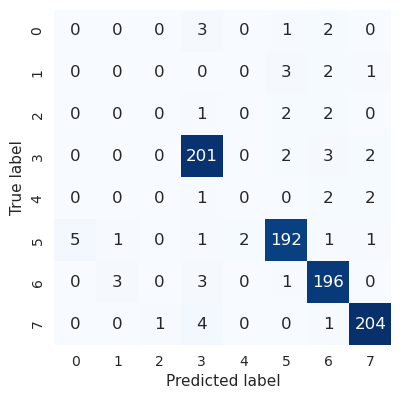

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00        14
      obek_2       1.00      1.00      1.00        15
      obek_3       1.00      1.00      1.00        12
      obek_4       1.00      1.00      1.00       486
      obek_5       1.00      1.00      1.00        11
      obek_6       1.00      1.00      1.00       472
      obek_7       1.00      1.00      1.00       472
      obek_8       1.00      1.00      1.00       490

    accuracy                           1.00      1972
   macro avg       1.00      1.00      1.00      1972
weighted avg       1.00      1.00      1.00      1972

------------------CONFUSION MATRIX-------------------


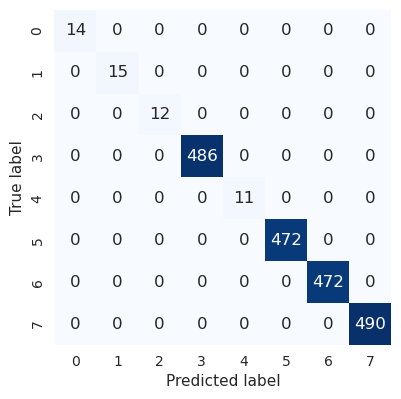

In [91]:
get_gbc(X_train, X_test, y_train, y_test)

### Karışık Veri Setini Tahminleme

In [92]:
X = train_karisik.drop(['Öbek İsmi'], axis=1)
y = train_karisik['Öbek İsmi']

In [93]:
X_train, X_test, y_train, y_test = get_OHE(X, y)

----------------------ACCURACY-----------------------
95.71%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.99      0.97      0.98       202
      obek_2       0.97      0.98      0.97       158
      obek_3       0.92      1.00      0.96       203
      obek_4       0.00      0.00      0.00         8
      obek_5       0.96      1.00      0.98       207
      obek_6       0.00      0.00      0.00         4
      obek_7       0.00      0.00      0.00         6
      obek_8       0.00      0.00      0.00         5

    accuracy                           0.96       793
   macro avg       0.48      0.49      0.49       793
weighted avg       0.93      0.96      0.94       793

------------------CONFUSION MATRIX-------------------


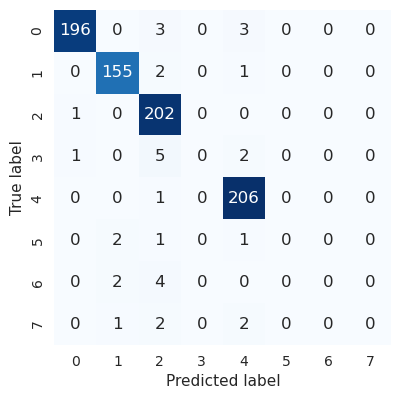

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00       470
      obek_2       1.00      1.00      1.00       368
      obek_3       1.00      1.00      1.00       475
      obek_4       1.00      1.00      1.00        18
      obek_5       1.00      1.00      1.00       483
      obek_6       1.00      1.00      1.00         9
      obek_7       1.00      1.00      1.00        14
      obek_8       1.00      1.00      1.00        12

    accuracy                           1.00      1849
   macro avg       1.00      1.00      1.00      1849
weighted avg       1.00      1.00      1.00      1849

------------------CONFUSION MATRIX-------------------


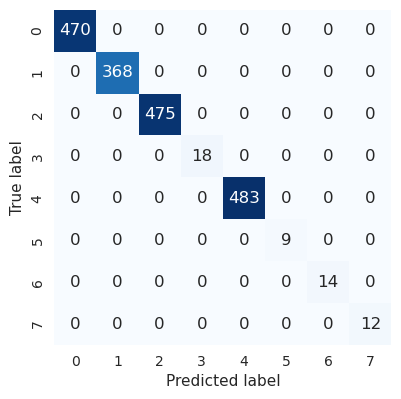

In [94]:
get_rf(X_train, X_test, y_train, y_test)

----------------------ACCURACY-----------------------
92.94%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.99      0.93      0.96       202
      obek_2       0.95      0.95      0.95       158
      obek_3       0.91      0.98      0.94       203
      obek_4       0.00      0.00      0.00         8
      obek_5       0.95      0.98      0.96       207
      obek_6       0.00      0.00      0.00         4
      obek_7       0.00      0.00      0.00         6
      obek_8       0.00      0.00      0.00         5

    accuracy                           0.93       793
   macro avg       0.48      0.48      0.48       793
weighted avg       0.92      0.93      0.93       793

------------------CONFUSION MATRIX-------------------


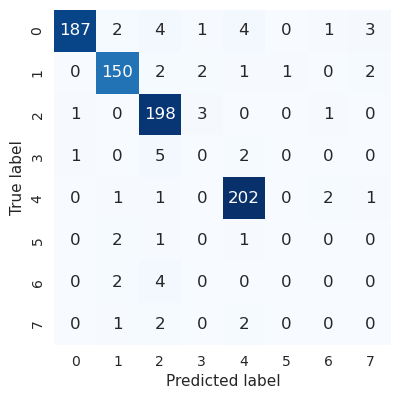

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00       470
      obek_2       1.00      1.00      1.00       368
      obek_3       1.00      1.00      1.00       475
      obek_4       1.00      1.00      1.00        18
      obek_5       1.00      1.00      1.00       483
      obek_6       1.00      1.00      1.00         9
      obek_7       1.00      1.00      1.00        14
      obek_8       1.00      1.00      1.00        12

    accuracy                           1.00      1849
   macro avg       1.00      1.00      1.00      1849
weighted avg       1.00      1.00      1.00      1849

------------------CONFUSION MATRIX-------------------


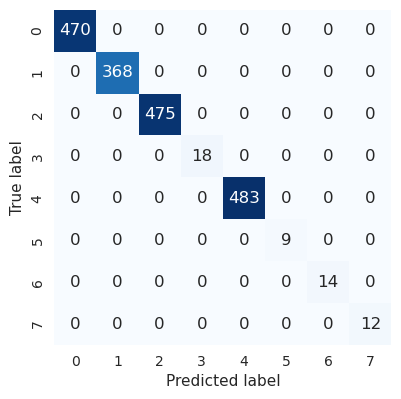

In [95]:
get_gbc(X_train, X_test, y_train, y_test)

**Karışık şekilde bulunan veri setine de kümeleme analizi deneyelim:**

In [96]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

scaled_data1 = sc.fit_transform(train_karisik.loc[:,nums])

In [97]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
train_karisik['Küme'] = hierarchical_cluster.fit_predict(scaled_data1)

In [98]:
fig = px.scatter_3d(
    train_karisik,
    x='Yıllık Ortalama Satın Alım Miktarı',
    y='Yıllık Ortalama Sipariş Verilen Ürün Adedi',
    z='Yıllık Ortalama Gelir',
    color='Küme'
)

fig.show()

In [99]:
X = train_karisik.drop(['Öbek İsmi'], axis=1)
y = train_karisik['Öbek İsmi']

X_train, X_test, y_train, y_test = get_OHE(X, y)

----------------------ACCURACY-----------------------
95.71%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.99      0.97      0.98       202
      obek_2       0.97      0.98      0.97       158
      obek_3       0.92      1.00      0.96       203
      obek_4       0.00      0.00      0.00         8
      obek_5       0.96      1.00      0.98       207
      obek_6       0.00      0.00      0.00         4
      obek_7       0.00      0.00      0.00         6
      obek_8       0.00      0.00      0.00         5

    accuracy                           0.96       793
   macro avg       0.48      0.49      0.49       793
weighted avg       0.93      0.96      0.94       793

------------------CONFUSION MATRIX-------------------


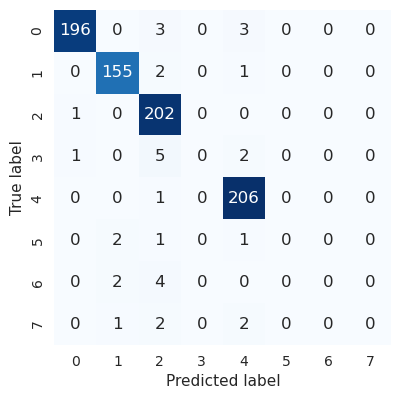

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00       470
      obek_2       1.00      1.00      1.00       368
      obek_3       1.00      1.00      1.00       475
      obek_4       1.00      1.00      1.00        18
      obek_5       1.00      1.00      1.00       483
      obek_6       1.00      1.00      1.00         9
      obek_7       1.00      1.00      1.00        14
      obek_8       1.00      1.00      1.00        12

    accuracy                           1.00      1849
   macro avg       1.00      1.00      1.00      1849
weighted avg       1.00      1.00      1.00      1849

------------------CONFUSION MATRIX-------------------


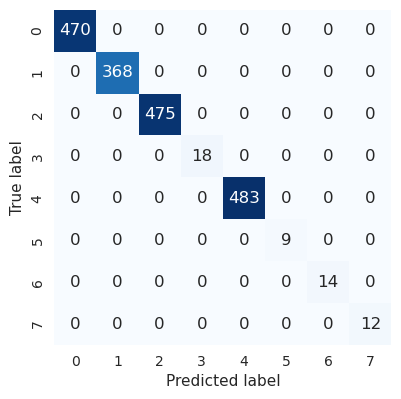

In [100]:
get_rf(X_train, X_test, y_train, y_test)

----------------------ACCURACY-----------------------
92.81%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       0.99      0.93      0.96       202
      obek_2       0.95      0.95      0.95       158
      obek_3       0.92      0.98      0.95       203
      obek_4       0.00      0.00      0.00         8
      obek_5       0.96      0.97      0.96       207
      obek_6       0.00      0.00      0.00         4
      obek_7       0.00      0.00      0.00         6
      obek_8       0.00      0.00      0.00         5

    accuracy                           0.93       793
   macro avg       0.48      0.48      0.48       793
weighted avg       0.93      0.93      0.93       793

------------------CONFUSION MATRIX-------------------


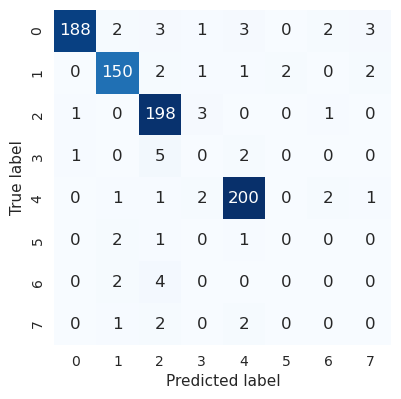

----------------------ACCURACY-----------------------
100.00%
----------------CLASSIFICATION REPORT----------------
              precision    recall  f1-score   support

      obek_1       1.00      1.00      1.00       470
      obek_2       1.00      1.00      1.00       368
      obek_3       1.00      1.00      1.00       475
      obek_4       1.00      1.00      1.00        18
      obek_5       1.00      1.00      1.00       483
      obek_6       1.00      1.00      1.00         9
      obek_7       1.00      1.00      1.00        14
      obek_8       1.00      1.00      1.00        12

    accuracy                           1.00      1849
   macro avg       1.00      1.00      1.00      1849
weighted avg       1.00      1.00      1.00      1849

------------------CONFUSION MATRIX-------------------


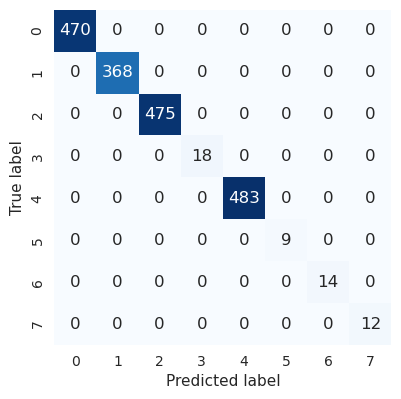

In [101]:
get_gbc(X_train, X_test, y_train, y_test)

# Sonuç ve Tartışma

Çeşitli yöntemlerle denemeler yapıldı ve aşağıdaki sonuçlar elde edildi:

1. Öncelikle sadece encode, ön işleme ile tahminleme çalışması yapıldı ve yaklaşık %96 'lık bir başarı elde edildi.
1. Sonrasında kümeleme analizi ile küme özelliği veri setine eklenerek deneme yapıldı;
    1. Sadece tek bir özellik olarak kümeleme sonuçları eklendi ancak başarıyı arttırmadı.
    1. Dallanma şekliyle kümeleme özellikleri eklendi (bkz: [Dallandırma Yöntemi](#dallandırma-yöntemi-ile-kümeleme)
        Ancak bu durum modellerin overfit (aşırı öğrenme) etmesine sebep oldu.
1. Kümeleme analizi sırasında farkedilen, belirli bir küme içerisinde öbek sayısının dağılım göstermesi veri setini iki parçaya ayırarak karışmış kısmı ilişkisel olmayan karmaşık verileri daha kolay öğrenebilen model olan GradientBoosting modeli ile tahmin etme yöntemi uygulandı. Ancak kayda değer bir gelişim göstermemekle birlikte train veri setinde %100 lük bir tahminleme ile yine aynı şekilde overfite sebep oldu.

Tüm bu nedenlerden dolayı veri setine özellik eklemek yerine default şekilde predict edip overfit etmeyecek şekilde hiperparametre ayarı ile çalışmanın sonlandırılması uygun görüldü.

---

<details>
    <summary><b>Dallandırma Yöntemi ile Kümeleme Analizi için tıklayın</b></summary>

    
Bu işlem, veri setinin daha fazla içgörü kazanmasına yardımcı olabilir ve model performansını artırabilir. Veri setinin daha ayrıntılı bir şekilde incelenmesine ve farklı kümeleme sonuçlarının modelin performansına etkisinin değerlendirilmesine yardımcı olabilir.

**Örnek Senaryo:**

Diyelim ki elimizde bir veri seti var ve bu veri setini 2 küme halinde bölmek istiyoruz. Ancak sadece 2 kümeyle sınırlı kalmak istemiyoruz, daha fazla kümeleme seçeneği de düşünüyoruz.

**Adım Adım İşlem:**

1. Başlangıçta, veri setimiz aşağıdaki gibi olsun (sadece 2 özellik ve 6 örnek gösterilmiştir):

   | Örnek | Özellik 1 | Özellik 2 |
   |-------|-----------|-----------|
   | 1     | 2         | 3         |
   | 2     | 5         | 8         |
   | 3     | 9         | 10        |
   | 4     | 3         | 6         |
   | 5     | 1         | 4         |
   | 6     | 7         | 9         |

2. İlk olarak, 2 küme olacak şekilde veri setini bölmeyi düşünelim. Bu durumda, aşağıdaki gibi iki küme elde ederiz:

   | Örnek | Özellik 1 | Özellik 2 | Küme_1 |
   |-------|-----------|-----------|------|
   | 1     | 2         | 3         | 0    |
   | 2     | 5         | 8         | 1    |
   | 3     | 9         | 10        | 1    |
   | 4     | 3         | 6         | 0    |
   | 5     | 1         | 4         | 0    |
   | 6     | 7         | 9         | 1    |

3. Ancak şimdi daha fazla kümeleme seçeneği düşünerek 2'ye böldüğümüz kümeleme özelliğine ek olarak 2 kümeye daha bölelim: 

   - Küme 0: 0, 1, 0 
   - Küme 1: 0, 1, 1

4. Bu durumda aşağıdaki gibi bir sonuç elde ederiz:

   | Örnek | Özellik 1 | Özellik 2 | Küme_1 | Küme_2 |
   |-------|-----------|-----------|------|--------|
   | 1     | 2         | 3         | 0    | 0      |
   | 2     | 5         | 8         | 1    | 0      |
   | 3     | 9         | 10        | 1    | 1      |
   | 4     | 3         | 6         | 0    | 1      |
   | 5     | 1         | 4         | 0    | 0      |
   | 6     | 7         | 9         | 1    | 1      |
   

**Örnek Kodlama:**

```python
for i in range(1, 4):
    # AgglomerativeClustering modelini belirtilen küme sayısı ile oluşturma
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')

    # Eğitim verisi üzerinde kümeleme analizi yapma ve sonuçları yeni sütun olarak ekme
    X_train[f'Küme_{i}'] = hierarchical_cluster.fit_predict(X_train_scaled)
    
    # Test verisi üzerinde kümeleme analizi yapma ve sonuçları yeni sütun olarak ekme
    X_test[f'Küme_{i}'] = hierarchical_cluster.fit_predict(X_test_scaled)
```
    
</details>



---

In [102]:
def ordinal_map(df):
    ''''Ordinal_map' işlevi, bir DataFrame'deki kategorik değişkenleri sıralı değerlerle eşler.
    
    Parameters
    ----------
    df
        'df' parametresi "Eğitim Düzeyi" ve "Yaş Grubu" isimli sütunları içeren bir pandas DataFrame'dir.
    'Ordinal_map' işlevi, 'egitim_duzeyi_map' ve 'egitim_duzeyi_map' sözlüklerini kullanarak bu
    sütunlardaki değerleri sıralı değerlerle eşleştirir.
    
    Returns
    -------
        'Eğitim Düzeyi' ve 'Yaş Grubu' sütunlarının karşılık gelen sıra değerlerine eşlendiği değiştirilmiş
    veri çerçevesi.
    
    '''

    egitim_duzeyi_map = {
        "Eğitimsiz":0,
        "İlkokul Mezunu":1,
        "Ortaokul Mezunu":2,
        "Lise Mezunu": 3,
        "Yüksekokul Mezunu":4,
        "Üniversite Mezunu":5,
        'Yüksek Lisans Mezunu':6,''
        "Doktora Mezunu":7,
        "Doktora Ötesi":8
    }

    yas_grubu_map = {
        '18-30':1,
        '31-40':2,
        '41-50':3,
        '51-60':4,
        '>60':5
    }
    
    df['Eğitim Düzeyi'] = df['Eğitim Düzeyi'].map(egitim_duzeyi_map)
    df['Yaş Grubu'] = df['Yaş Grubu'].map(yas_grubu_map)
    
    return df

In [103]:
train = pd.read_csv('/kaggle/input/datathon2023/train.csv')
test = pd.read_csv('/kaggle/input/datathon2023/test_x.csv')

train = ordinal_map(train)
test = ordinal_map(test)

In [104]:
X = train.drop('Öbek İsmi', axis=1)
y = train['Öbek İsmi']

X_train, X_test, y_train, y_test = get_OHE(X, y)

**Overfitting Azaltmak için Hiperparametre Ayarı:**

In [105]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=101)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=1)

In [106]:
import time
start = time.time()

grid_search.fit(X_train.drop('index', axis=1), y_train)

end = time.time()
print(f"Training Time: {int((end-start)/60)}:{(end-start)%60:.0f}")

Training Time: 8:37


In [107]:
selected_columns = ['params', 'mean_train_score', 'mean_test_score', 'mean_fit_time']
grid_search_results = pd.DataFrame(grid_search.cv_results_)
grid_search_results[selected_columns].sort_values(by=['mean_test_score', 'mean_train_score', 'mean_fit_time'], ascending=[False,True,True]).head()

params  mean_train_score  \
158  {'max_depth': 10, 'max_features': 'log2', 'min...              0.96   
161  {'max_depth': 10, 'max_features': 'log2', 'min...              0.96   
155  {'max_depth': 10, 'max_features': 'log2', 'min...              0.96   
128  {'max_depth': 10, 'max_features': 'sqrt', 'min...              0.96   
134  {'max_depth': 10, 'max_features': 'sqrt', 'min...              0.96   

     mean_test_score  mean_fit_time  
158             0.96           0.96  
161             0.96           0.97  
155             0.96           0.97  
128             0.96           0.97  
134             0.96           0.97

In [108]:
gbc_model = GradientBoostingClassifier(random_state=101)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

grid_search_gbc = GridSearchCV(estimator=gbc_model, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=1)

In [109]:
import time
start = time.time()

grid_search_gbc.fit(X_train.drop('index', axis=1), y_train)

end = time.time()
print(f"Training Time: {int((end-start)/60)}:{(end-start)%60:.0f}")

Training Time: 102:27


In [110]:
grid_search_results_gbc = pd.DataFrame(grid_search_gbc.cv_results_)
grid_search_results_gbc[grid_search_results_gbc['mean_train_score']!=1.00][selected_columns].sort_values(by=['mean_test_score', 'mean_train_score', 'mean_fit_time'], ascending=[False,True,True]).head()

params  mean_train_score  \
26  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...              0.96   
20  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...              0.96   
23  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...              0.96   
8   {'learning_rate': 0.01, 'max_depth': 3, 'min_s...              0.96   
17  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...              0.96   

    mean_test_score  mean_fit_time  
26             0.95          11.22  
20             0.95          11.25  
23             0.95          11.31  
8              0.95          11.28  
17             0.95          11.24

**Overfitten arındırılmış en iyi modeller:**

| Model | Parametreleri | Train Acc | Test Acc | Öğrenim Süresi |
|:------|:--------------|:---------:|:--------:|:--------------:|
| Gradient Boosting | 'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200 | %96 | %95 | 11.11sn |
| Random Forest | 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200 | %96 | %95 | 1.13sn |

---

# Submission

In [111]:
train = pd.read_csv('/kaggle/input/datathon2023/train.csv')
test = pd.read_csv('/kaggle/input/datathon2023/test_x.csv')

In [112]:
train = ordinal_map(train)
test = ordinal_map(test)

In [113]:
X_train = train.drop(['Öbek İsmi'], axis=1)
y_train = train['Öbek İsmi']

X_train = get_OHE(X_train, y_train, split=0)
X_train.head()

index  Yaş Grubu  Eğitim Düzeyi  Yıllık Ortalama Gelir  \
0      0          2              6              748266.44   
1      1          5              3              246298.61   
2      2          1              3              268582.73   
3      3          4              3              327721.84   
4      4          2              2              397431.63   

   Yıllık Ortalama Satın Alım Miktarı  \
0                            32010.90   
1                             4145.73   
2                             9924.38   
3                             6417.78   
4                             7886.66   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                       37.31   
1                                       11.55   
2                                       55.35   
3                                       15.42   
4                                       14.69   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  \
0                                    102.94            1.00   
1                                     82.18            0.00   
2                                    141.66            0.00   
3                                     17.10            0.00   
4                                     20.47            0.00   

   Medeni Durum_Evli  İstihdam Durumu_Emekli  \
0               0.00                    0.00   
1               1.00                    0.00   
2               0.00                    0.00   
3               1.00                    0.00   
4               1.00                    0.00   

   İstihdam Durumu_Kendi İşinin Sahibi  \
0                                 0.00   
1                                 1.00   
2                                 0.00   
3                                 1.00   
4                                 0.00   

   İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok  \
0                                            0.00   
1                                            0.00   
2                                            0.00   
3                                            0.00   
4                                            1.00   

   Yaşadığı Şehir_Köy veya Kasaba  Yaşadığı Şehir_Küçük Şehir  \
0                            0.00                        0.00   
1                            0.00                        1.00   
2                            0.00                        1.00   
3                            0.00                        0.00   
4                            0.00                        0.00   

   Yaşadığı Şehir_Kırsal  En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya  \
0                   0.00                                         0.00   
1                   0.00                                         0.00   
2                   0.00                                         0.00   
3                   1.00                                         0.00   
4                   0.00                                         0.00   

   En Çok İlgilendiği Ürün Grubu_Giyim  \
0                                 0.00   
1                                 0.00   
2                                 1.00   
3                                 1.00   
4                                 1.00   

   En Çok İlgilendiği Ürün Grubu_Kozmetik  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    0.00   
4                                    0.00   

   En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri  \
0                                            0.00   
1                                            1.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   Eğitime Devam Etme Durumu_Etmiyor  
0                               1.00  
1                               1.00  
2                               0.00  
3                        

In [114]:
X_test = get_OHE(test, y=0, split=0)
X_test.head()

index  Yaş Grubu  Eğitim Düzeyi  Yıllık Ortalama Gelir  \
0      0          4              6              365331.93   
1      1          3              3              414899.24   
2      2          5              0              152825.87   
3      3          4              8              489052.91   
4      4          1              6              323635.71   

   Yıllık Ortalama Satın Alım Miktarı  \
0                             5566.59   
1                             6756.77   
2                             4493.92   
3                            42670.65   
4                             5959.27   

   Yıllık Ortalama Sipariş Verilen Ürün Adedi  \
0                                       15.44   
1                                       14.96   
2                                       10.91   
3                                       32.33   
4                                        4.52   

   Yıllık Ortalama Sepete Atılan Ürün Adedi  Cinsiyet_Kadın  \
0                                     19.65            0.00   
1                                     19.68            0.00   
2                                     46.90            1.00   
3                                     48.08            1.00   
4                                     12.75            0.00   

   Medeni Durum_Evli  İstihdam Durumu_Emekli  \
0               1.00                    0.00   
1               0.00                    0.00   
2               1.00                    0.00   
3               1.00                    0.00   
4               1.00                    0.00   

   İstihdam Durumu_Kendi İşinin Sahibi  \
0                                 0.00   
1                                 0.00   
2                                 0.00   
3                                 0.00   
4                                 1.00   

   İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok  \
0                                            0.00   
1                                            1.00   
2                                            1.00   
3                                            0.00   
4                                            0.00   

   Yaşadığı Şehir_Köy veya Kasaba  Yaşadığı Şehir_Küçük Şehir  \
0                            1.00                        0.00   
1                            0.00                        0.00   
2                            0.00                        1.00   
3                            1.00                        0.00   
4                            0.00                        1.00   

   Yaşadığı Şehir_Kırsal  En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya  \
0                   0.00                                         0.00   
1                   0.00                                         0.00   
2                   0.00                                         0.00   
3                   0.00                                         0.00   
4                   0.00                                         0.00   

   En Çok İlgilendiği Ürün Grubu_Giyim  \
0                                 1.00   
1                                 0.00   
2                                 1.00   
3                                 0.00   
4                                 1.00   

   En Çok İlgilendiği Ürün Grubu_Kozmetik  \
0                                    0.00   
1                                    0.00   
2                                    0.00   
3                                    1.00   
4                                    0.00   

   En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri  \
0                                            0.00   
1                                            1.00   
2                                            0.00   
3                                            0.00   
4                                            0.00   

   Eğitime Devam Etme Durumu_Etmiyor  
0                               1.00  
1                               1.00  
2                               1.00  
3                        

In [115]:
rf = RandomForestClassifier(
    max_depth=None,
    max_features='auto',
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=200
)
rf.fit(X_train.drop(['index'], axis=1), y_train)

RandomForestClassifier(max_features='auto', min_samples_leaf=4,
                       n_estimators=200)

In [116]:
rf_pred = rf.predict(X_test.drop(['index'], axis=1))

In [117]:
rf_submission = {
    'id':X_test['index'],
    'Öbek İsm':rf_pred
}
rf_submission = pd.DataFrame(rf_submission)
rf_submission.to_csv('rf_submission.csv', index=False)
rf_submission.head()

id Öbek İsm
0   0   obek_3
1   1   obek_3
2   2   obek_2
3   3   obek_6
4   4   obek_1

In [118]:
gbc = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_samples_leaf=3,
    min_samples_split=2,
    n_estimators=200 
)

gbc.fit(X_train.drop(['index'], axis=1), y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=3,
                           n_estimators=200)

In [119]:
gbc_pred = gbc.predict(X_test.drop(['index'], axis=1))

In [120]:
gbc_submission = {
    'id':X_test['index'],
    'Öbek İsm':gbc_pred
}
gbc_submission = pd.DataFrame(gbc_submission)
gbc_submission.to_csv('gbc_submission.csv', index=False)
gbc_submission.head()

id Öbek İsm
0   0   obek_3
1   1   obek_3
2   2   obek_2
3   3   obek_6
4   4   obek_1

# Balyalama ile Kategorik Analizi & Tahminleme

Bir diğer teknik olan tüm numeric değerleri balyalayıp tüm feature değerlerini kategorik hale getirip *Bayes Teoremi* ve *CatBoost* ile tahmin etmek denenebilir. 

**NOT:** Bu kısım için vaktim yetmedi.